In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
np.seterr(divide='ignore')
import seaborn as sns
from bisect import bisect
from tqdm import tqdm
from functools import partial
from scipy.stats import ttest_ind
from scipy.optimize import curve_fit
import statsmodels.formula.api as smf

sns.set_style("darkgrid")
import typing
from typing import Optional, List
import os

# AllReduce + Straggler Delay Modeling

## Data Import

### Bandwidth

In [6]:
jobdir = "/data/home/sanketpurandare/cluster/job_logs" ## YOUR PATH HERE
## DIRECTORY STRUCTURE
## jobdir
## - BW_C1.../
## - BW_C2.../
## - [all other bandwidth directories]
## - C1/
##    - C1_20231024_2131/
##    - .... /
## - C2/
##    - .../

In [7]:
bw_dirs = [p for p in os.listdir(jobdir) if "BW_C" in p]

# Format: Chunk Size -> [inter, intra]

bw_files = {
    i: [None for _ in range(2)]
    for i in range(1, 4)
}

for dir in bw_dirs:
    chunk_size = int(dir[dir.find("C") + 1])
    idx = int(len(os.listdir(os.path.join(jobdir, dir, "bandwidth"))) <= 8)
    bw_files[chunk_size][idx] = os.path.join(jobdir, dir, "bandwidth")

In [8]:
def get_bandwidth(path: str, intra: bool = False) -> pd.DataFrame:
    bw_files = os.listdir(path)
    bw_dfs = [
        pd.read_csv(os.path.join(path, f), header=None).rename(
            columns={0: "size", 1: "time"}
        )
        for f in bw_files
    ]
    bw_df = pd.concat(bw_dfs, axis=0).groupby("size").max().reset_index()

    if intra:
        bw_df["time"] /= 2.0

    bw_df["bandwidth"] = bw_df["size"] / bw_df["time"]
    return bw_df

def get_bandwidth_min(path: str, intra: bool = False) -> pd.DataFrame:
    bw_files = os.listdir(path)
    bw_dfs = [
        pd.read_csv(os.path.join(path, f), header=None).rename(
            columns={0: "size", 1: "time"}
        )
        for f in bw_files
    ]
    bw_df = pd.concat(bw_dfs, axis=0).groupby("size").min().reset_index()

    if intra:
        bw_df["time"] /= 2.0

    bw_df["bandwidth"] = bw_df["size"] / bw_df["time"]
    return bw_df

In [9]:
def bw_file_apply(func):
    out = {
        i: [None for _ in range(2)]
        for i in range(1, 4)
    }

    for key, vals in bw_files.items():
        for i, val in enumerate(vals):
            out[key][i] = func(val)
    
    return out

/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

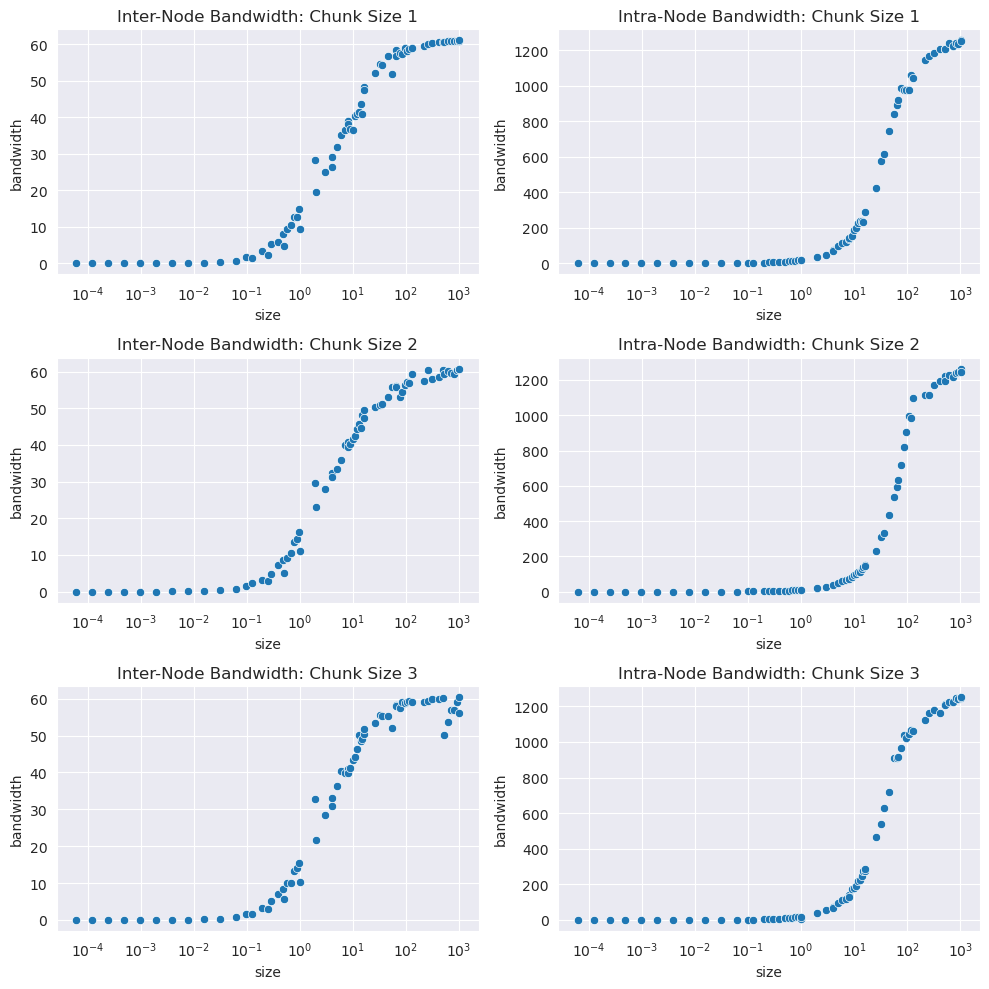

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

for key, vals in bw_files.items():
    row = ax[key - 1]
    inter_df = get_bandwidth(vals[0])
    sns.scatterplot(
        data=inter_df,
        x="size",
        y="bandwidth",
        ax=row[0]
    )
    row[0].set_xscale("log")
    row[0].set_title(f"Inter-Node Bandwidth: Chunk Size {key}")
    
    intra_df = get_bandwidth(vals[1])
    sns.scatterplot(
        data=intra_df,
        x="size",
        y="bandwidth",
        ax=row[1]
    )
    row[1].set_xscale("log")
    row[1].set_title(f"Intra-Node Bandwidth: Chunk Size {key}")

plt.tight_layout()

### NCCL

In [13]:
def parse_log_file(path: str):
    def remove_info_prefix(line: str):
        INFO_STR = "NCCL INFO "
        idx = line.find(INFO_STR)
        return line[idx + len(INFO_STR) :]


    # NCCL strings for functions, algorithms, and protocols
    FUNC = ["Broadcast", "Reduce", "AllGather", "ReduceScatter", "AllReduce"]
    ALGO = ["Tree", "Ring", "CollNetDirect", "CollNetChain", "NVLS", "NVLSTree"]
    PROTO = ["LL", "LL128", "Simple"]

    # First line of the table: search for this to find start
    first_line = "  Algorithm   |                            Tree                  |                            Ring                  |                   CollNetDirect                  |"

    # String Lengths
    FUNC_NAME_LEN = 15
    LATENCY_LEN = 8
    BANDWIDTH_LEN = 7
    ENTRY_LEN = LATENCY_LEN + BANDWIDTH_LEN + 2
    ALGO_ENTRY_LEN = ENTRY_LEN * 3
    TABLE_HEIGHT = 2 * len(FUNC) + 6

    # Import tuning table
    data = open(path, "r")
    all_lines = data.read().splitlines()
    data.close()

    tuning_table_line_start = 0

    all_lines = [line for line in all_lines if "|" in line]

    for idx, line in enumerate(all_lines):
        if first_line in line:
            tuning_table_line_start = idx
            break

    tuning_table = list(
        map(
            remove_info_prefix,
            all_lines[tuning_table_line_start : tuning_table_line_start + TABLE_HEIGHT],
        )
    )
    
    return tuning_table

for key, vals in bw_files.items():
    for val in vals:
        log_path = val.replace("bandwidth", "joblogs/")
        log = os.path.join(log_path, [p for p in os.listdir(log_path) if "_0.out" in p][0])
        
        table = parse_log_file(log)
        fout = open(val.replace("bandwidth", "init/tuning.data"), "w+")
        for line in table:
            fout.write(f"{line}\n")

        fout.close()

In [14]:
# NCCL strings for functions, algorithms, and protocols
FUNC = ["Broadcast", "Reduce", "AllGather", "ReduceScatter", "AllReduce"]
ALGO = ["Tree", "Ring", "CollNetDirect", "CollNetChain", "NVLS", "NVLSTree"]
PROTO = ["LL", "LL128", "Simple"]

def read_tuning_table(path: str):
    # String Lengths
    FUNC_NAME_LEN = 15
    LATENCY_LEN = 8
    BANDWIDTH_LEN = 7
    ENTRY_LEN = LATENCY_LEN + BANDWIDTH_LEN + 2
    ALGO_ENTRY_LEN = ENTRY_LEN * 3

    # Import tuning table
    data = open(path, "r")
    tuning_table = data.read().splitlines()
    data.close()

    del tuning_table[0:3]
    del tuning_table[len(FUNC) : len(FUNC) + 3]
    
    # Parse tuning table
    latencies = {}
    bandwidths = {}

    for block in range(2):
        for ba in range(len(ALGO) // 2):
            a = ba + block * 3
            for p in range(len(PROTO)):
                for f in range(len(FUNC)):
                    algo = ALGO[a]
                    proto = PROTO[p]
                    func = FUNC[f]

                    string_pos = FUNC_NAME_LEN + ALGO_ENTRY_LEN * ba + ENTRY_LEN * p
                    latency = tuning_table[f + block * len(FUNC)][
                        string_pos : string_pos + LATENCY_LEN
                    ]
                    bandwidth = tuning_table[f + block * len(FUNC)][
                        string_pos
                        + LATENCY_LEN
                        + 1 : string_pos
                        + LATENCY_LEN
                        + BANDWIDTH_LEN
                        + 1
                    ]

                    latencies[tuple([algo, proto, func])] = (
                        float(latency) / 1e6
                    )  # convert us to s
                    bandwidths[tuple([algo, proto, func])] = float(bandwidth)

    return (latencies, bandwidths)

In [15]:
nccl_lookups = bw_file_apply(lambda x: read_tuning_table(x.replace("bandwidth", "init/tuning.data")))

In [16]:
def nccl_model(data_size: float, num_processors: int, collective: str, latencies, bandwidths):
    data_size /= 1000
    algo_str = "Tree" if collective == "AllReduce" else "Ring"
    nccl_lat_bw_cand = [
        (
            latencies[tuple([algo_str, proto, collective])],
            bandwidths[tuple([algo_str, proto, collective])],
        )
        for proto in PROTO
        if bandwidths[tuple([algo_str, proto, collective])] != 0 and latencies[tuple([algo_str, proto, collective])] != 0
    ]
    nccl_latency, nccl_bw = min(nccl_lat_bw_cand, key=lambda x: x[0] + data_size/x[1])
    return (nccl_latency + (data_size * num_processors)/nccl_bw) * 1e3

### AllReduce Benchmarking

In [17]:
all_reduce_files = {
    i: None
    for i in range(1, 4)
}

for i in range(1, 4):
    log_dir = f"/Users/emma/Documents/job_logs_chunks/C{i}"

    files_per_gpu_num = {}

    for j in list(range(8, 208, 8)):
        def get_num_gpus(data_path: str):
            return int(data_path.split("_")[-2])

        all_files = [
            os.path.join(dp, f)
            for dp, _, fn in os.walk(os.path.expanduser(log_dir))
            for f in fn
        ]

        all_data_files = [f for f in all_files if ".data" in f and f"_{j}_" in f]

        files = [f for f in all_data_files if "all_reduce" in f]
        files.sort(key=get_num_gpus)

        files_per_gpu_num[j] = files

    all_reduce_files[i] = files_per_gpu_num

In [18]:
dfs = {
    1: None,
    2: None,
    3: None
}

for chunk_idx, chunk_files in all_reduce_files.items():
    num_gpus_dfs = {}
    for num_gpus, files in chunk_files.items():
        gpu_dfs = [
            pd.read_csv(file, header=None).iloc[:, 1] for idx, file in enumerate(files)
        ]

        full_df = pd.concat(gpu_dfs, axis=1)
        means = full_df.min(axis=1)
        pct = full_df.quantile(0.75, axis=1)

        df = pd.concat([pd.read_csv(files[0], header=None).iloc[:, 0], means, pct], axis=1)
        df.columns = ["size", "time", "time_75"]

        df = df.groupby("size").median()

        num_gpus_dfs[num_gpus] = df

    dfs[chunk_idx] = num_gpus_dfs

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_3004050/3207827240.py", line 14, in <module>
    full_df = pd.concat(gpu_dfs, axis=1)
  File "/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/pandas/core/reshape/concat.py", line 380, in concat
    verify_integrity=verify_integrity,
  File "/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/pandas/core/reshape/concat.py", line 443, in __init__
  File "/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/pandas/core/reshape/concat.py", line 505, in _clean_keys_and_objs
    axis = sample._get_block_manager_axis(axis)
ValueError: No objects to concatenate

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File

In [19]:
dfs

{1: None, 2: None, 3: None}

## Fitting Bandwidth Sigmoid Curves

In [20]:
def sigmoid(x, L, x0, k, b):
    y = L / (1 + np.exp(-k * (x - x0))) + b
    return y


def log_sigmoid(x, L, x0, k, b):
    return sigmoid(np.log(x), L, x0, k, b)


def fit_sigmoid(data: pd.DataFrame):
    guess = [
        max(data["bandwidth"]),
        np.median(np.log(data["size"])),
        1,
        -5,
    ]  # this is an mandatory initial guess
    params, _ = curve_fit(
        sigmoid, np.log(data["size"]), data["bandwidth"], guess, method="dogbox", bounds=(-np.inf, [np.inf, np.inf, np.inf, -1])
    )

    return params

/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_d

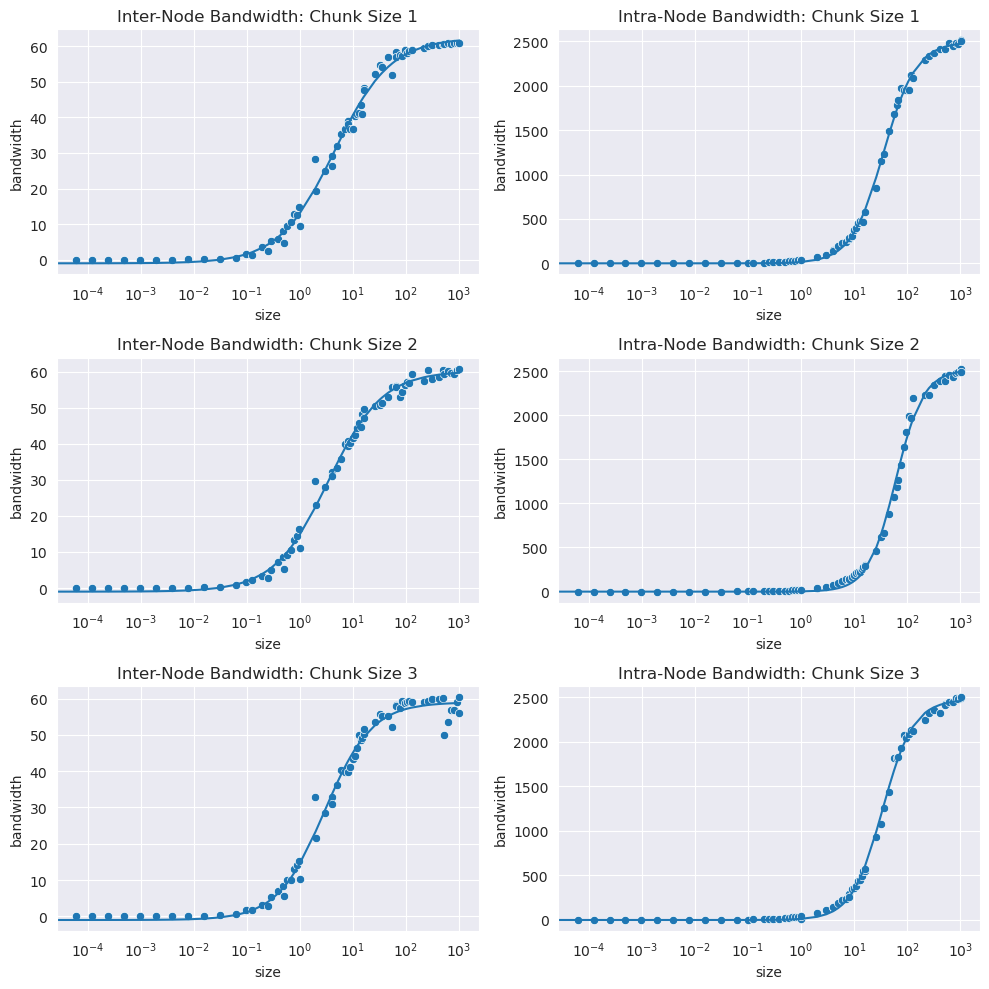

In [21]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

for key, vals in bw_files.items():
    row = ax[key - 1]
    inter_df = get_bandwidth(vals[0])
    curve_params = fit_sigmoid(inter_df)
    sns.scatterplot(
        data=inter_df,
        x="size",
        y="bandwidth",
        ax=row[0]
    )
    sns.lineplot(
        x=inter_df["size"],
        y=[log_sigmoid(size, *curve_params) for size in inter_df["size"]],
        ax=row[0]
    )
    row[0].set_xscale("log")
    row[0].set_title(f"Inter-Node Bandwidth: Chunk Size {key}")
    
    intra_df = get_bandwidth(vals[1], intra=True)
    intra_curve_params = fit_sigmoid(intra_df)
    sns.scatterplot(
        data=intra_df,
        x="size",
        y="bandwidth",
        ax=row[1]
    )
    sns.lineplot(
        x=intra_df["size"],
        y=[log_sigmoid(size, *intra_curve_params) for size in intra_df["size"]],
        ax=row[1]
    )
    row[1].set_xscale("log")
    row[1].set_title(f"Intra-Node Bandwidth: Chunk Size {key}")

plt.tight_layout()

In [22]:
bw_params = bw_file_apply(lambda x: fit_sigmoid(get_bandwidth(x)))
bw_params

{1: [array([63.28828855,  1.51736375,  0.82599393, -1.        ]),
  array([ 1.24863614e+03,  3.57692291e+00,  1.42050558e+00, -1.00000000e+00])],
 2: [array([61.13672573,  1.23488753,  0.85256677, -1.        ]),
  array([ 1.25875159e+03,  4.09892143e+00,  1.65898911e+00, -1.00000000e+00])],
 3: [array([59.98320834,  1.07640727,  0.97581534, -1.        ]),
  array([ 1.23903426e+03,  3.52992542e+00,  1.48543185e+00, -1.00000000e+00])]}

In [23]:
bw_params = {
    i: [None for _ in range(2)]
    for i in range(1, 4)
}

for key, vals in bw_files.items():
    for i, val in enumerate(vals):
        if i == 0:
            bw_params[key][i] = fit_sigmoid(get_bandwidth(val))
        else:
            bw_params[key][i] = fit_sigmoid(get_bandwidth(val, intra=True))

bw_params

{1: [array([63.28828855,  1.51736375,  0.82599393, -1.        ]),
  array([ 2.49596382e+03,  3.57752459e+00,  1.42217647e+00, -1.00000000e+00])],
 2: [array([61.13672573,  1.23488753,  0.85256677, -1.        ]),
  array([ 2.51602718e+03,  4.09942226e+00,  1.66211958e+00, -1.00000000e+00])],
 3: [array([59.98320834,  1.07640727,  0.97581534, -1.        ]),
  array([ 2.47678934e+03,  3.53054344e+00,  1.48718625e+00, -1.00000000e+00])]}

In [24]:
# bw_latencies = bw_file_apply(lambda x: get_bandwidth(x).iloc[0]["time"])

In [25]:
bw_latencies = {
    i: [None for _ in range(2)]
    for i in range(1, 4)
}

for key, vals in bw_files.items():
    for i, val in enumerate(vals):
        if i == 0:
            bw_latencies[key][i] = get_bandwidth_min(val).iloc[0]["time"]
        else:
            bw_latencies[key][i] = get_bandwidth_min(val, intra=True).iloc[0]["time"]

In [26]:
bw_latencies

{1: [0.0135680004023015, 0.0348159987479448],
 2: [0.0138240004889667, 0.0335360001772642],
 3: [0.0133120003156363, 0.03366400115191935]}

/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/fsx/users/sanketpurandare/conda/envs/torchsrc/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_in

Text(0.5, 1.0, 'Inter-Node Bandwidth Curve w/ Adjustment')

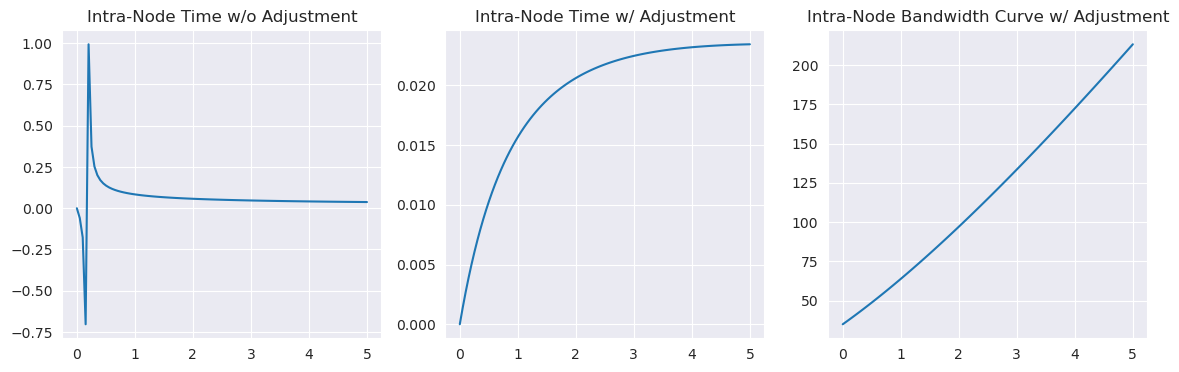

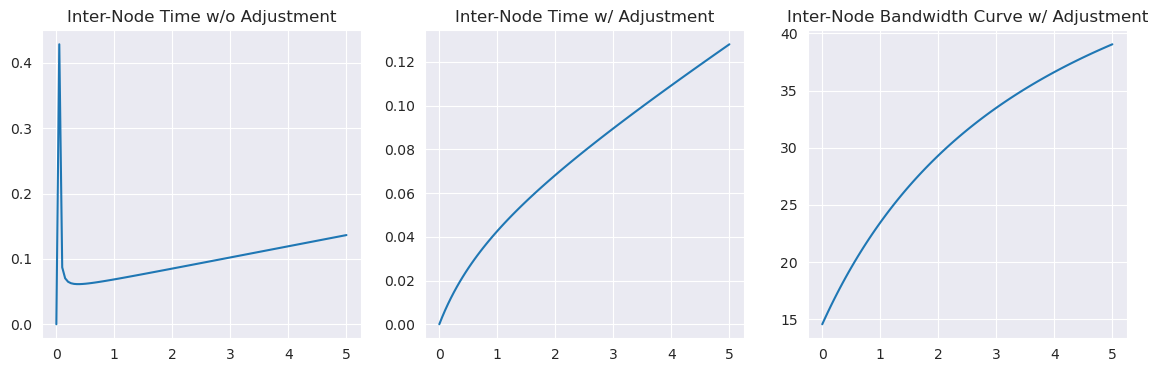

In [27]:
def intra_bw(x):
    return log_sigmoid(x, *bw_params[3][1])

def inter_bw(x):
    return log_sigmoid(x, *bw_params[3][0])

fig, ax = plt.subplots(1, 3, figsize=(14, 4))

intra_offset = 2
inter_offset = 1

sns.lineplot(
    x=np.linspace(0, 5, 100),
    y=[x/intra_bw(x) for x in np.linspace(0, 5, 100)],
    ax=ax[0]
)
ax[0].set_title("Intra-Node Time w/o Adjustment")

sns.lineplot(
    x=np.linspace(0, 5, 100),
    y=[(x)/intra_bw(x + intra_offset) for x in np.linspace(0, 5, 100)],
    ax=ax[1]
)
ax[1].set_title("Intra-Node Time w/ Adjustment")

sns.lineplot(
    x=np.linspace(0, 5, 100),
    y=[intra_bw(x + intra_offset) for x in np.linspace(0, 5, 100)],
    ax=ax[2]
)
ax[2].set_title("Intra-Node Bandwidth Curve w/ Adjustment")

fig, ax = plt.subplots(1, 3, figsize=(14, 4))

sns.lineplot(
    x=np.linspace(0, 5, 100),
    y=[x/inter_bw(x) for x in np.linspace(0, 5, 100)],
    ax=ax[0]
)
ax[0].set_title("Inter-Node Time w/o Adjustment")

sns.lineplot(
    x=np.linspace(0, 5, 100),
    y=[x/inter_bw(x + inter_offset) for x in np.linspace(0, 5, 100)],
    ax=ax[1]
)
ax[1].set_title("Inter-Node Time w/ Adjustment")

sns.lineplot(
    x=np.linspace(0, 5, 100),
    y=[inter_bw(x + inter_offset) for x in np.linspace(0, 5, 100)],
    ax=ax[2]
)
ax[2].set_title("Inter-Node Bandwidth Curve w/ Adjustment")

## AllReduce Cost Model

In [28]:
gpus_per_node = 8

We want to be able to perform a hyperparameter search where one of the tunable parameters is the *number* of breaks in the piecewise linear model. Thus, we use `bisect` to find where we should use the non-linear sigmoid model, and where to use some constant bandwidth.

In [29]:
## ALLREDUCE
def all_reduce_model(
    data_size: float,
    num_nodes: int,
    num_processors: Optional[int] = None,
    thresholds: List[int] = [],
    verbose: bool = False,
    chunk_size: int = 1
):

    inter_params, intra_params = bw_params[chunk_size][0], bw_params[chunk_size][1]

    if num_processors == None:
        num_processors = num_nodes * gpus_per_node

    # inter_df, intra_df = dfs[chunk_size][0], dfs[chunk_size][1]

    inter_node_latency, intra_node_latency = bw_latencies[chunk_size][0], bw_latencies[chunk_size][1]

    piecewise_idx = bisect(thresholds, data_size)
    if piecewise_idx == 0:
        inter_bandwidth, intra_bandwidth = log_sigmoid(data_size + inter_offset, *inter_params), log_sigmoid(data_size + intra_offset, *intra_params)#  + 0.3) # offset: workaround for discontinuity of x/sigmoid(log(x)) (see below)
    else:
        threshold_size = thresholds[piecewise_idx - 1]
        inter_bandwidth, intra_bandwidth = log_sigmoid(threshold_size + inter_offset, *inter_params), log_sigmoid(
            threshold_size + intra_offset, *intra_params
        )
        # inter_bandwidth, intra_bandwidth = inter_spl(threshold_size), intra_spl(threshold_size)

    time_tree = (
        (2  * data_size) / (inter_bandwidth)
        if num_nodes > 1
        else 0
    )
    time_chain = (2 * data_size) / (
        intra_bandwidth
    )

    if num_nodes == 1:
        inter_node_latency = 0
        
    latency = (np.floor(np.log2(num_nodes)) + 1) * inter_node_latency + (
        (num_processors / num_nodes) - 1
    ) * intra_node_latency
    # latency = 0

    if verbose:
        print(
            f"Size = {data_size:0.4f}, Time Tree: {time_tree:0.3f}, Time Chain: {time_chain:0.3f}, Latency: {latency:0.3f} = Total {time_tree + time_chain + latency:0.3f}"
        )

    return time_tree + time_chain + latency

In [30]:
dfs[1][8]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
def plot_allreduce(
    lower_lim: int = None, upper_lim: int = None, thresholds: List[int] = [], chunk_size:int = 1
):
    fig, ax = plt.subplots(5, 5, figsize=(20, 20))
    ax = ax.flatten()

    mses = []
    nccl_mses = []

    for idx, axis in enumerate(ax):
        num_gpus = (idx + 1) * gpus_per_node
        data_df = dfs[chunk_size][num_gpus].copy().loc[lower_lim:upper_lim]

        data_df["model"] = [
            all_reduce_model(
                size,
                num_gpus // gpus_per_node,
                num_gpus,
                thresholds=thresholds,
                chunk_size=chunk_size
            )
            for size in data_df.index
        ]

        data_df["nccl"] = [nccl_model(size, 1, "AllReduce", latencies=nccl_lookups[chunk_size][0][0], bandwidths=nccl_lookups[chunk_size][0][1]) for size in data_df.index]

    #     # sns.scatterplot(data=data_df, x="size", y="min", ax=axis, label="AllReduce Min")
    #     # sns.scatterplot(data=data_df, x="size", y="max", ax=axis, label="AllReduce Max")
        sns.scatterplot(data=data_df, x="size", y="time", ax=axis, label="AllReduce")
        sns.scatterplot(
            data=data_df,
            x="size",
            y="model",
            ax=axis,
            label="Cost Model",
        )
        sns.scatterplot(data=data_df, x="size", y="nccl", ax=axis, label="NCCL Model")

        for cut in thresholds:
            axis.axvline(cut, 0, 50, c="red")

        axis.legend()

        axis.set_title(
            f"{num_gpus} GPUs, MSE = {((data_df['model'] - data_df['time'])**2).mean(axis=0):0.3f}, NCCL MSE = {((data_df['nccl'] - data_df['time'])**2).mean(axis=0):0.3f}"
        )

        mses.append(((data_df["model"] - data_df["time"]) ** 2).mean(axis=0))
        nccl_mses.append(((data_df["nccl"] - data_df["time"]) ** 2).mean(axis=0))
        axis.set_xlim(
            lower_lim - 1 if lower_lim != None else lower_lim,
            upper_lim + 1 if upper_lim != None else lower_lim,
        )

    plt.suptitle(
        f"AllReduce (Mean MSE={sum(mses)/len(mses):0.3f}, Mean NCCL MSE={sum(nccl_mses)/len(nccl_mses):0.3f})",
        size=16,
    )
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

    fig, ax = plt.subplots()
    sns.scatterplot(x=list(range(1, 26)), y=mses, ax=ax, label="Cost Model")
    sns.scatterplot(x=list(range(1, 26)), y=nccl_mses, ax=ax, label="NCCL")
    ax.legend()

    tstat, pval = ttest_ind(mses, nccl_mses, equal_var=False, alternative="less")

    ax.set_title(
        f"MSE of Model vs Number of Nodes (t-stat = {tstat:0.2f}, p = {pval:0.3f})"
    )

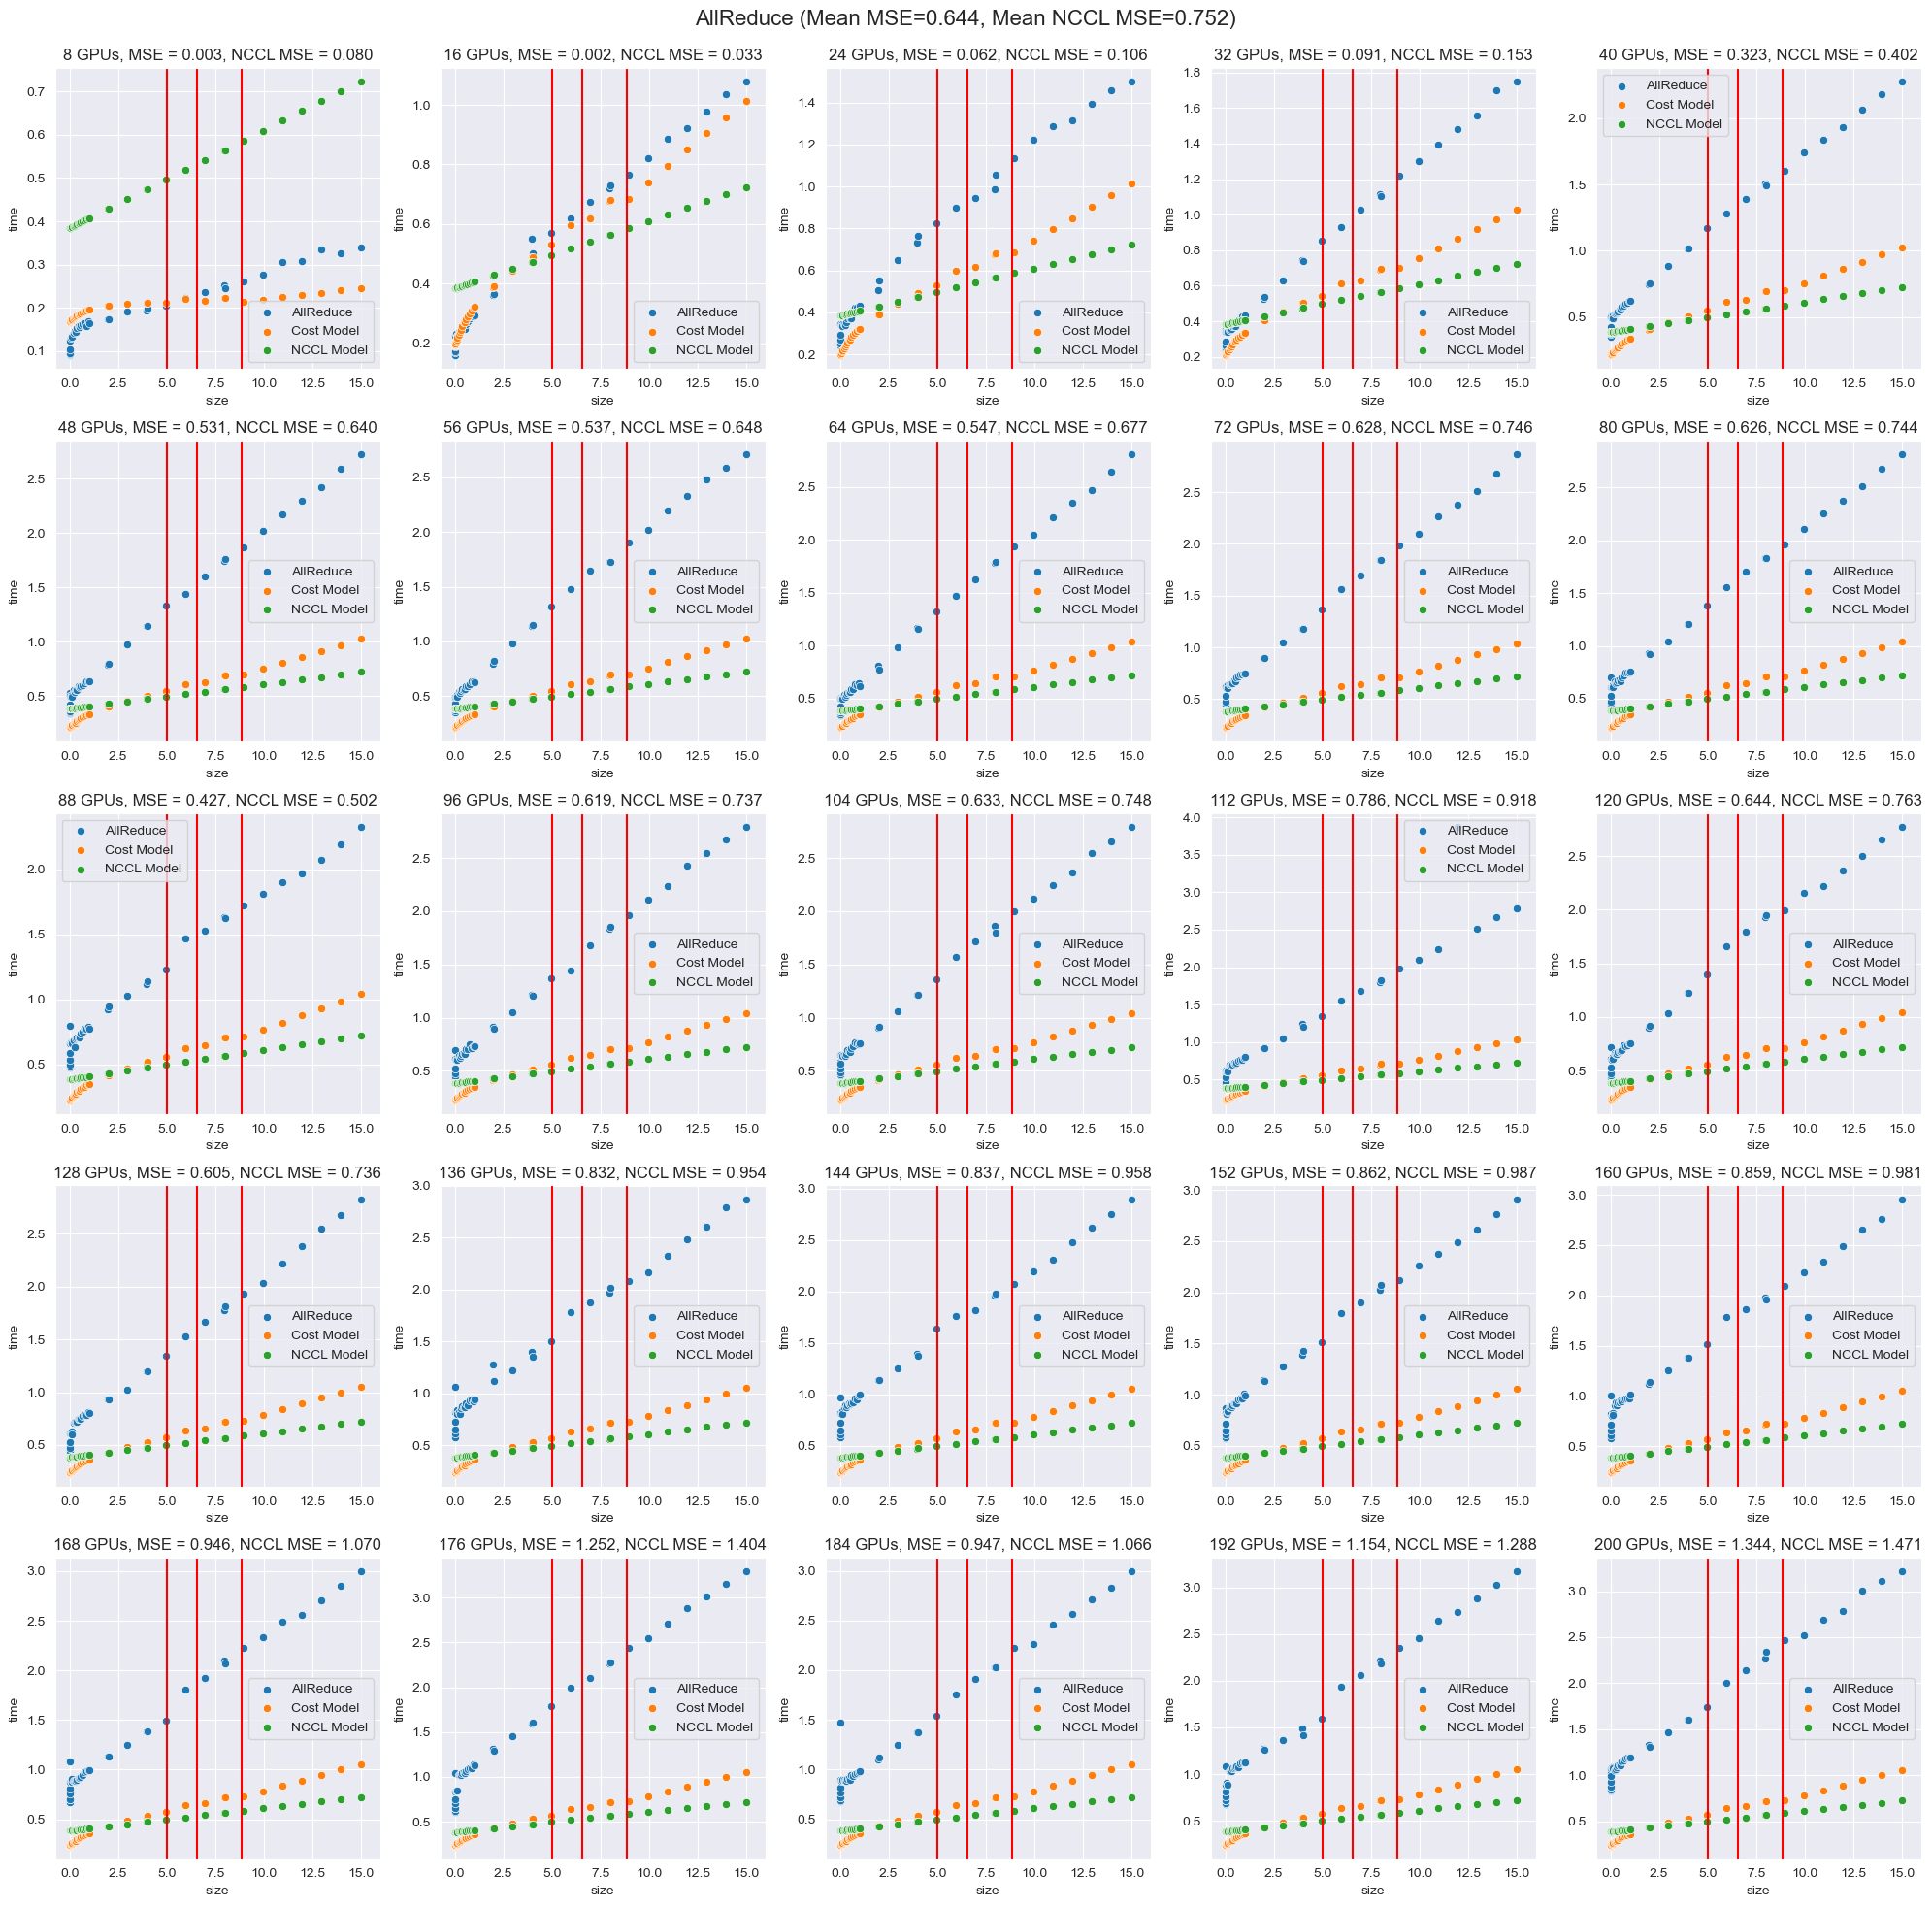

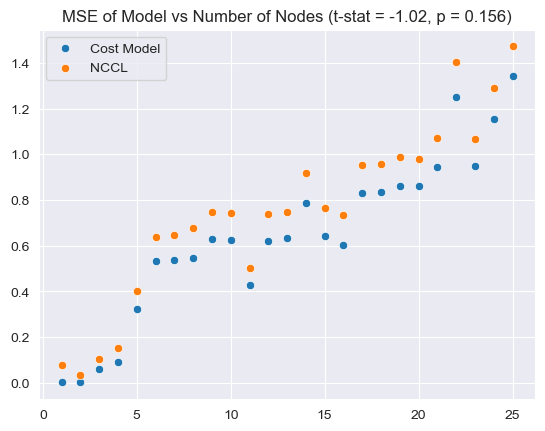

In [ ]:
plot_allreduce(upper_lim=15, thresholds=[5.0, 6.578947368421053, 8.86426592797784], chunk_size=1)

### Defining Optimization Objective

In [ ]:
def all_reduce_error(
    nodes: int, lower_lim: int = None, upper_lim: int = None, thresholds: List[int] = [], chunk_size: int = 1
):

    num_gpus = nodes * gpus_per_node
    data_df = dfs[chunk_size][num_gpus]

    data_df["model"] = [
        all_reduce_model(
            size,
            num_gpus // gpus_per_node,
            num_gpus,
            thresholds=thresholds,
            chunk_size=chunk_size
        )
        for size in data_df.index
    ]

    mse = ((data_df["model"] - data_df["time"]) ** 2).mean(axis=0)
    return mse


# Unweighted mean of all errors
def all_reduce_total_error(
    lower_lim: int = None, upper_lim: int = None, thresholds: List[int] = [], chunk_size: int = 1
):
    errors = [
        all_reduce_error(
            n, lower_lim=lower_lim, upper_lim=upper_lim, thresholds=thresholds, chunk_size=chunk_size
        )
        for n in range(1, 26)
    ]

    return sum(errors) / len(errors)

### Defining Search Space

In [ ]:
threshold_space = []
nsamples = 20 # Number of samples per dimension

for i in np.linspace(0.25, 5, nsamples):
    for j in np.linspace(i, 20, nsamples):
        for k in np.linspace(j, 50, nsamples):
            threshold_space.append([i, j, k])

In [ ]:
len(threshold_space)

8000

In [ ]:
threshold_space[:5]

[[0.25, 0.25, 0.25],
 [0.25, 0.25, 2.8684210526315788],
 [0.25, 0.25, 5.4868421052631575],
 [0.25, 0.25, 8.105263157894736],
 [0.25, 0.25, 10.723684210526315]]

### Search

CHUNK SIZE 1
[1.0, 1.0, 8.736842105263158] 55.391658690849994


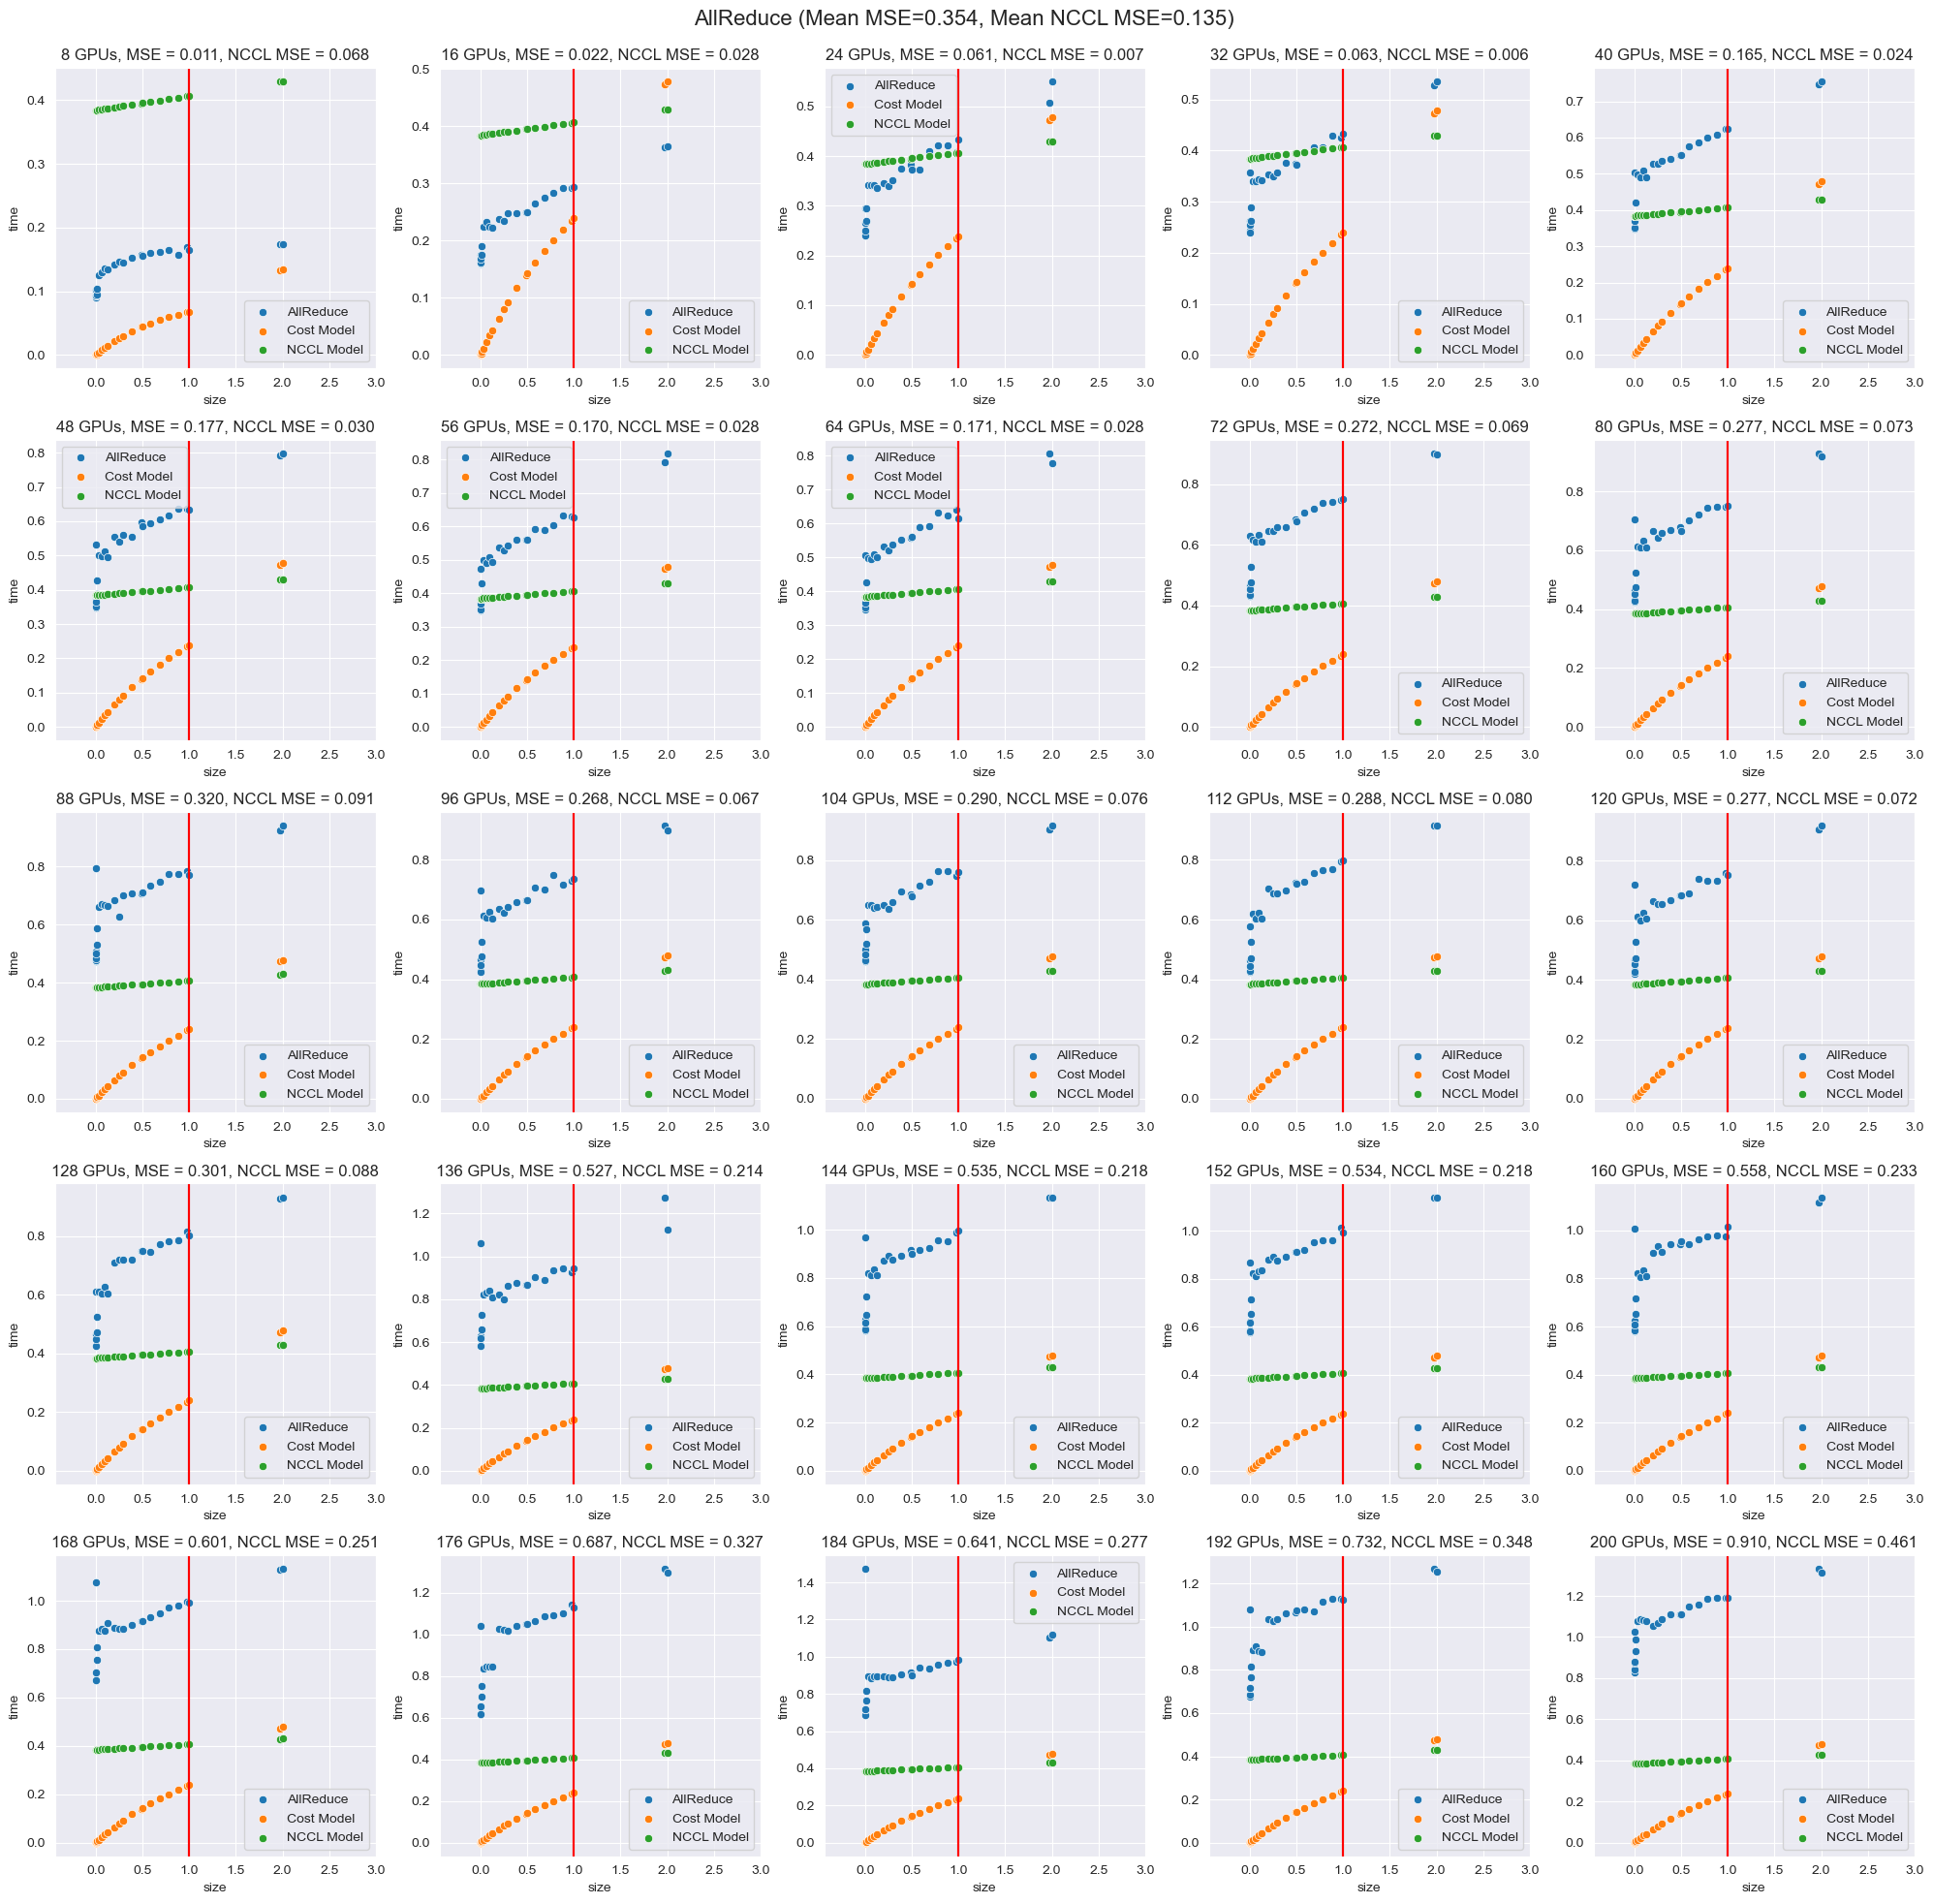

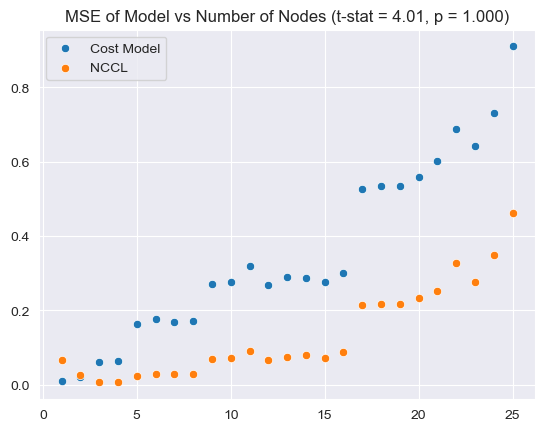

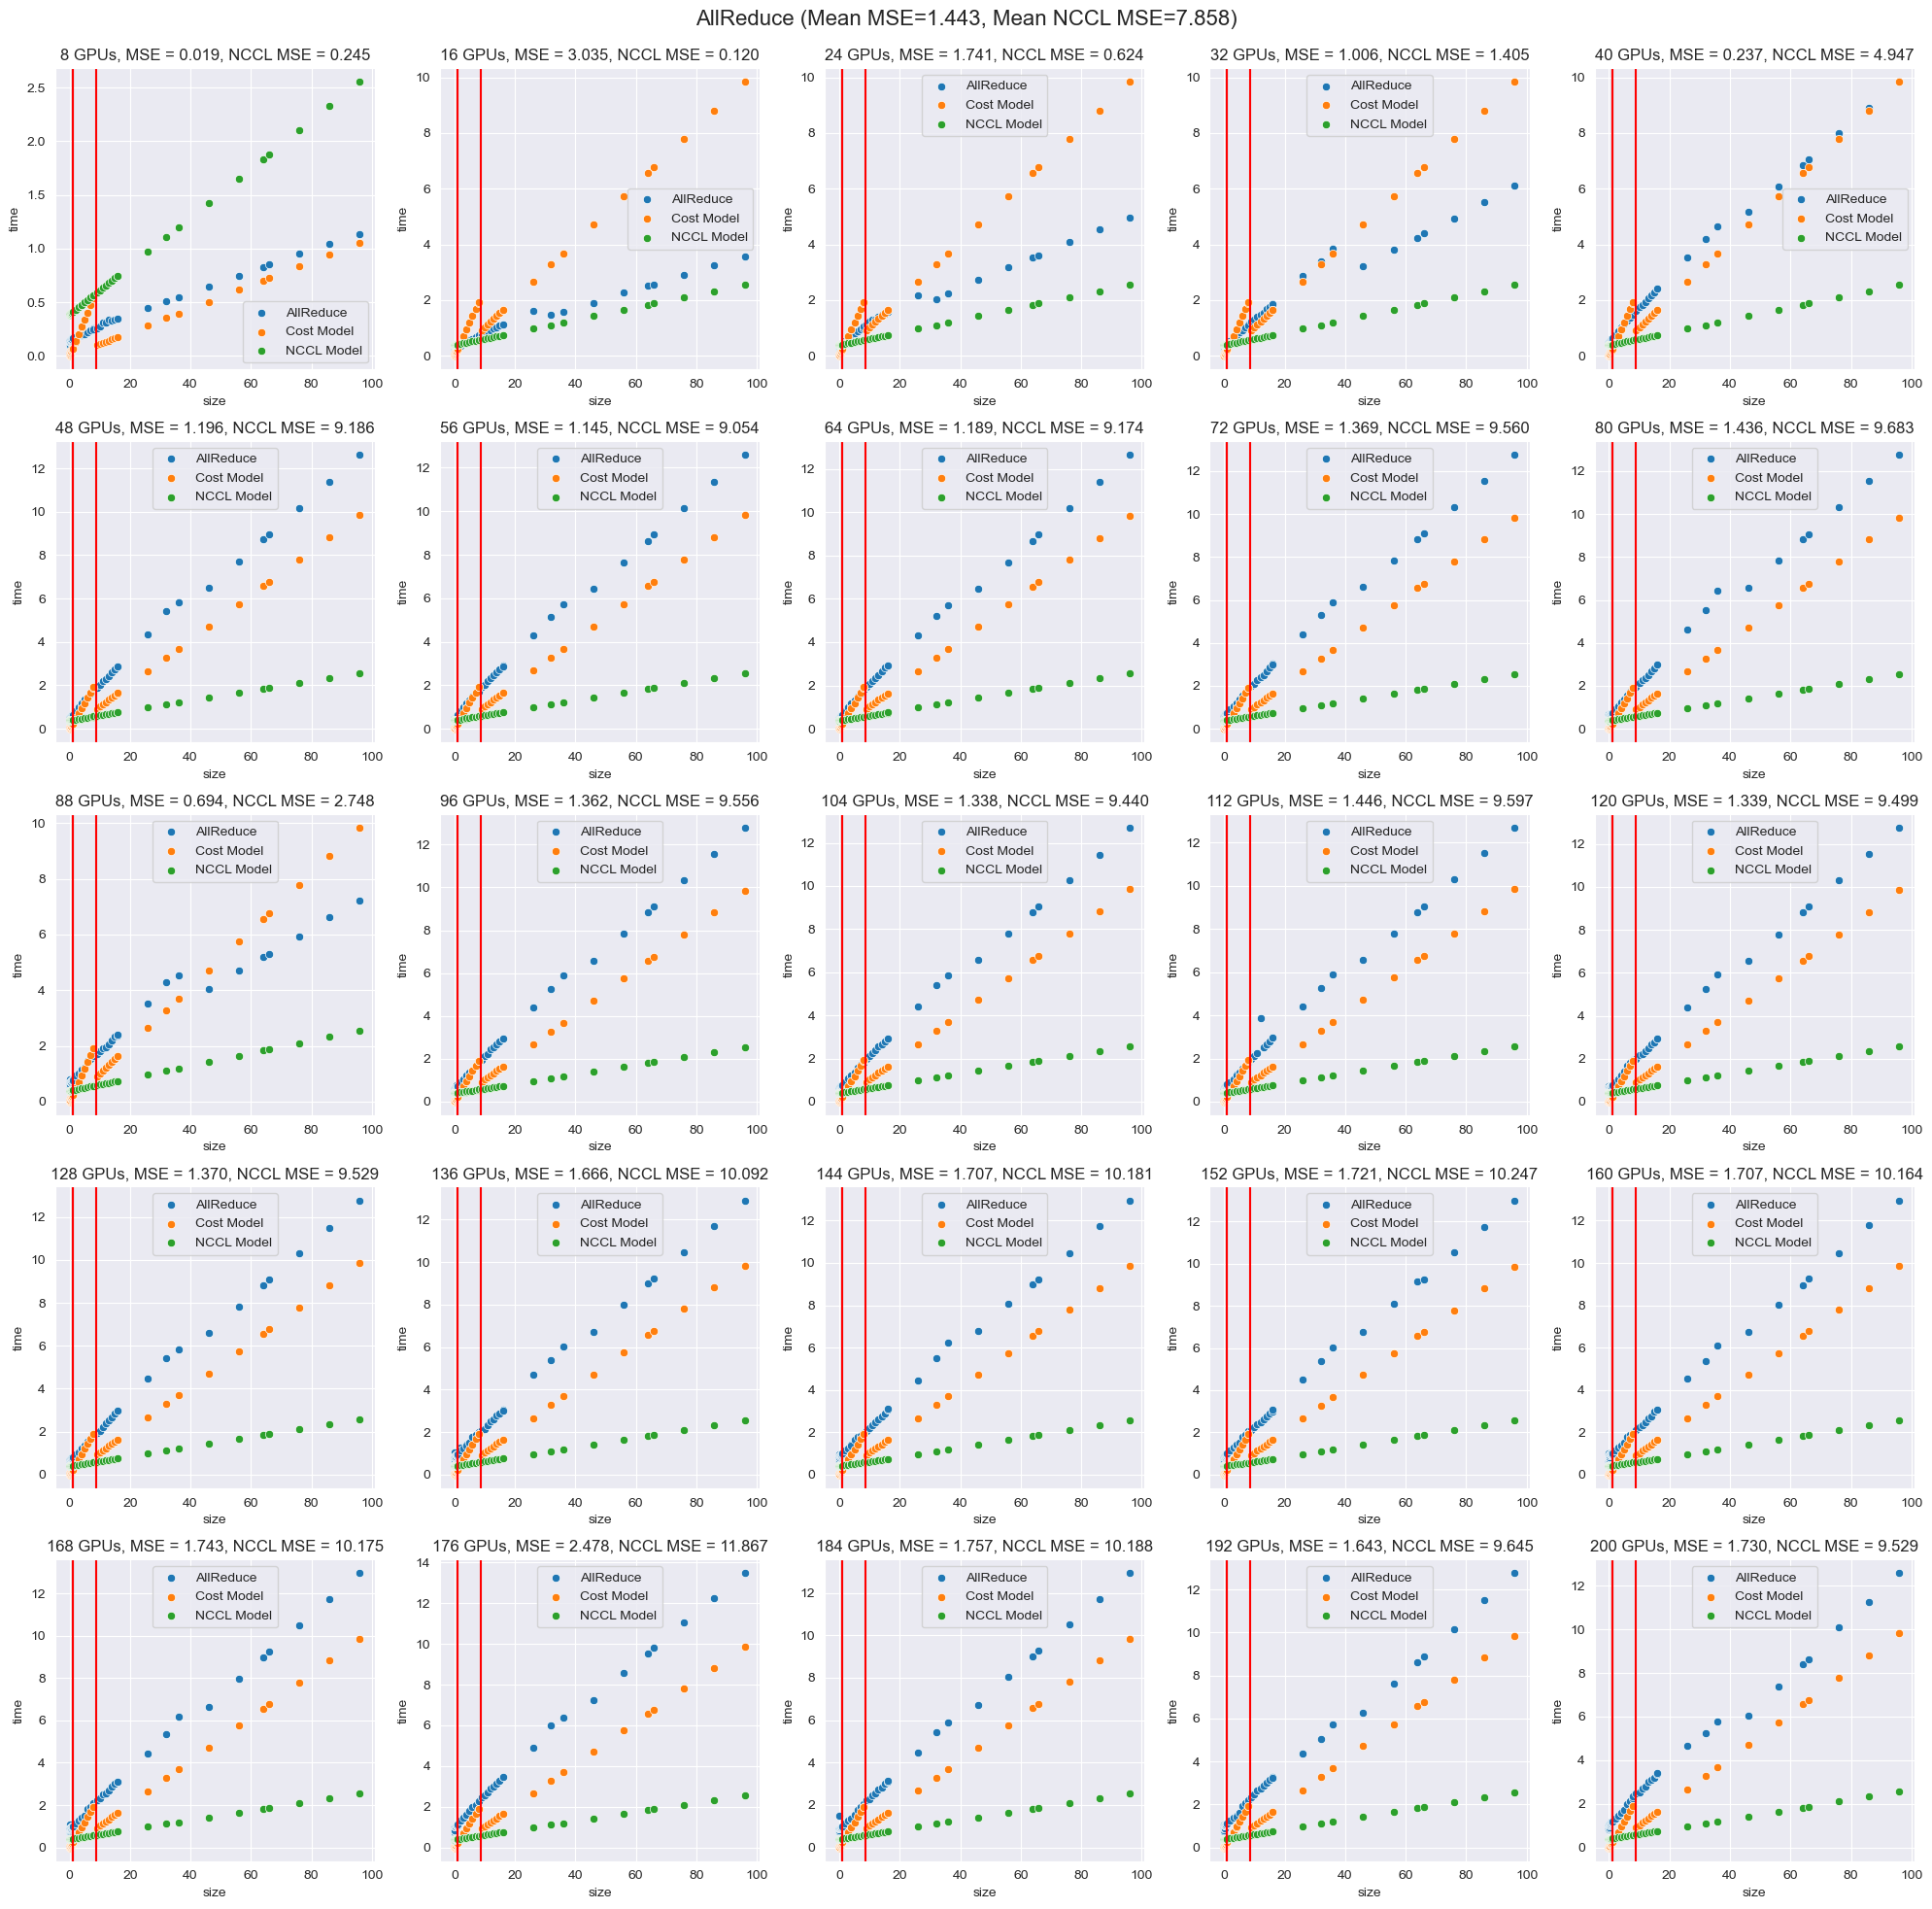

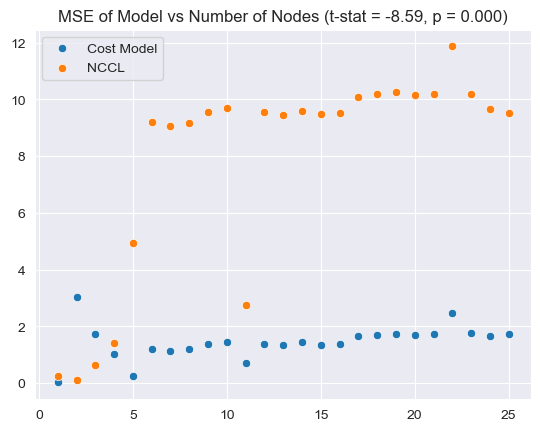

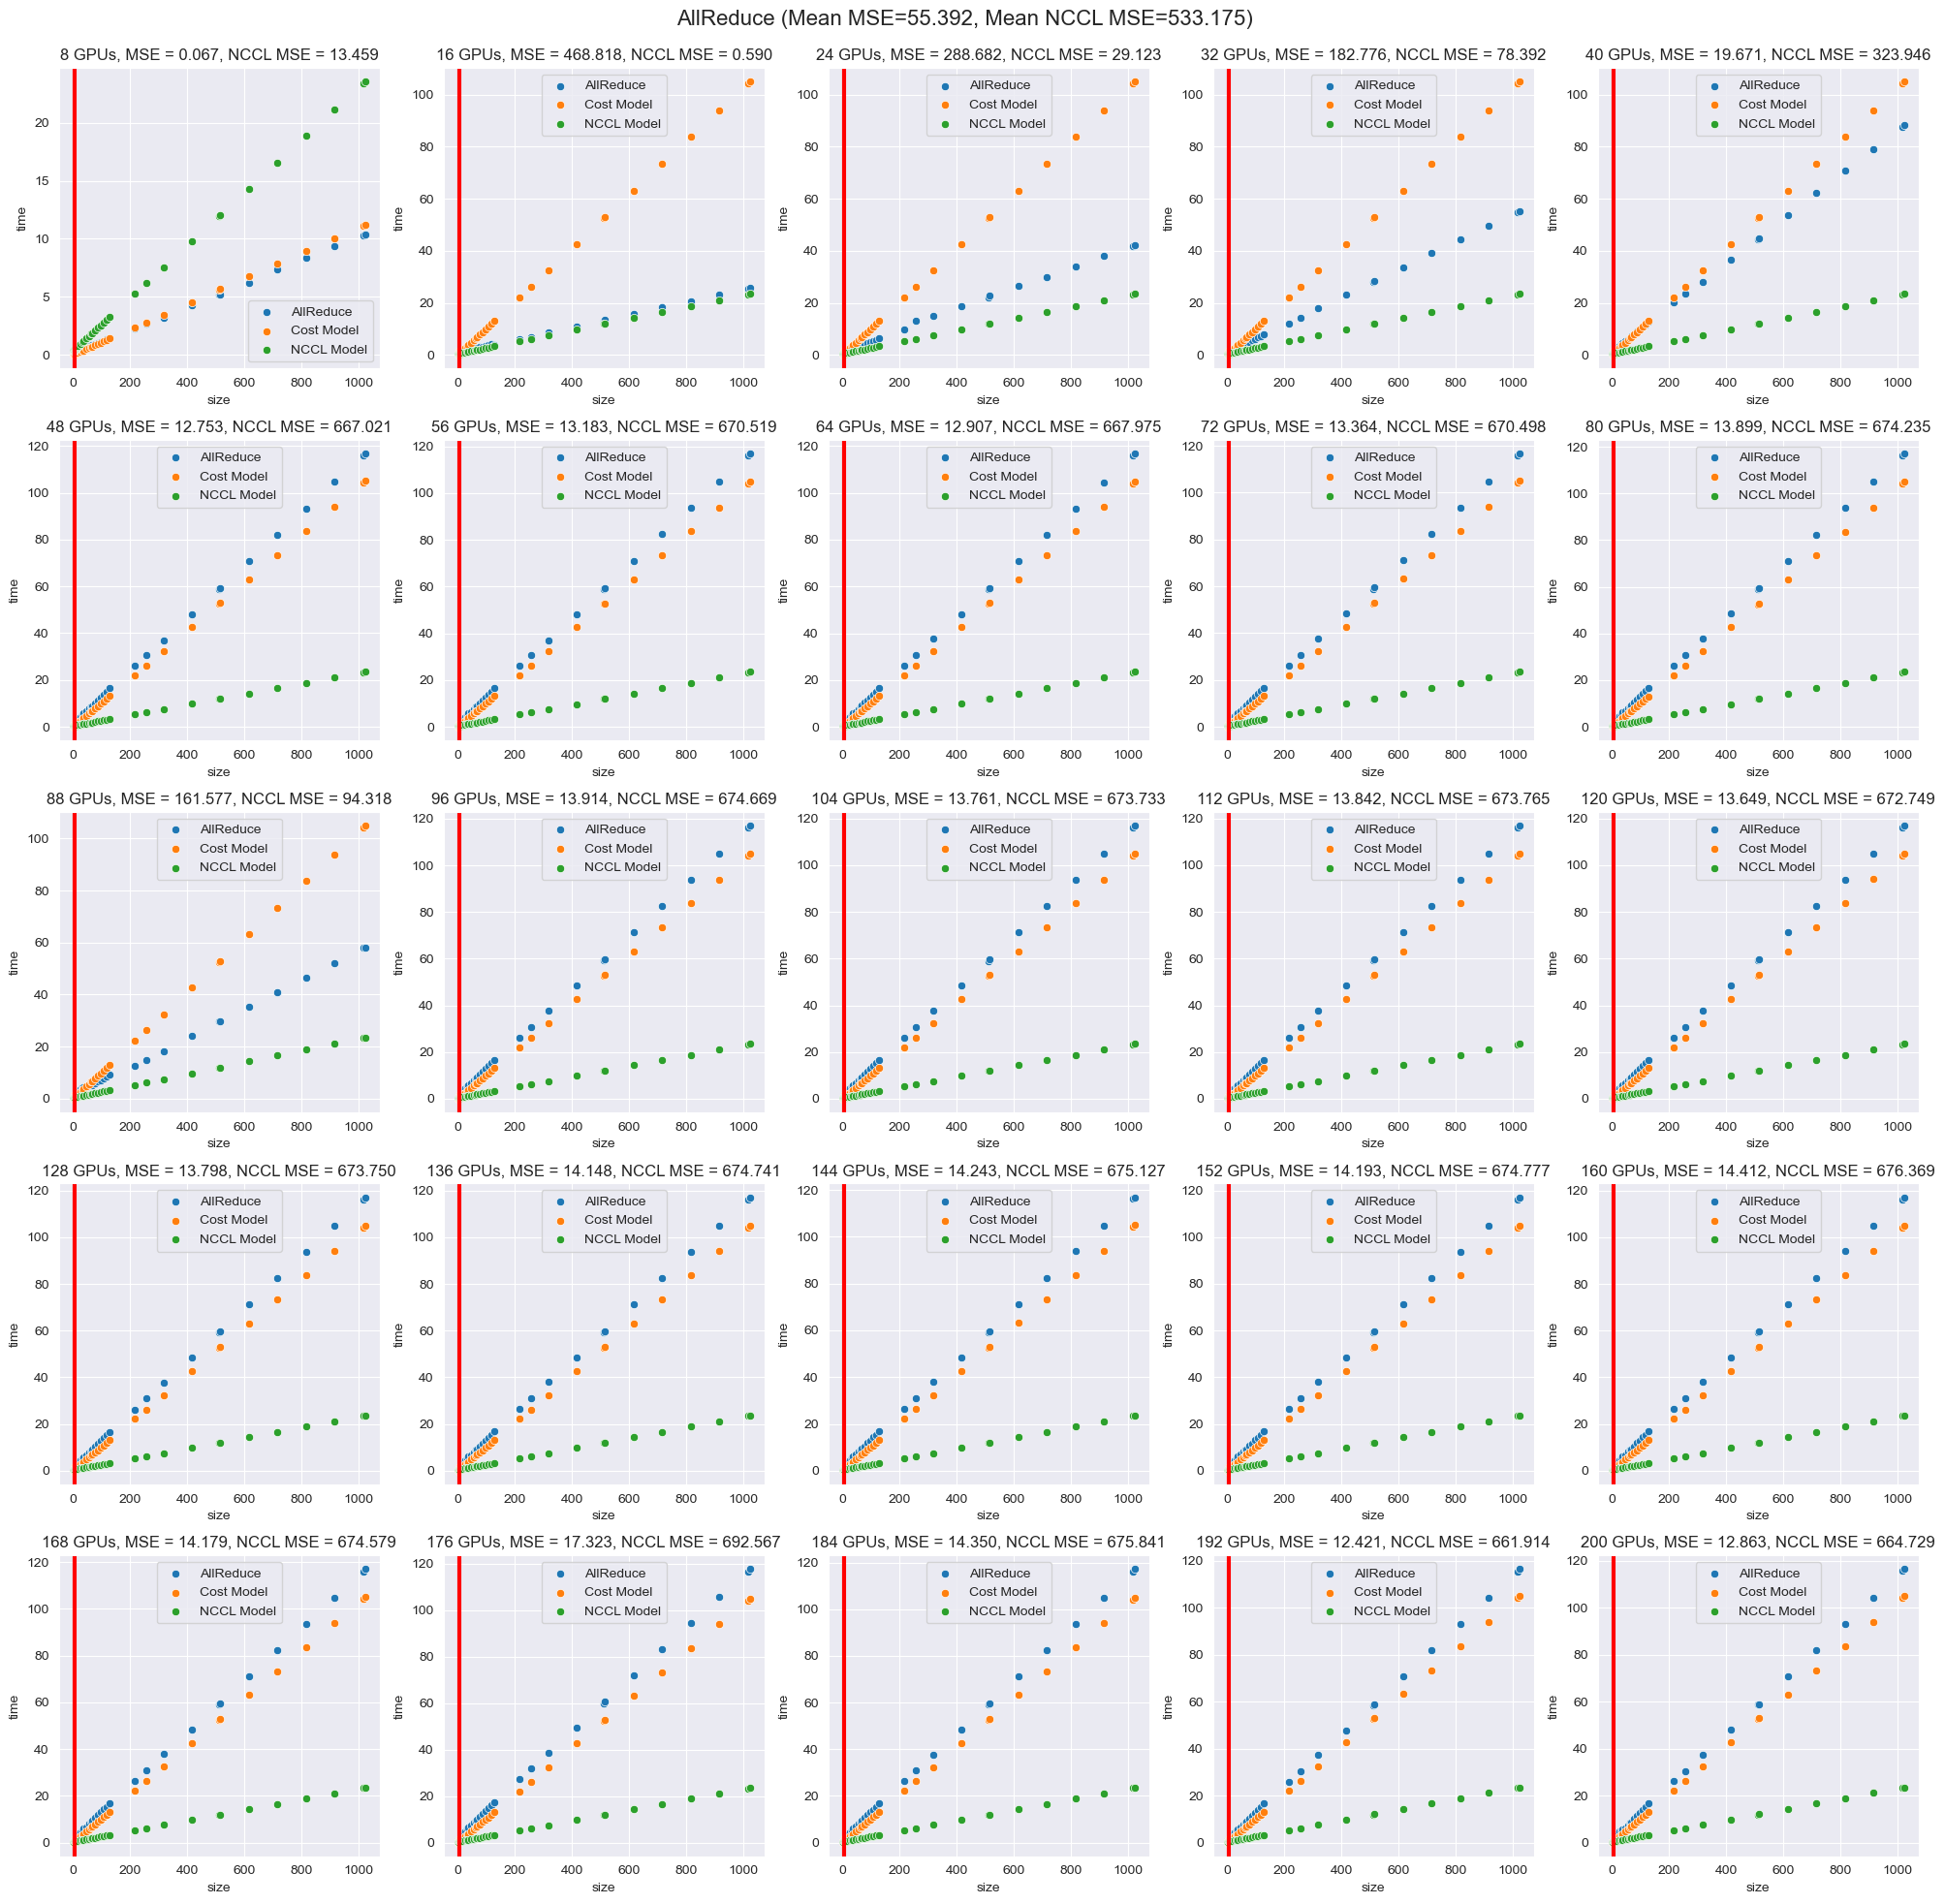

CHUNK SIZE 2
[0.75, 0.75, 5.934210526315789] 53.46945909114363


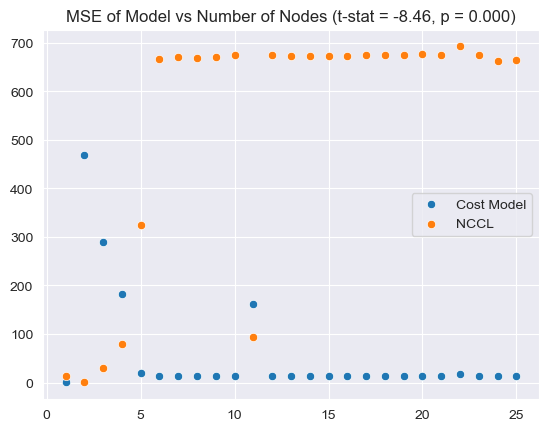

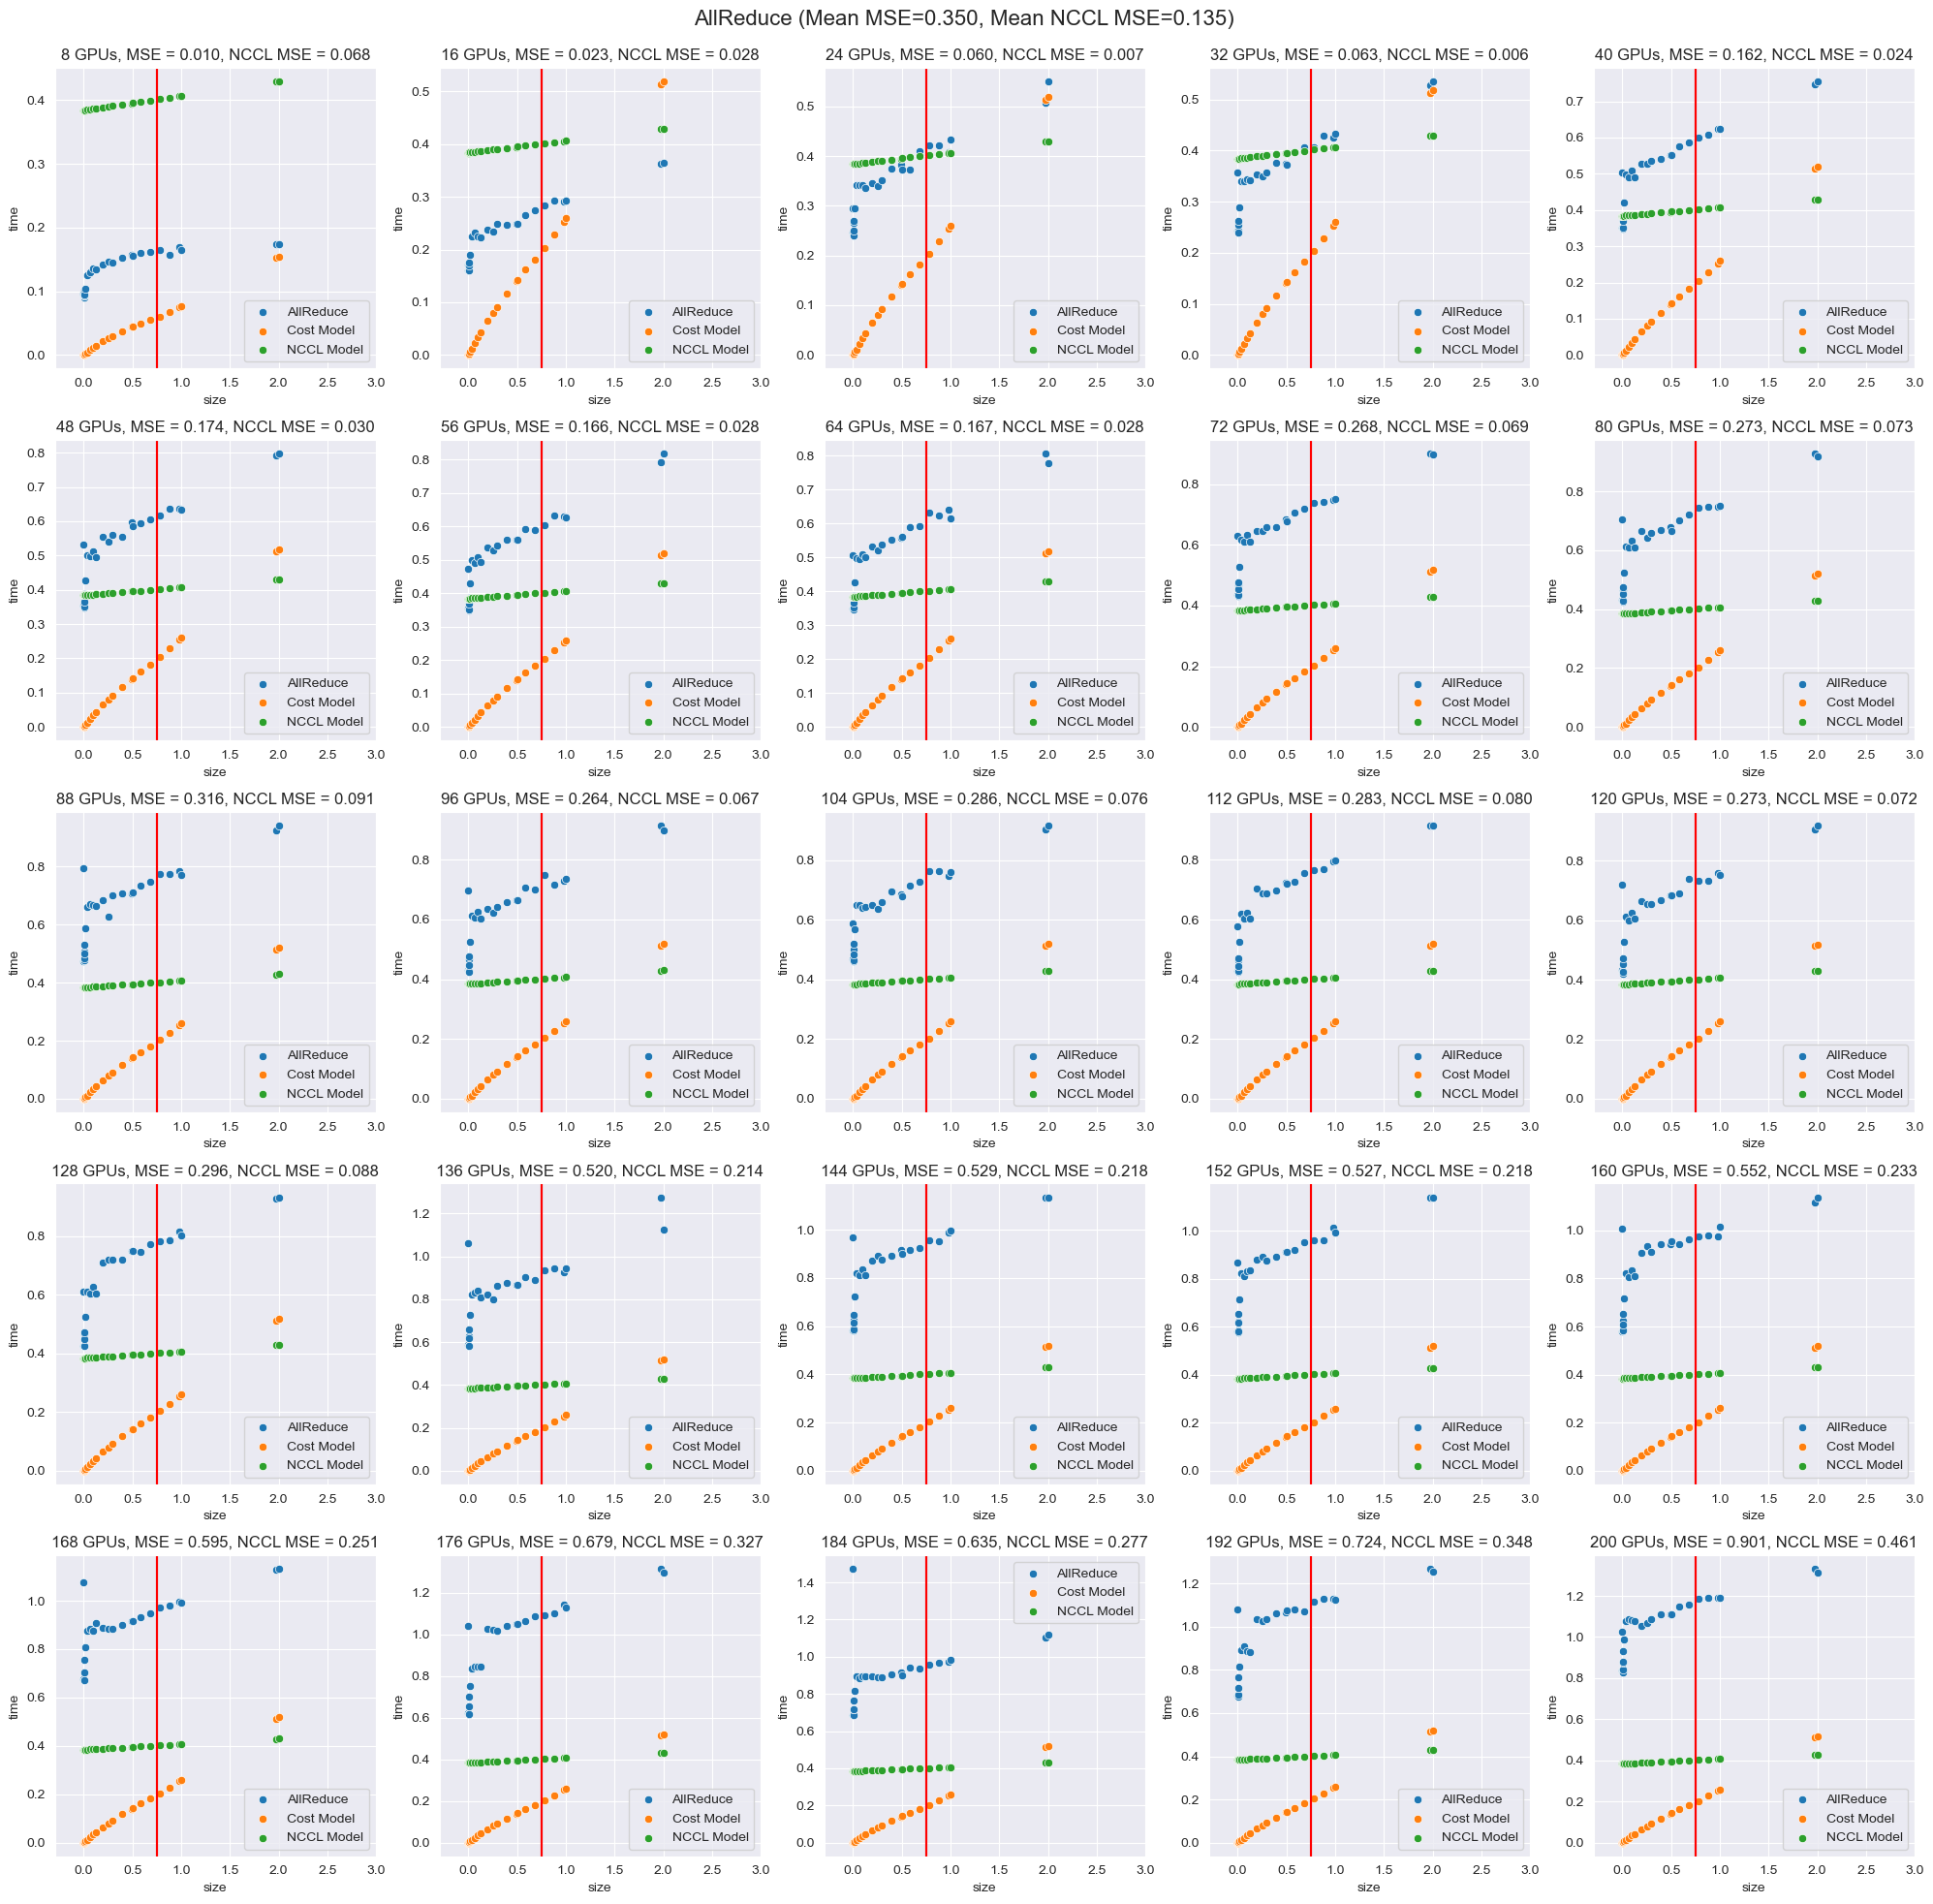

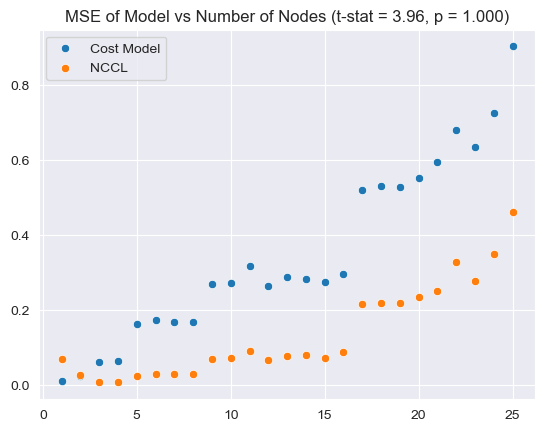

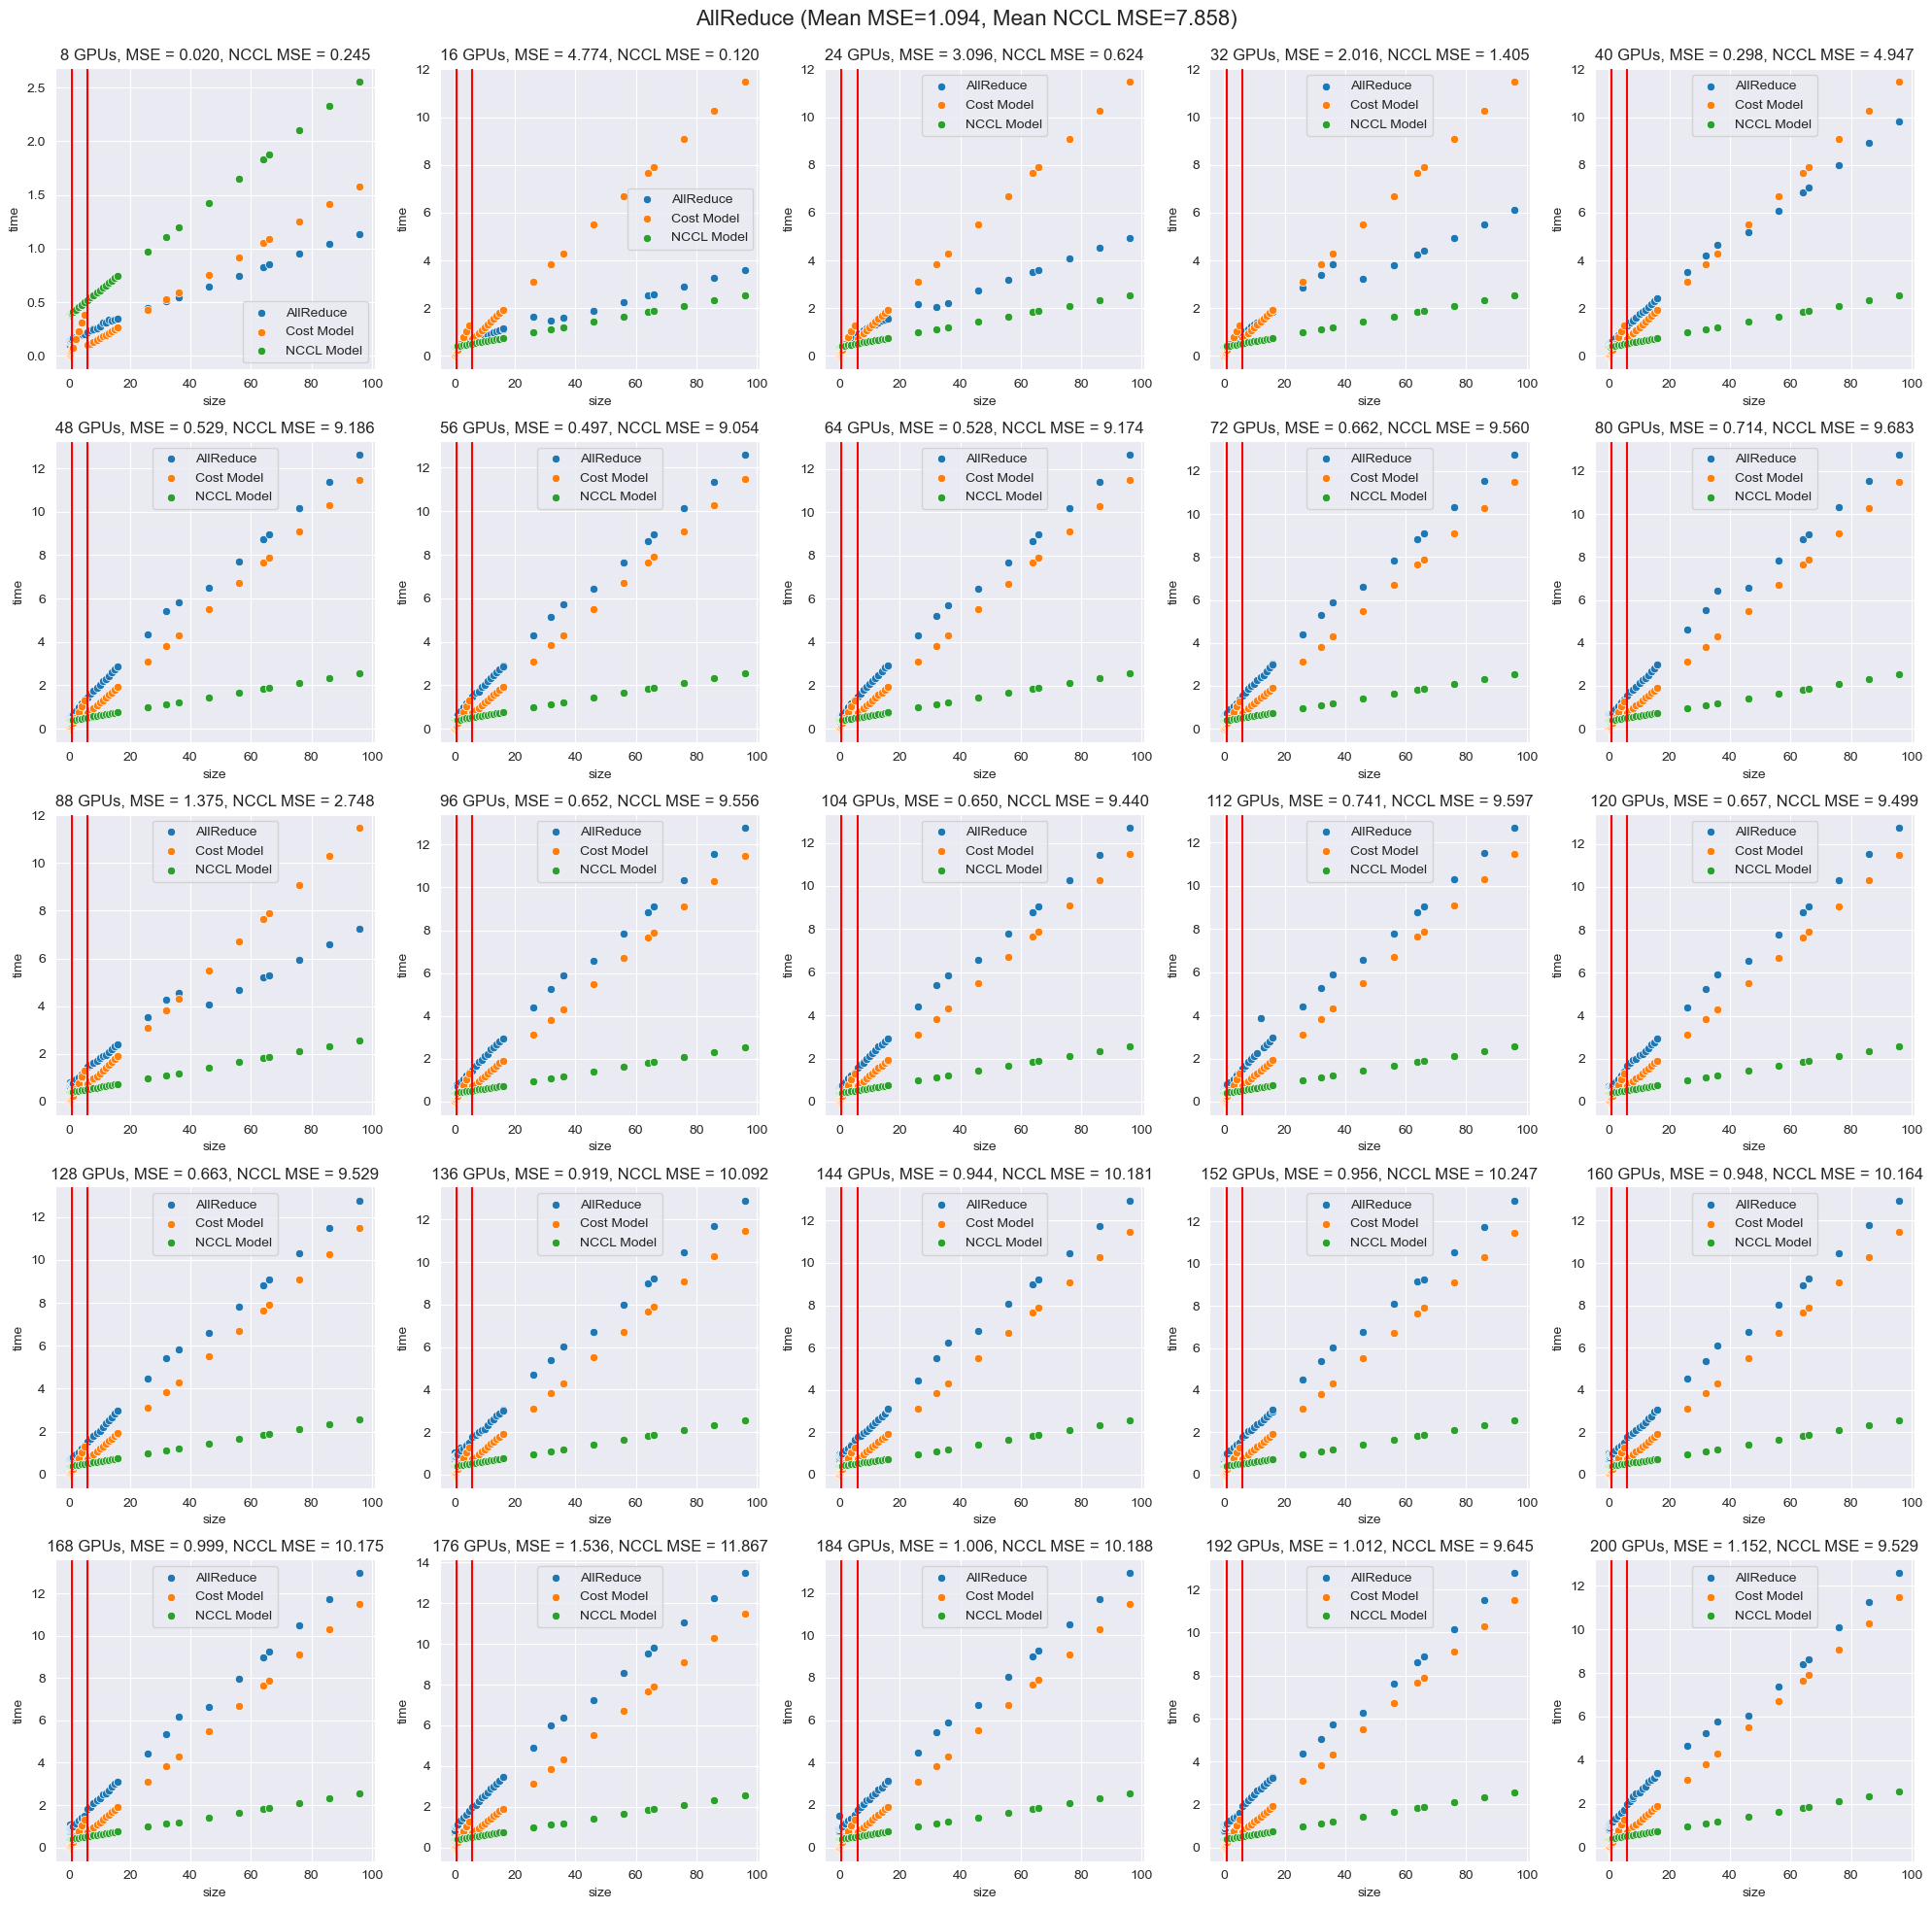

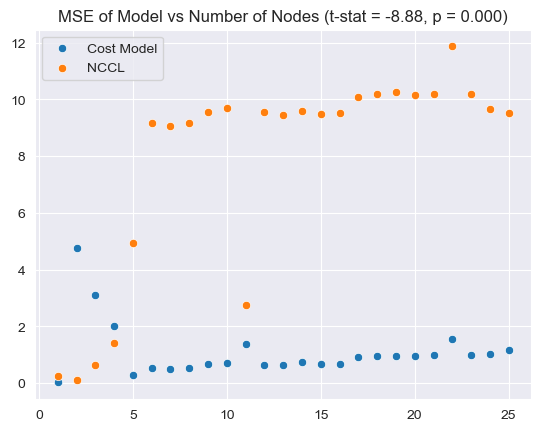

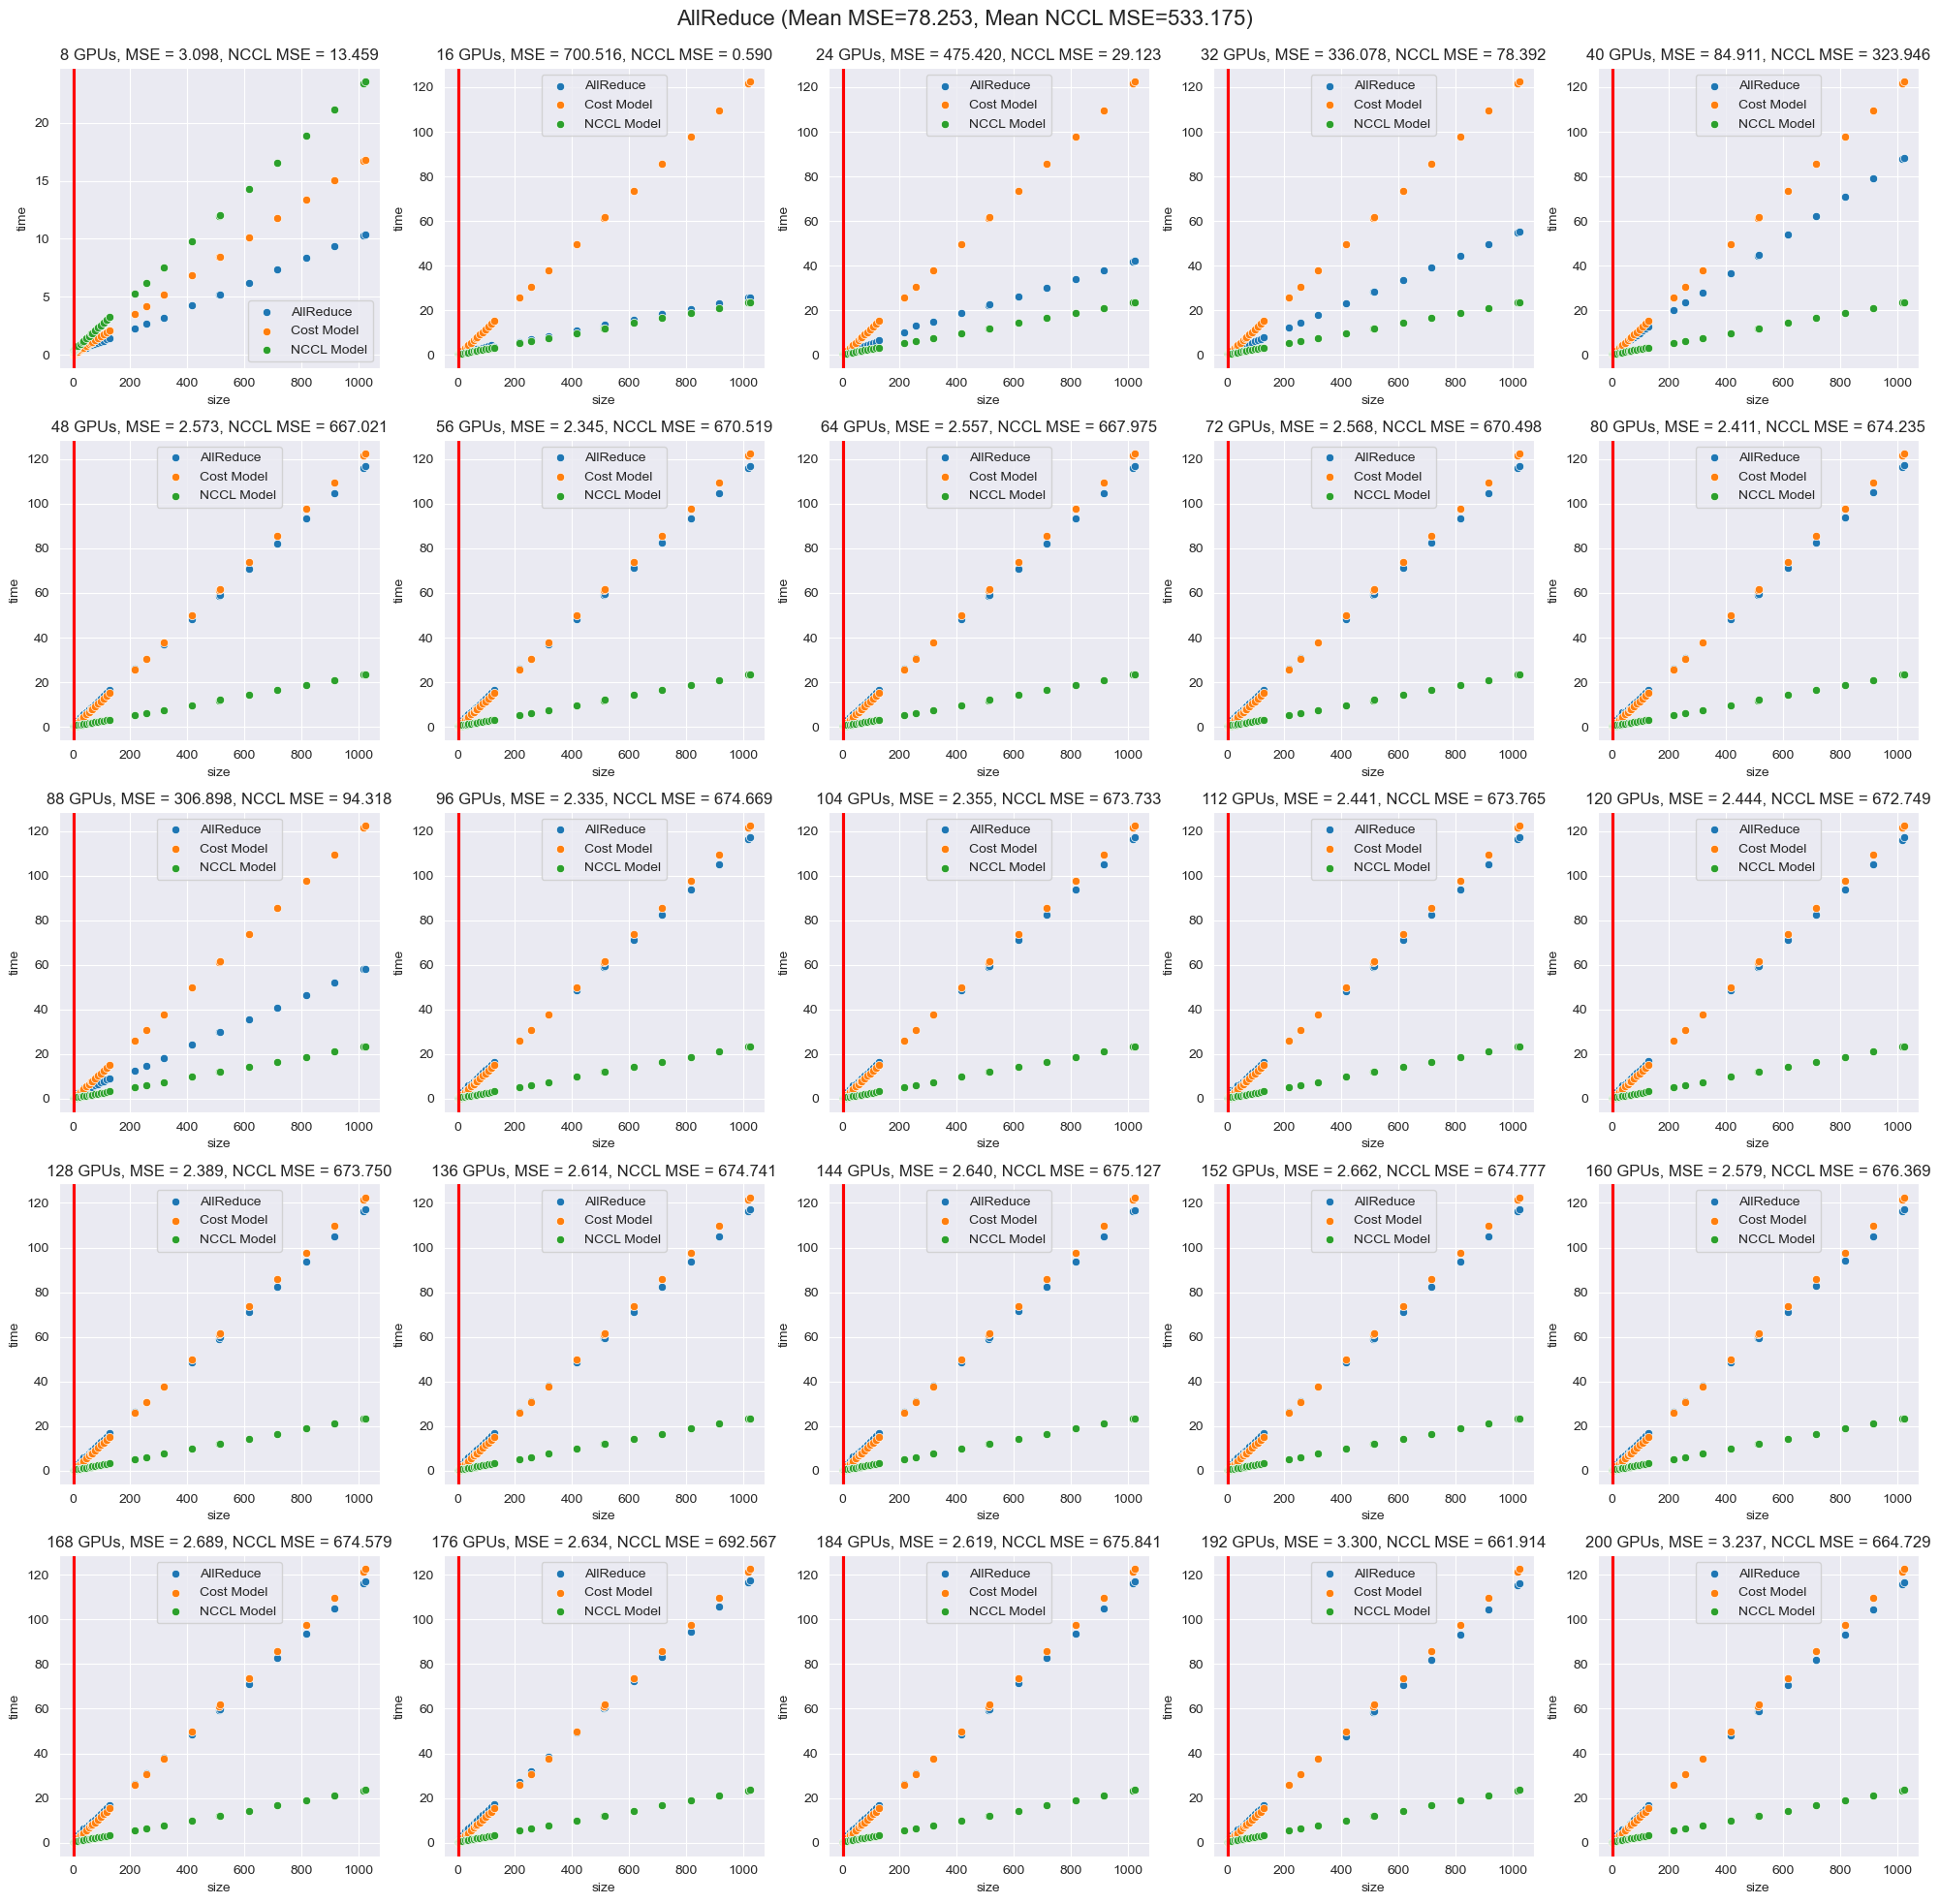

CHUNK SIZE 3
[0.5, 5.631578947368421, 5.631578947368421] 49.57549540815824


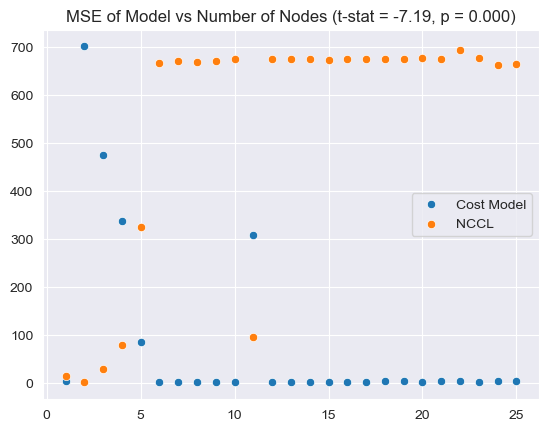

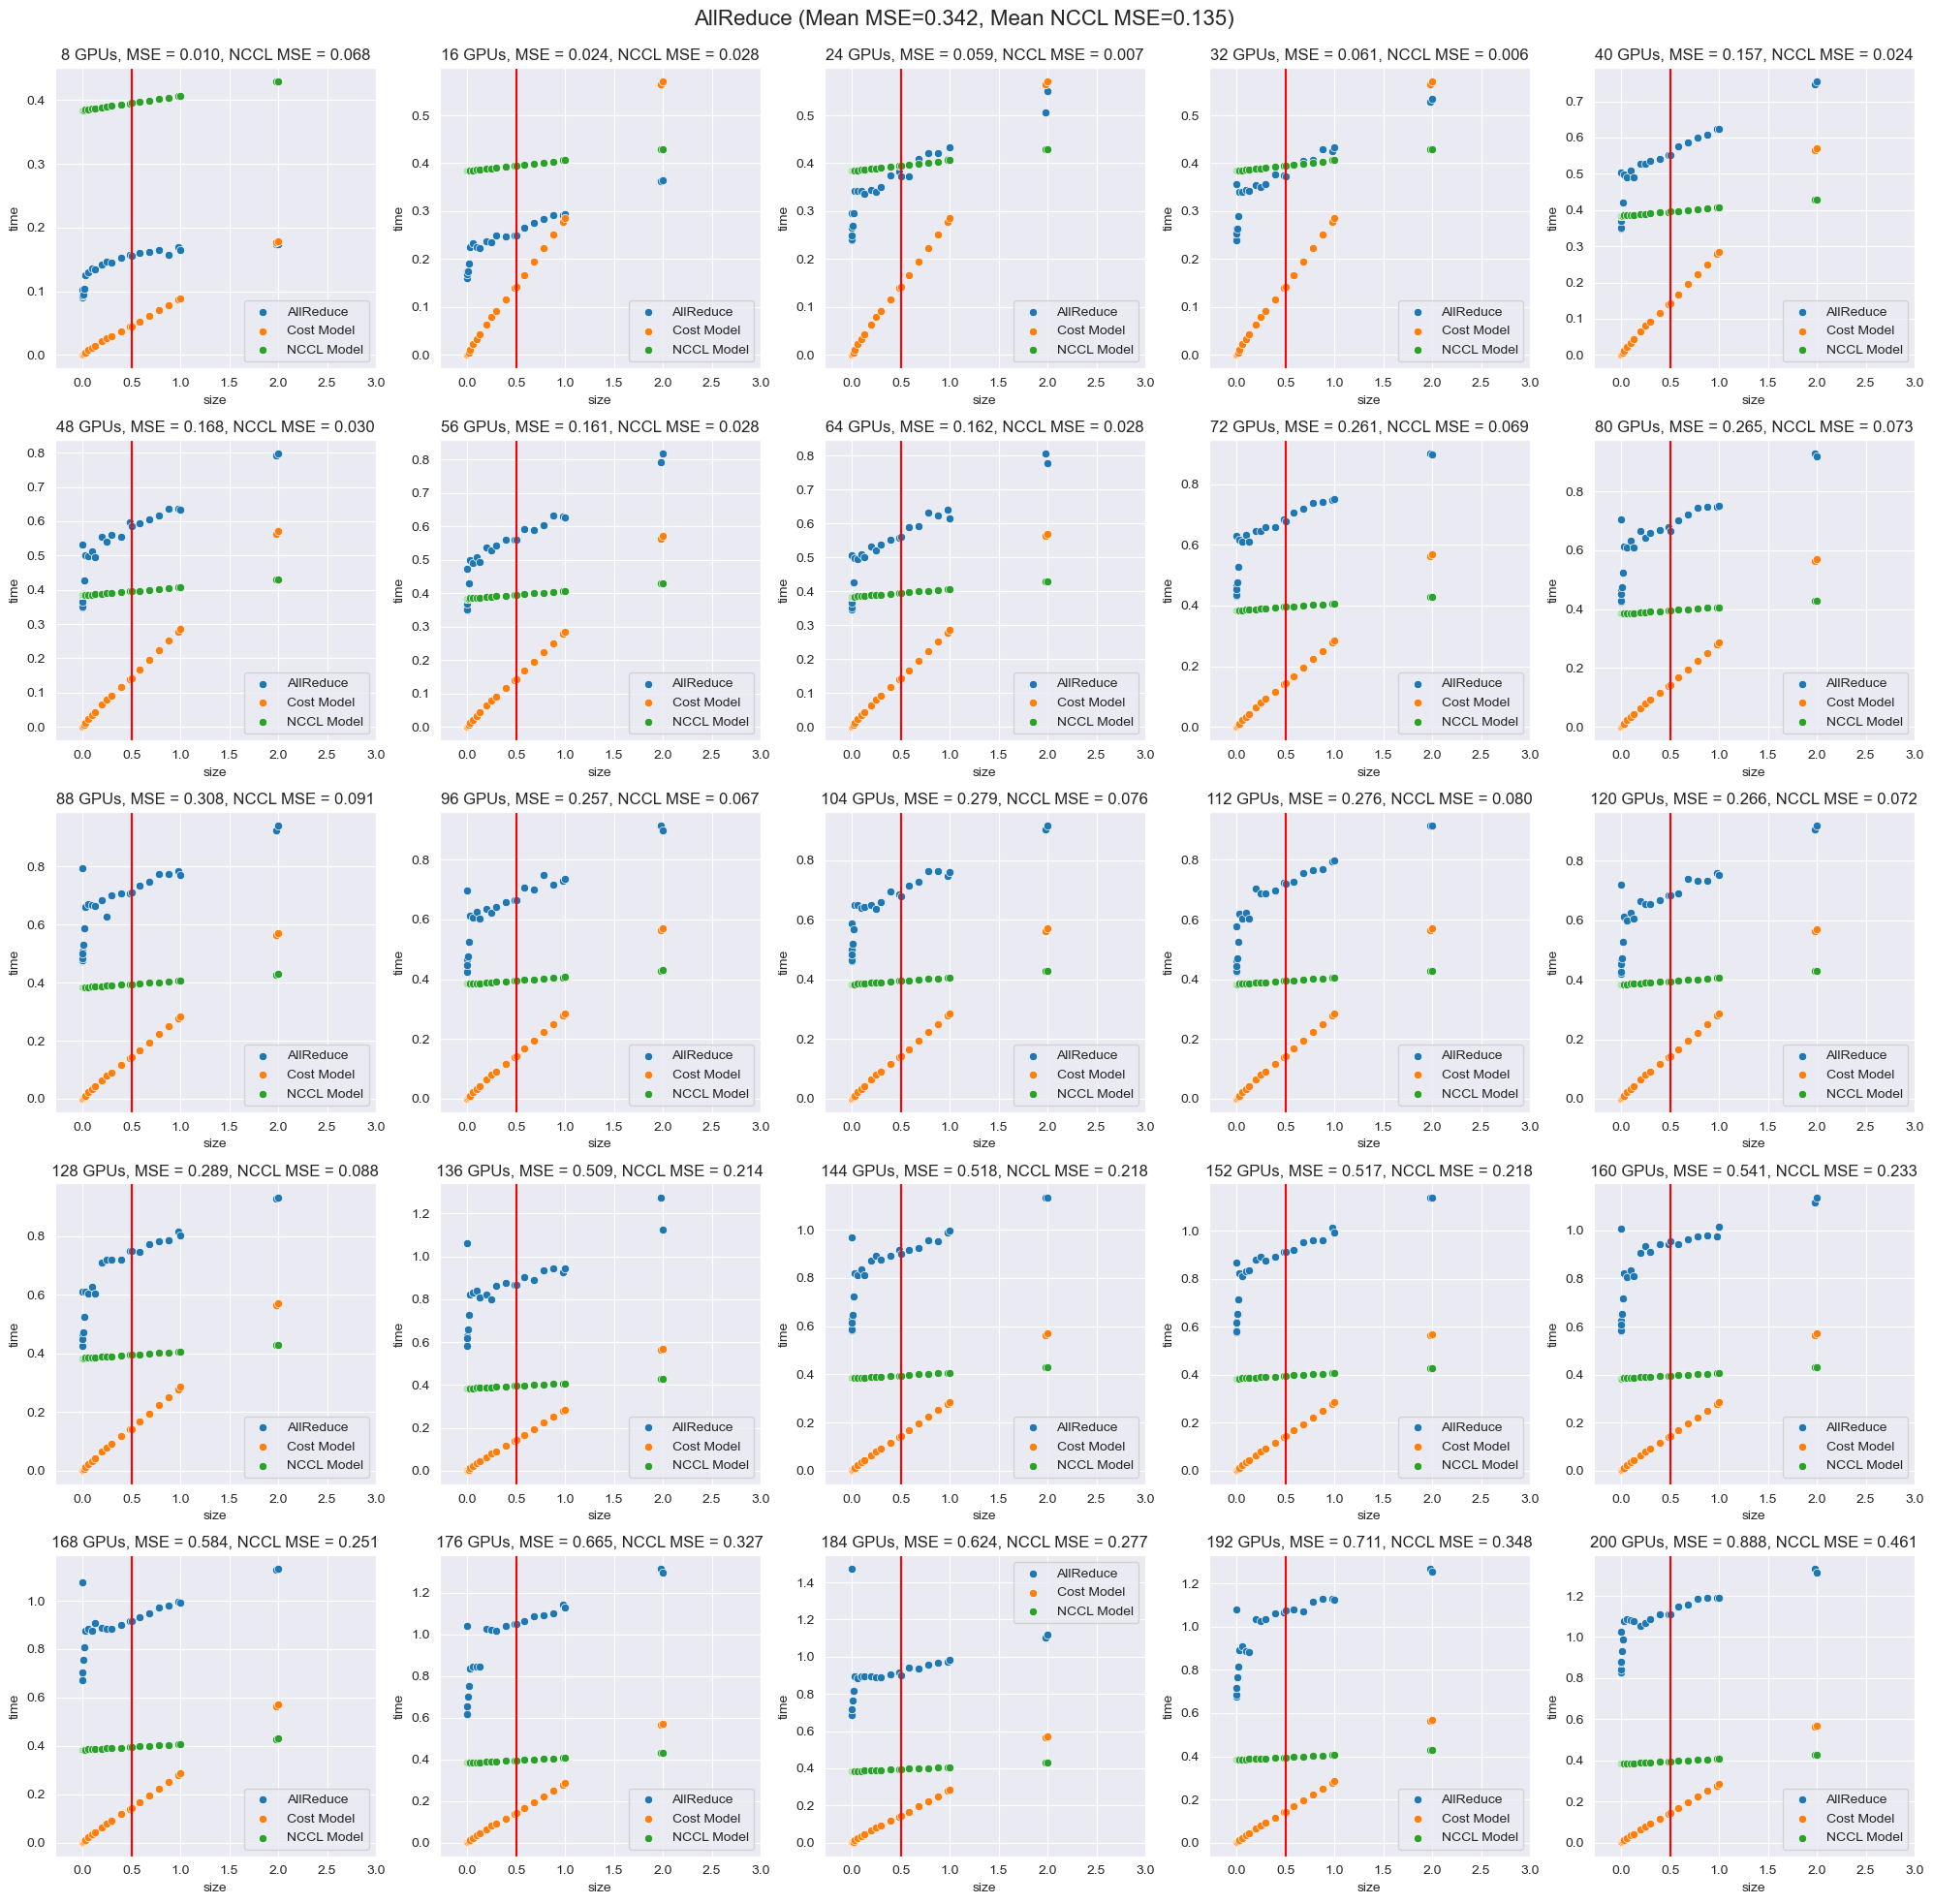

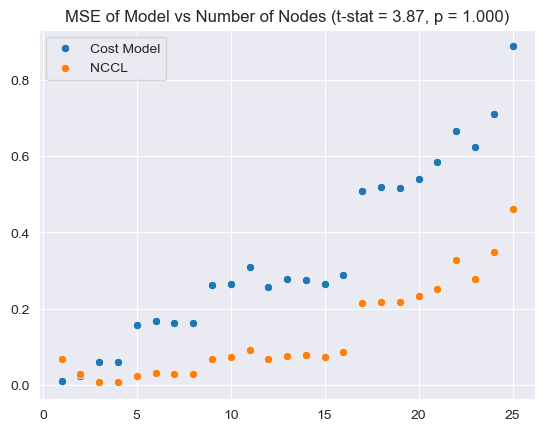

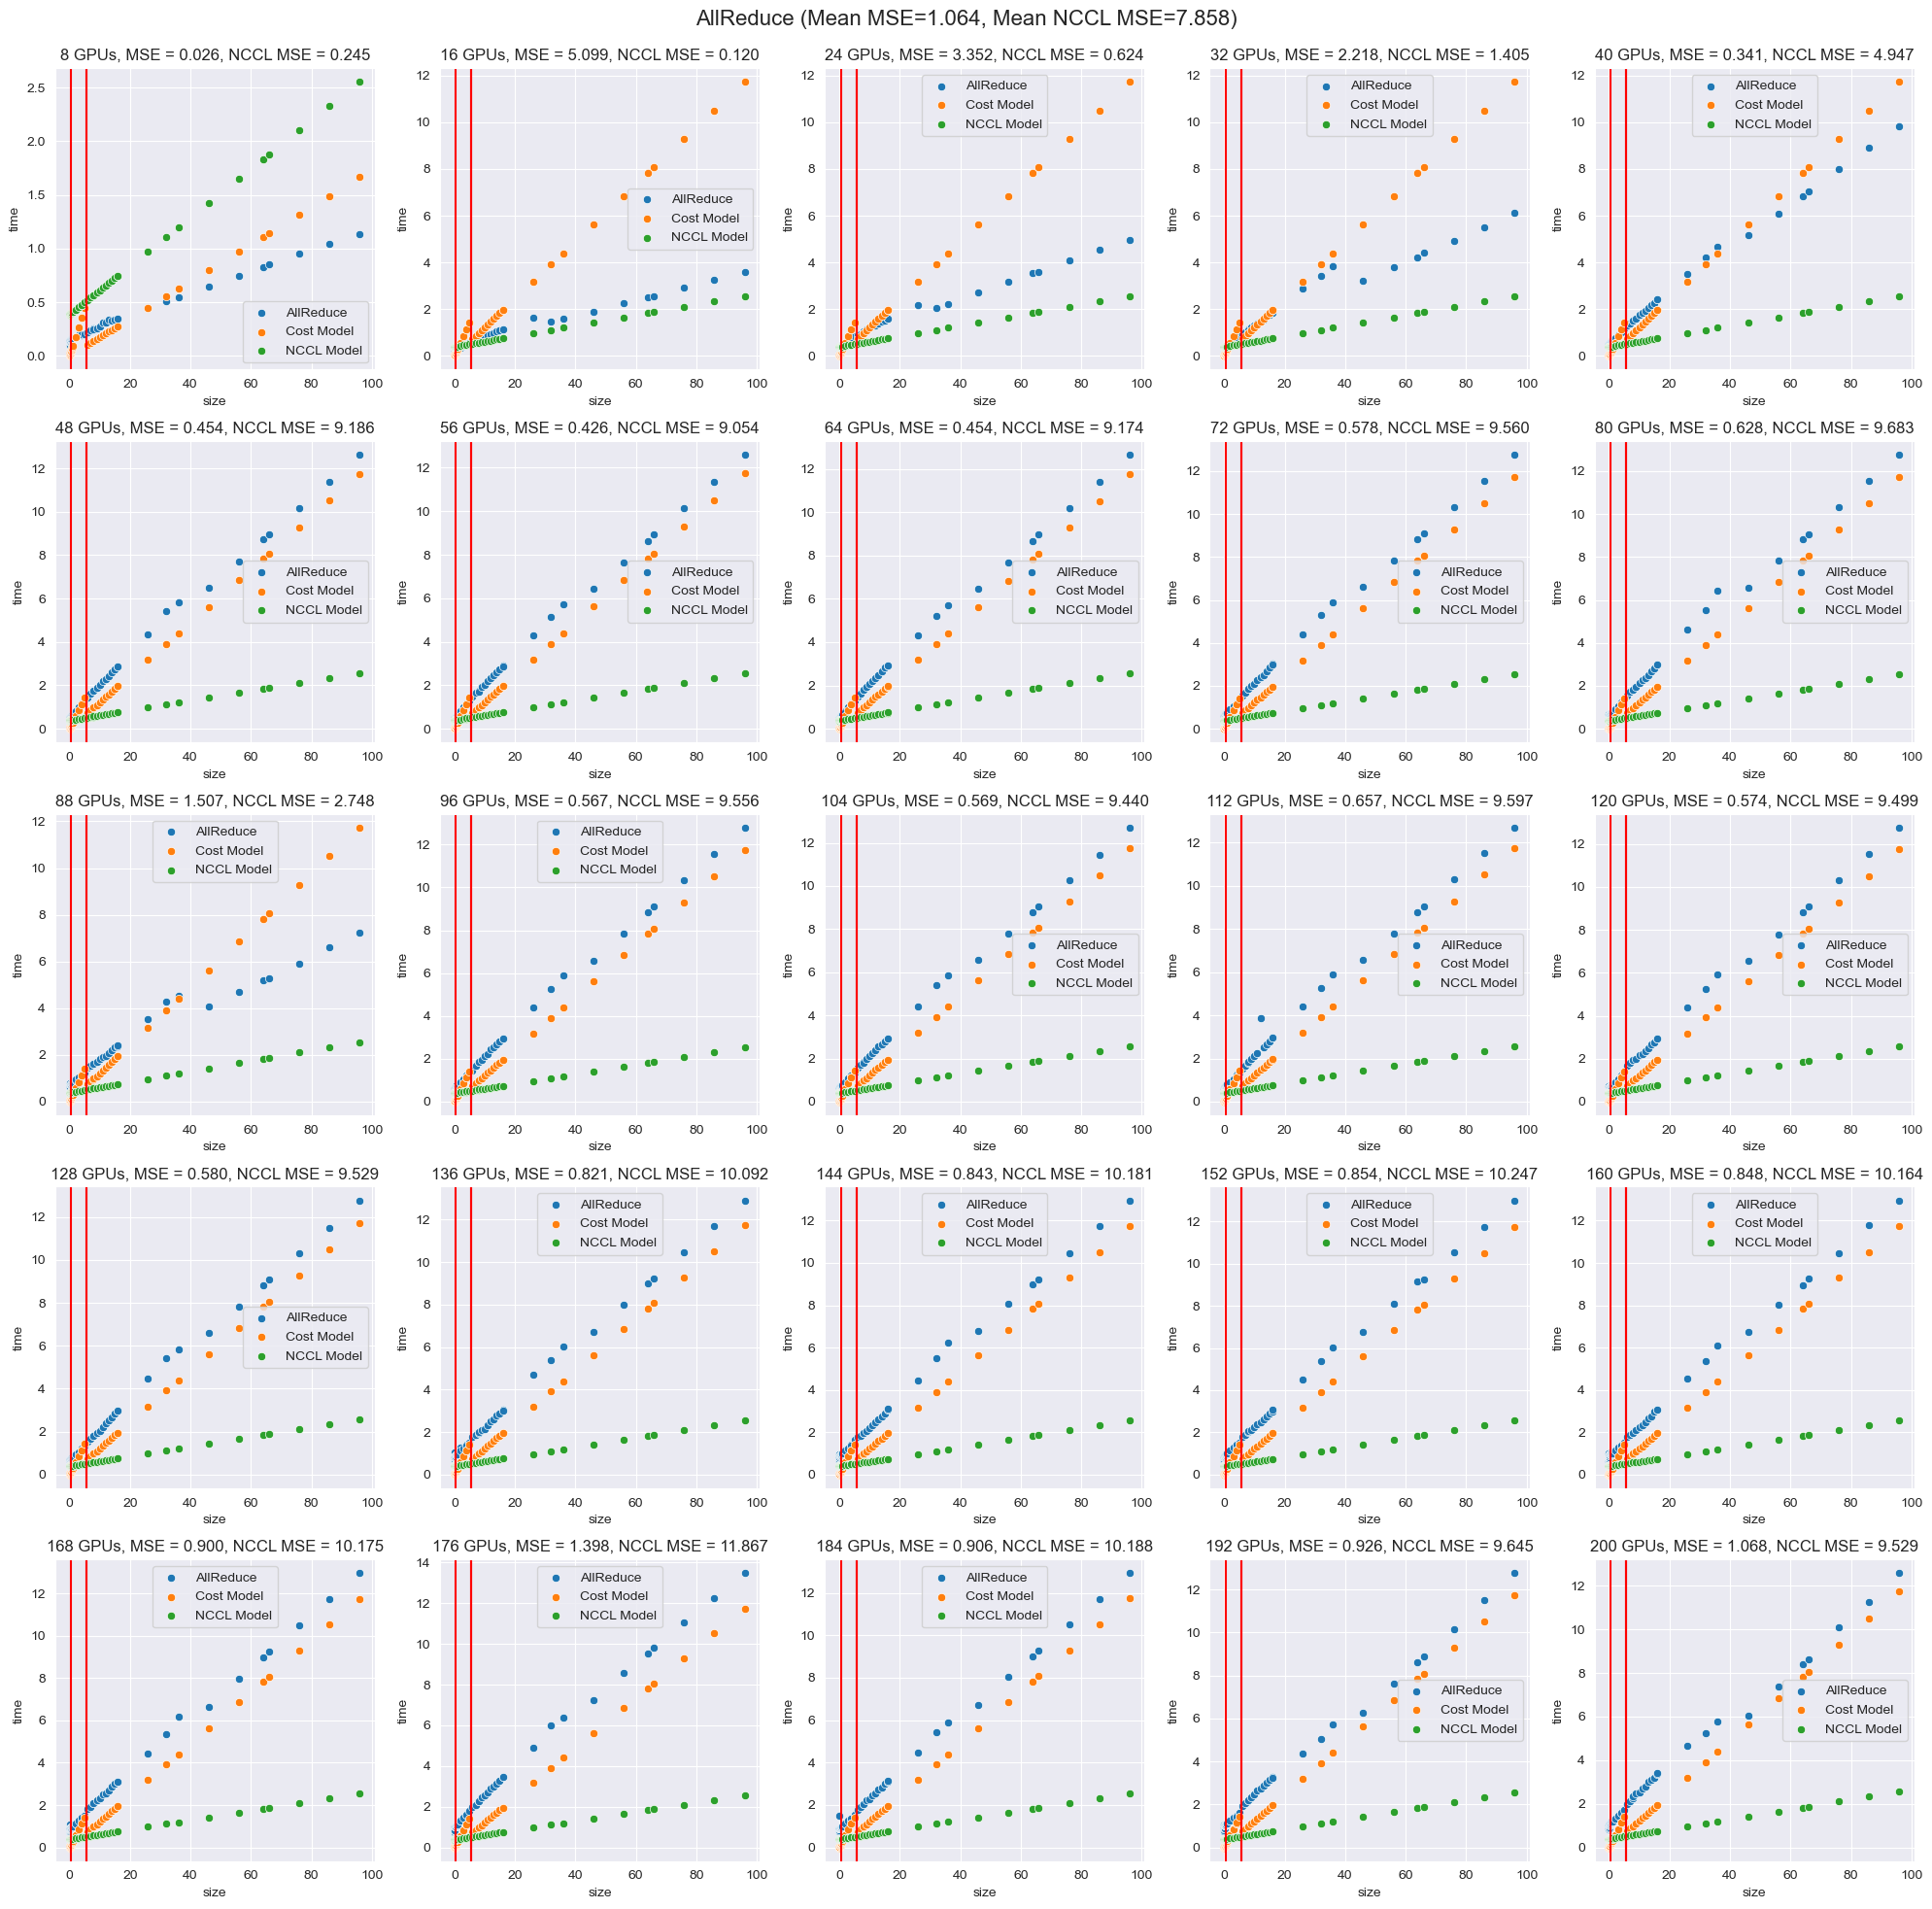

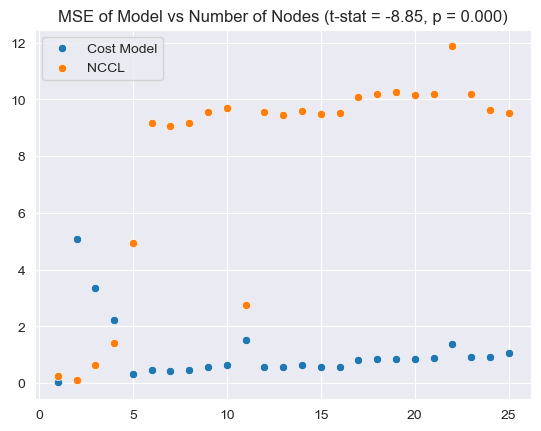

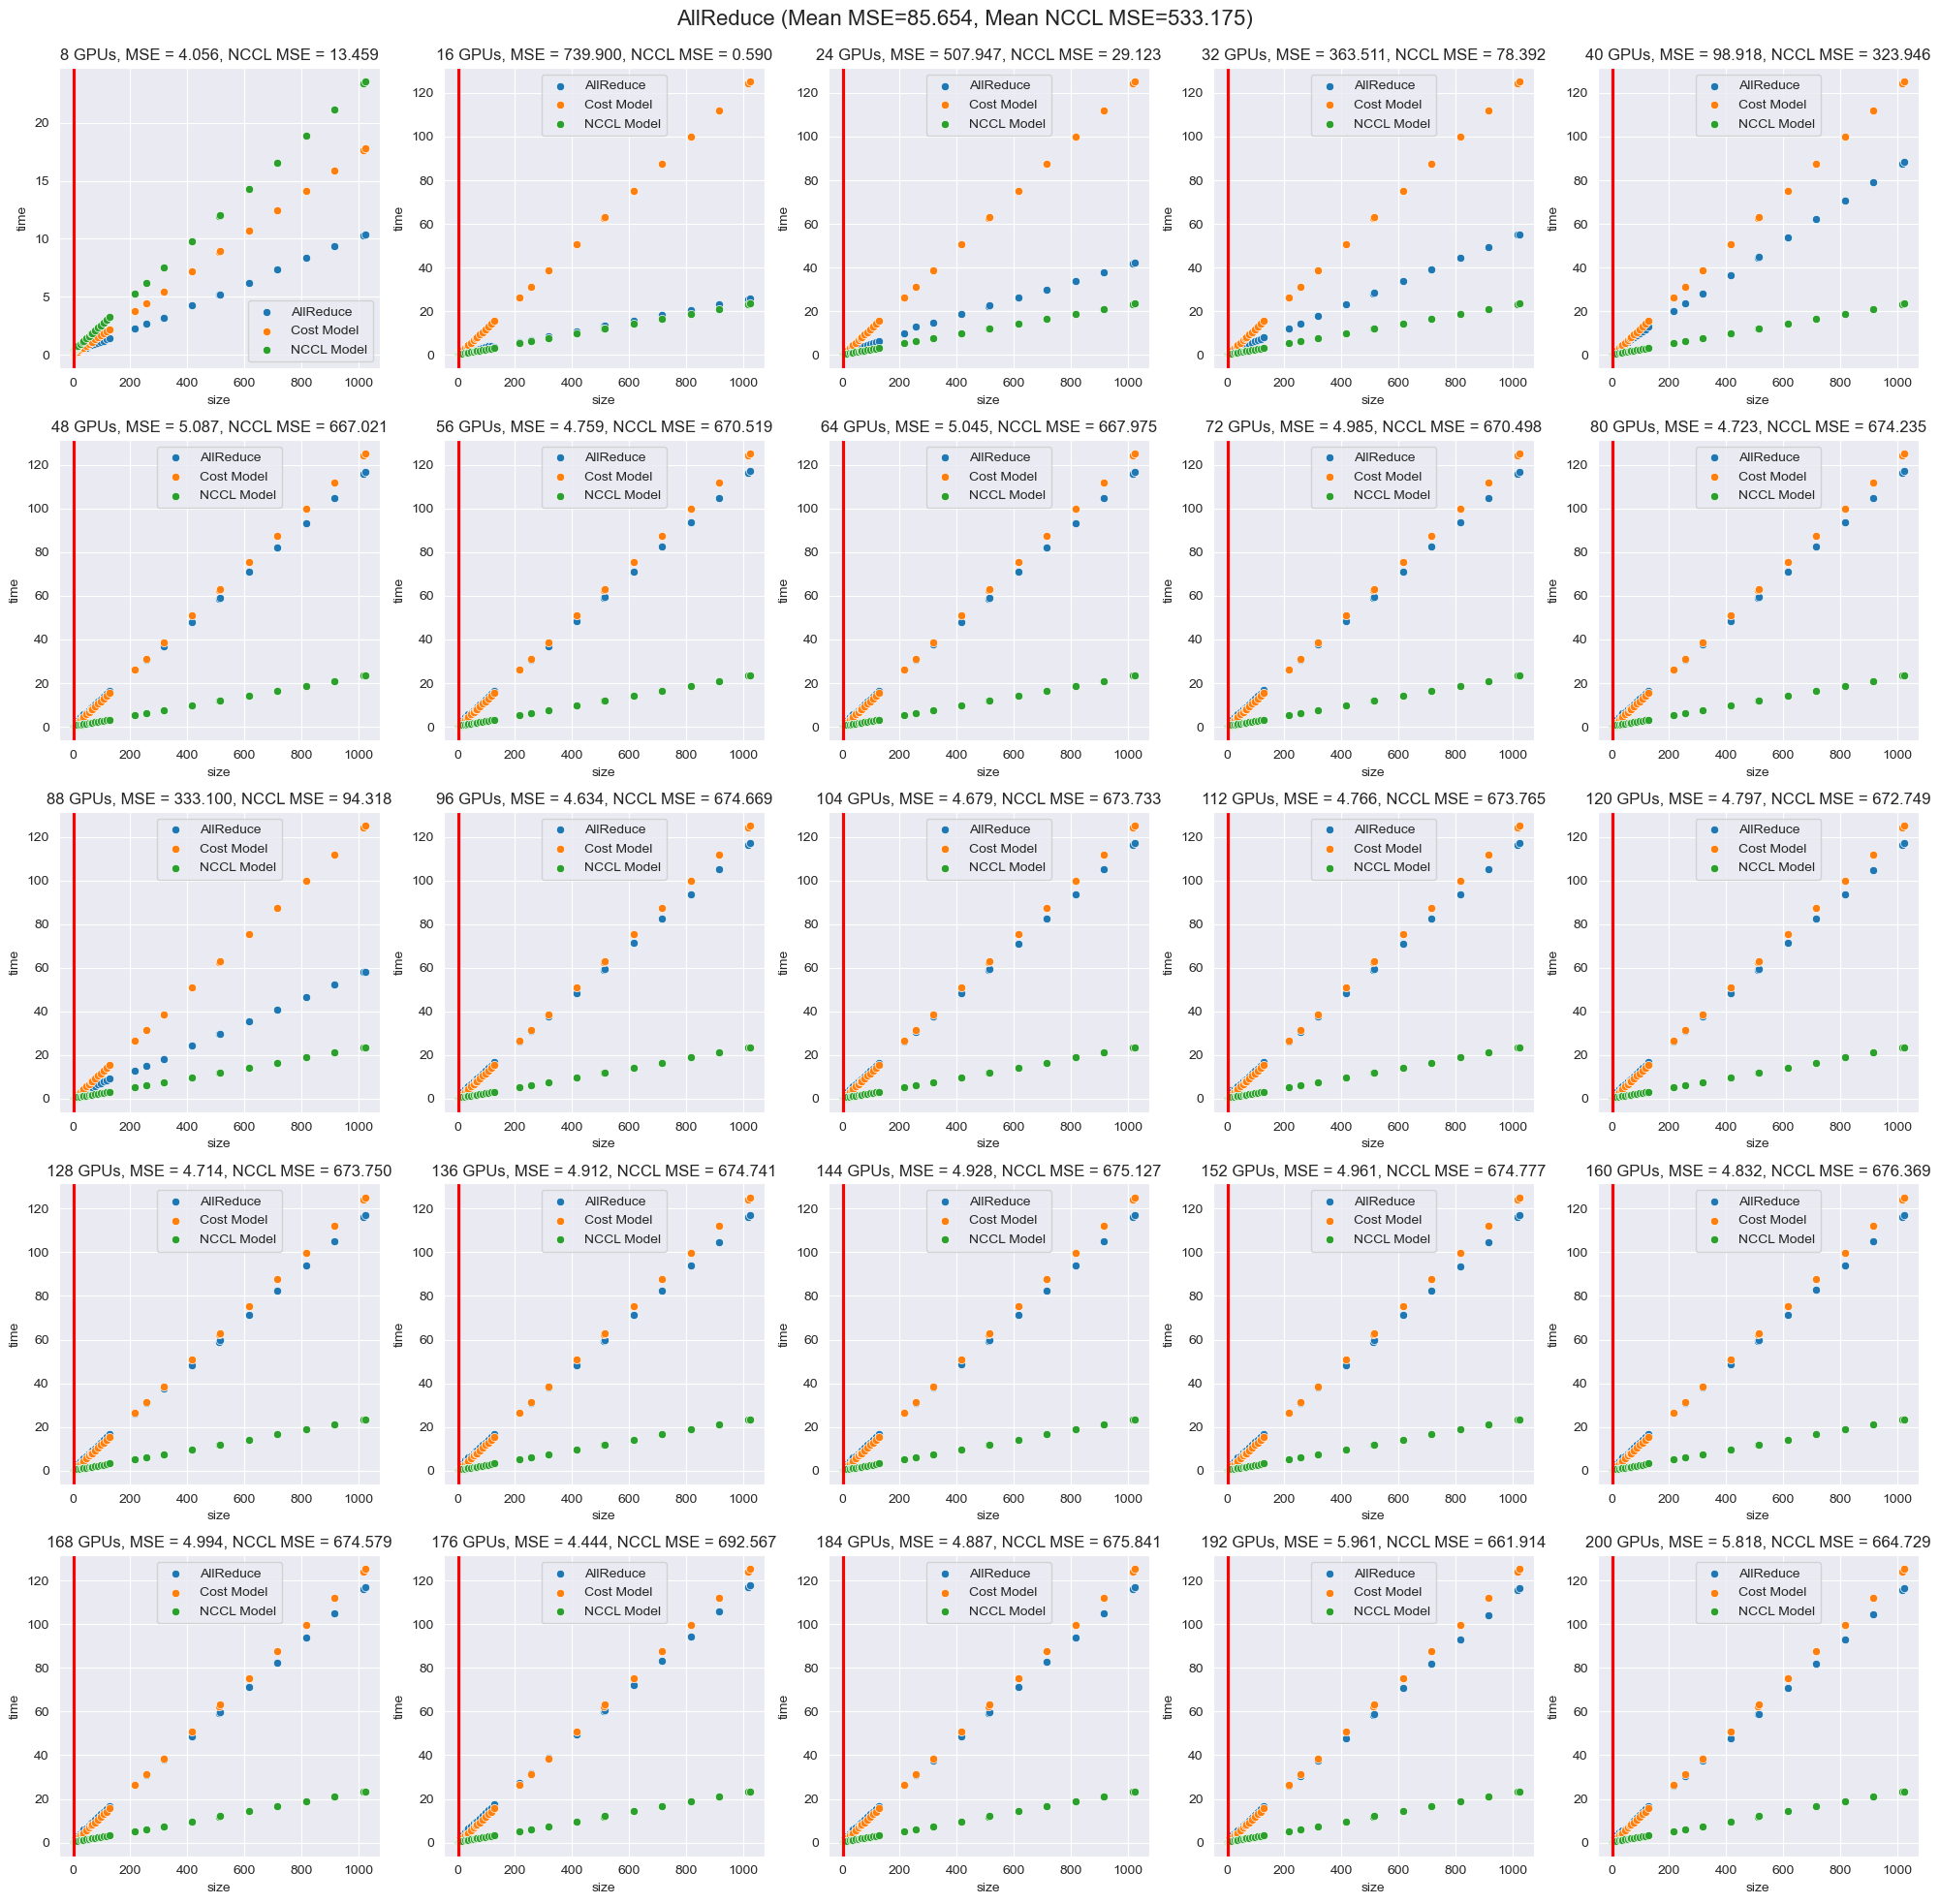

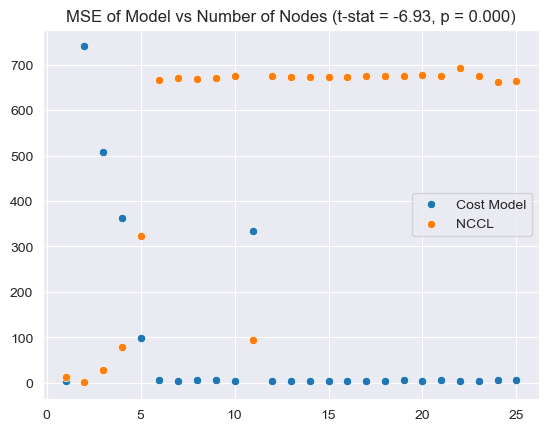

In [ ]:
import multiprocess as mp

for chunk_size in range(1, 4):
    print("CHUNK SIZE", chunk_size)
    with mp.Pool(10) as pool:
        results = pool.map(
            (lambda x: all_reduce_total_error(lower_lim=None, upper_lim=100, thresholds=x, chunk_size=chunk_size)), threshold_space
        )
        
        print(threshold_space[np.argmin(results)], min(results))
        for lim in [2, 100, None]:
            plot_allreduce(upper_lim=lim, thresholds=threshold_space[np.argmin(results)])

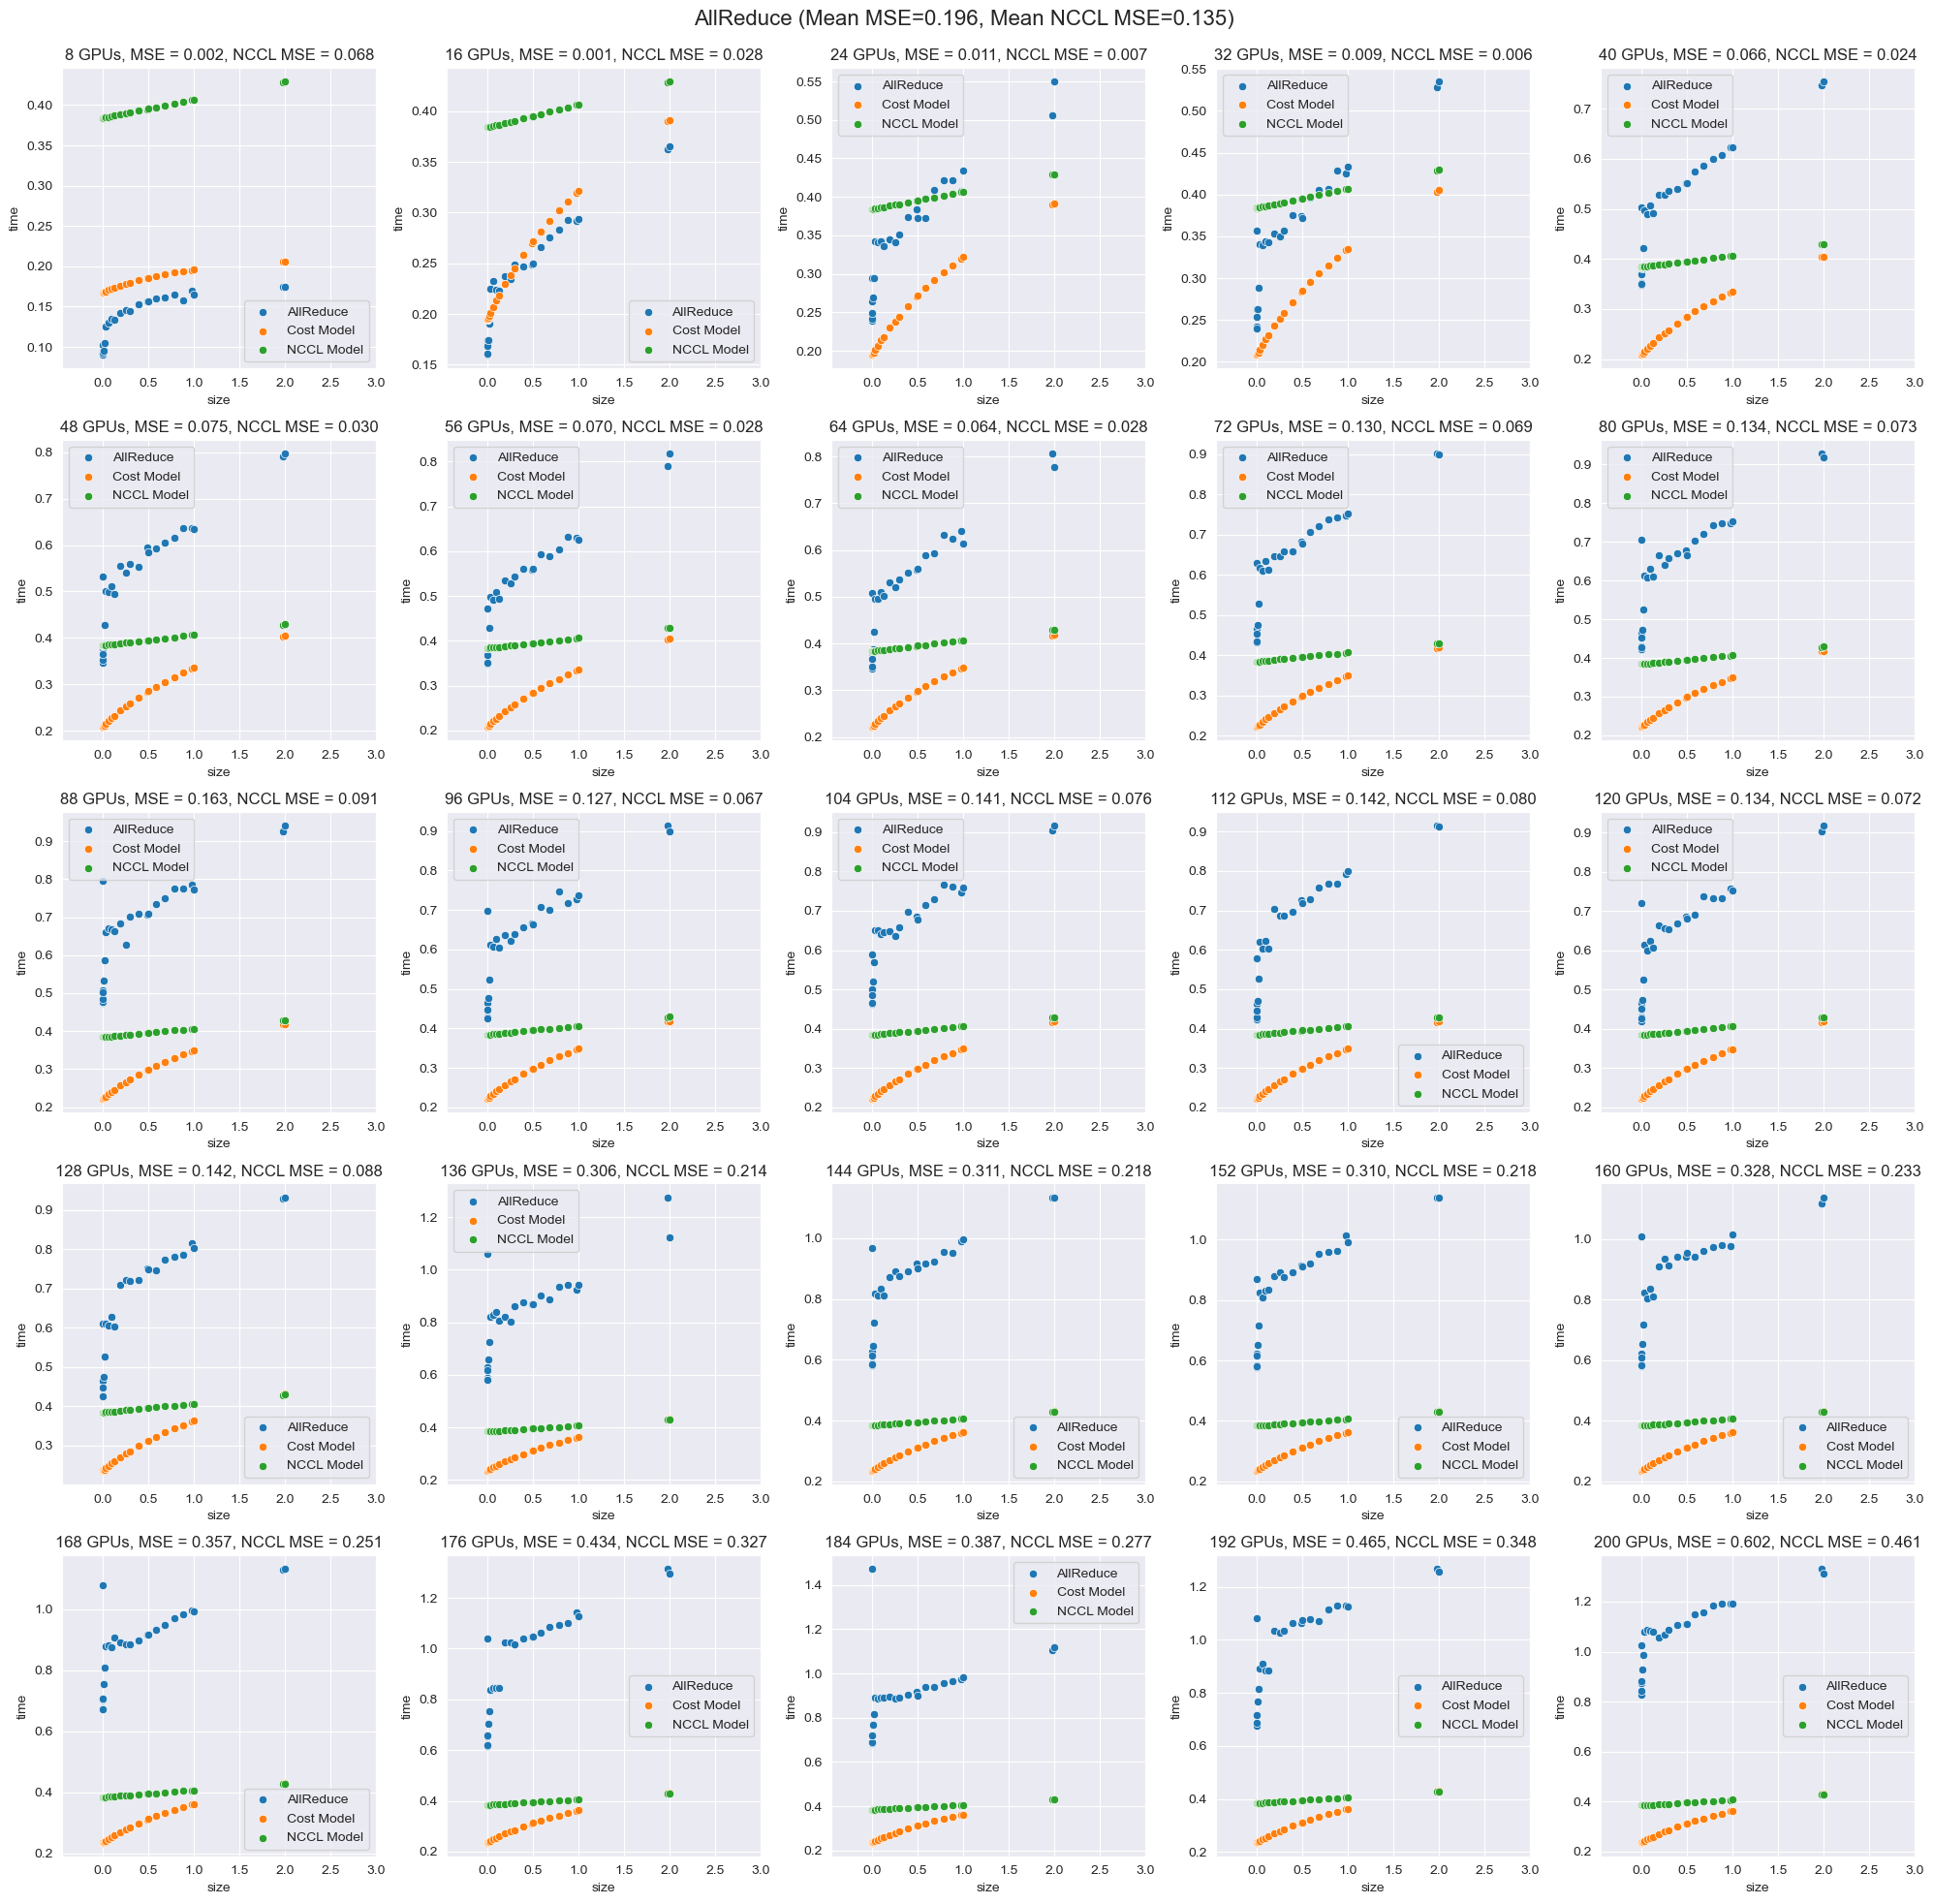

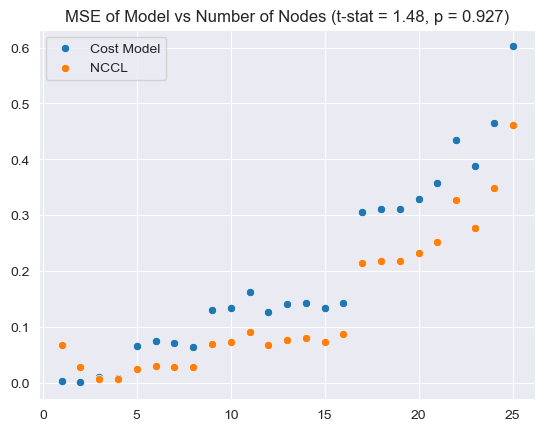

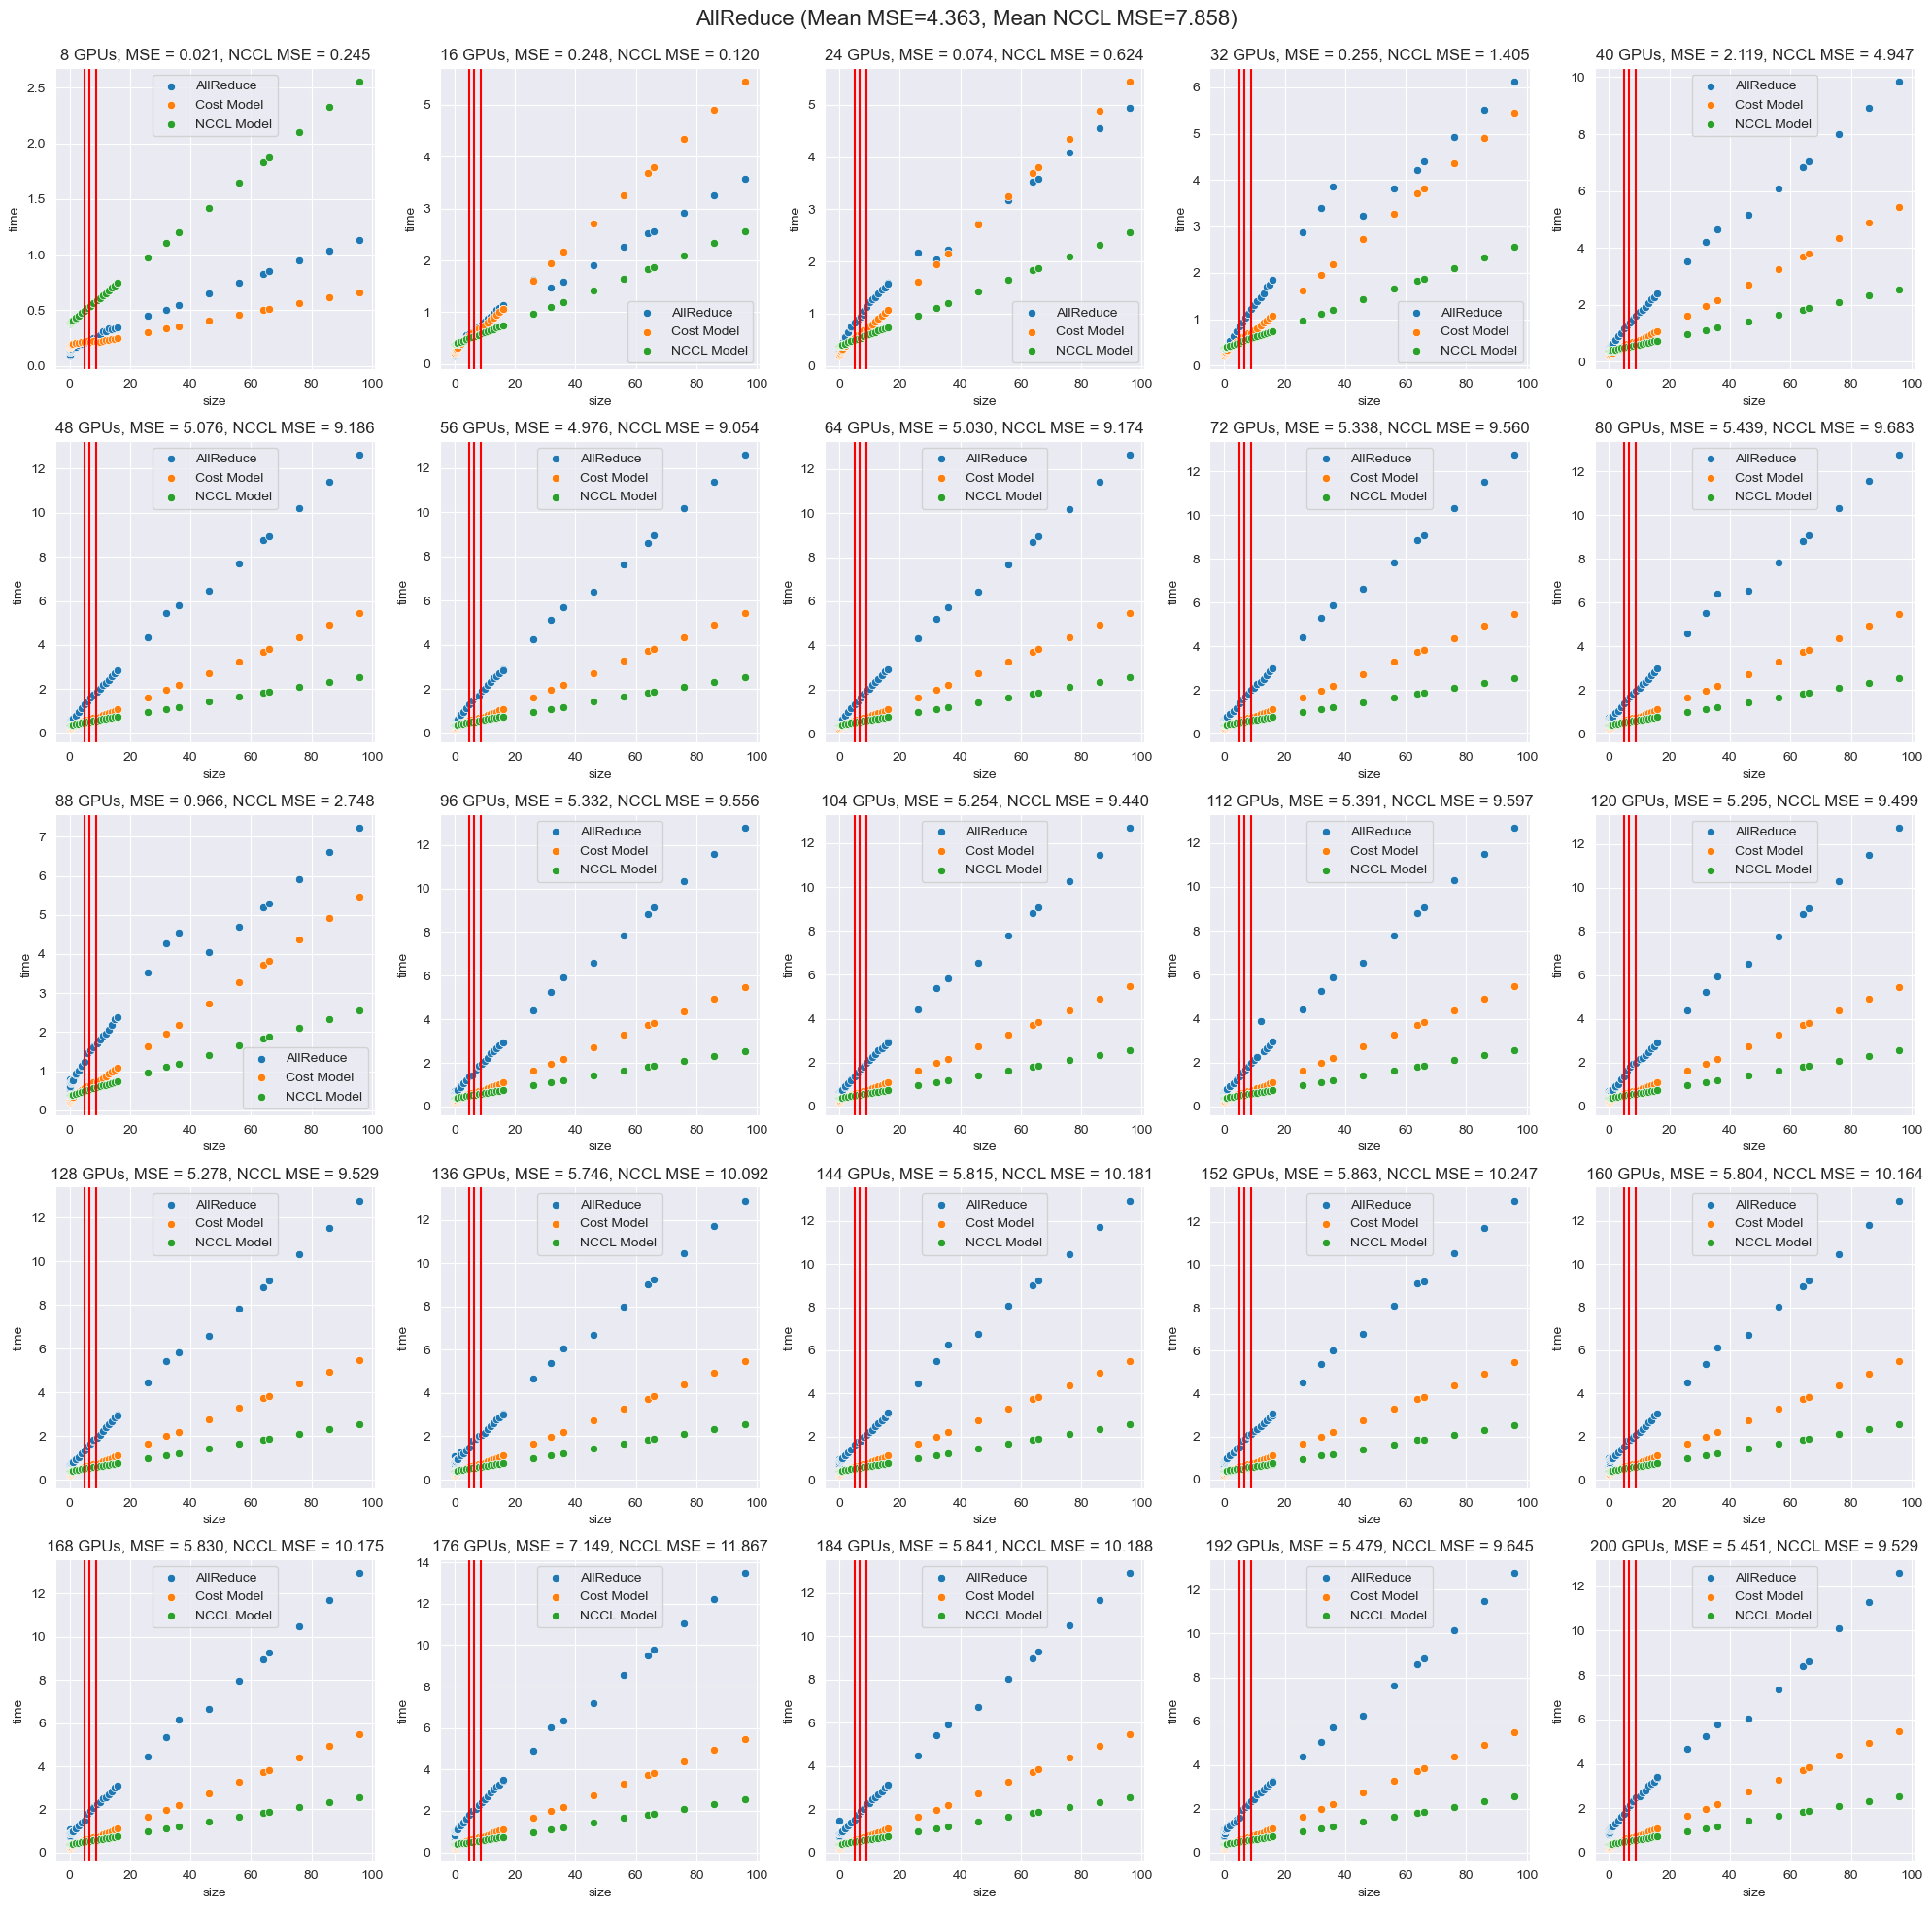

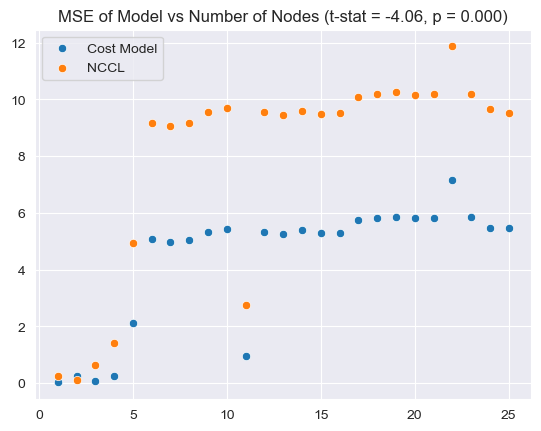

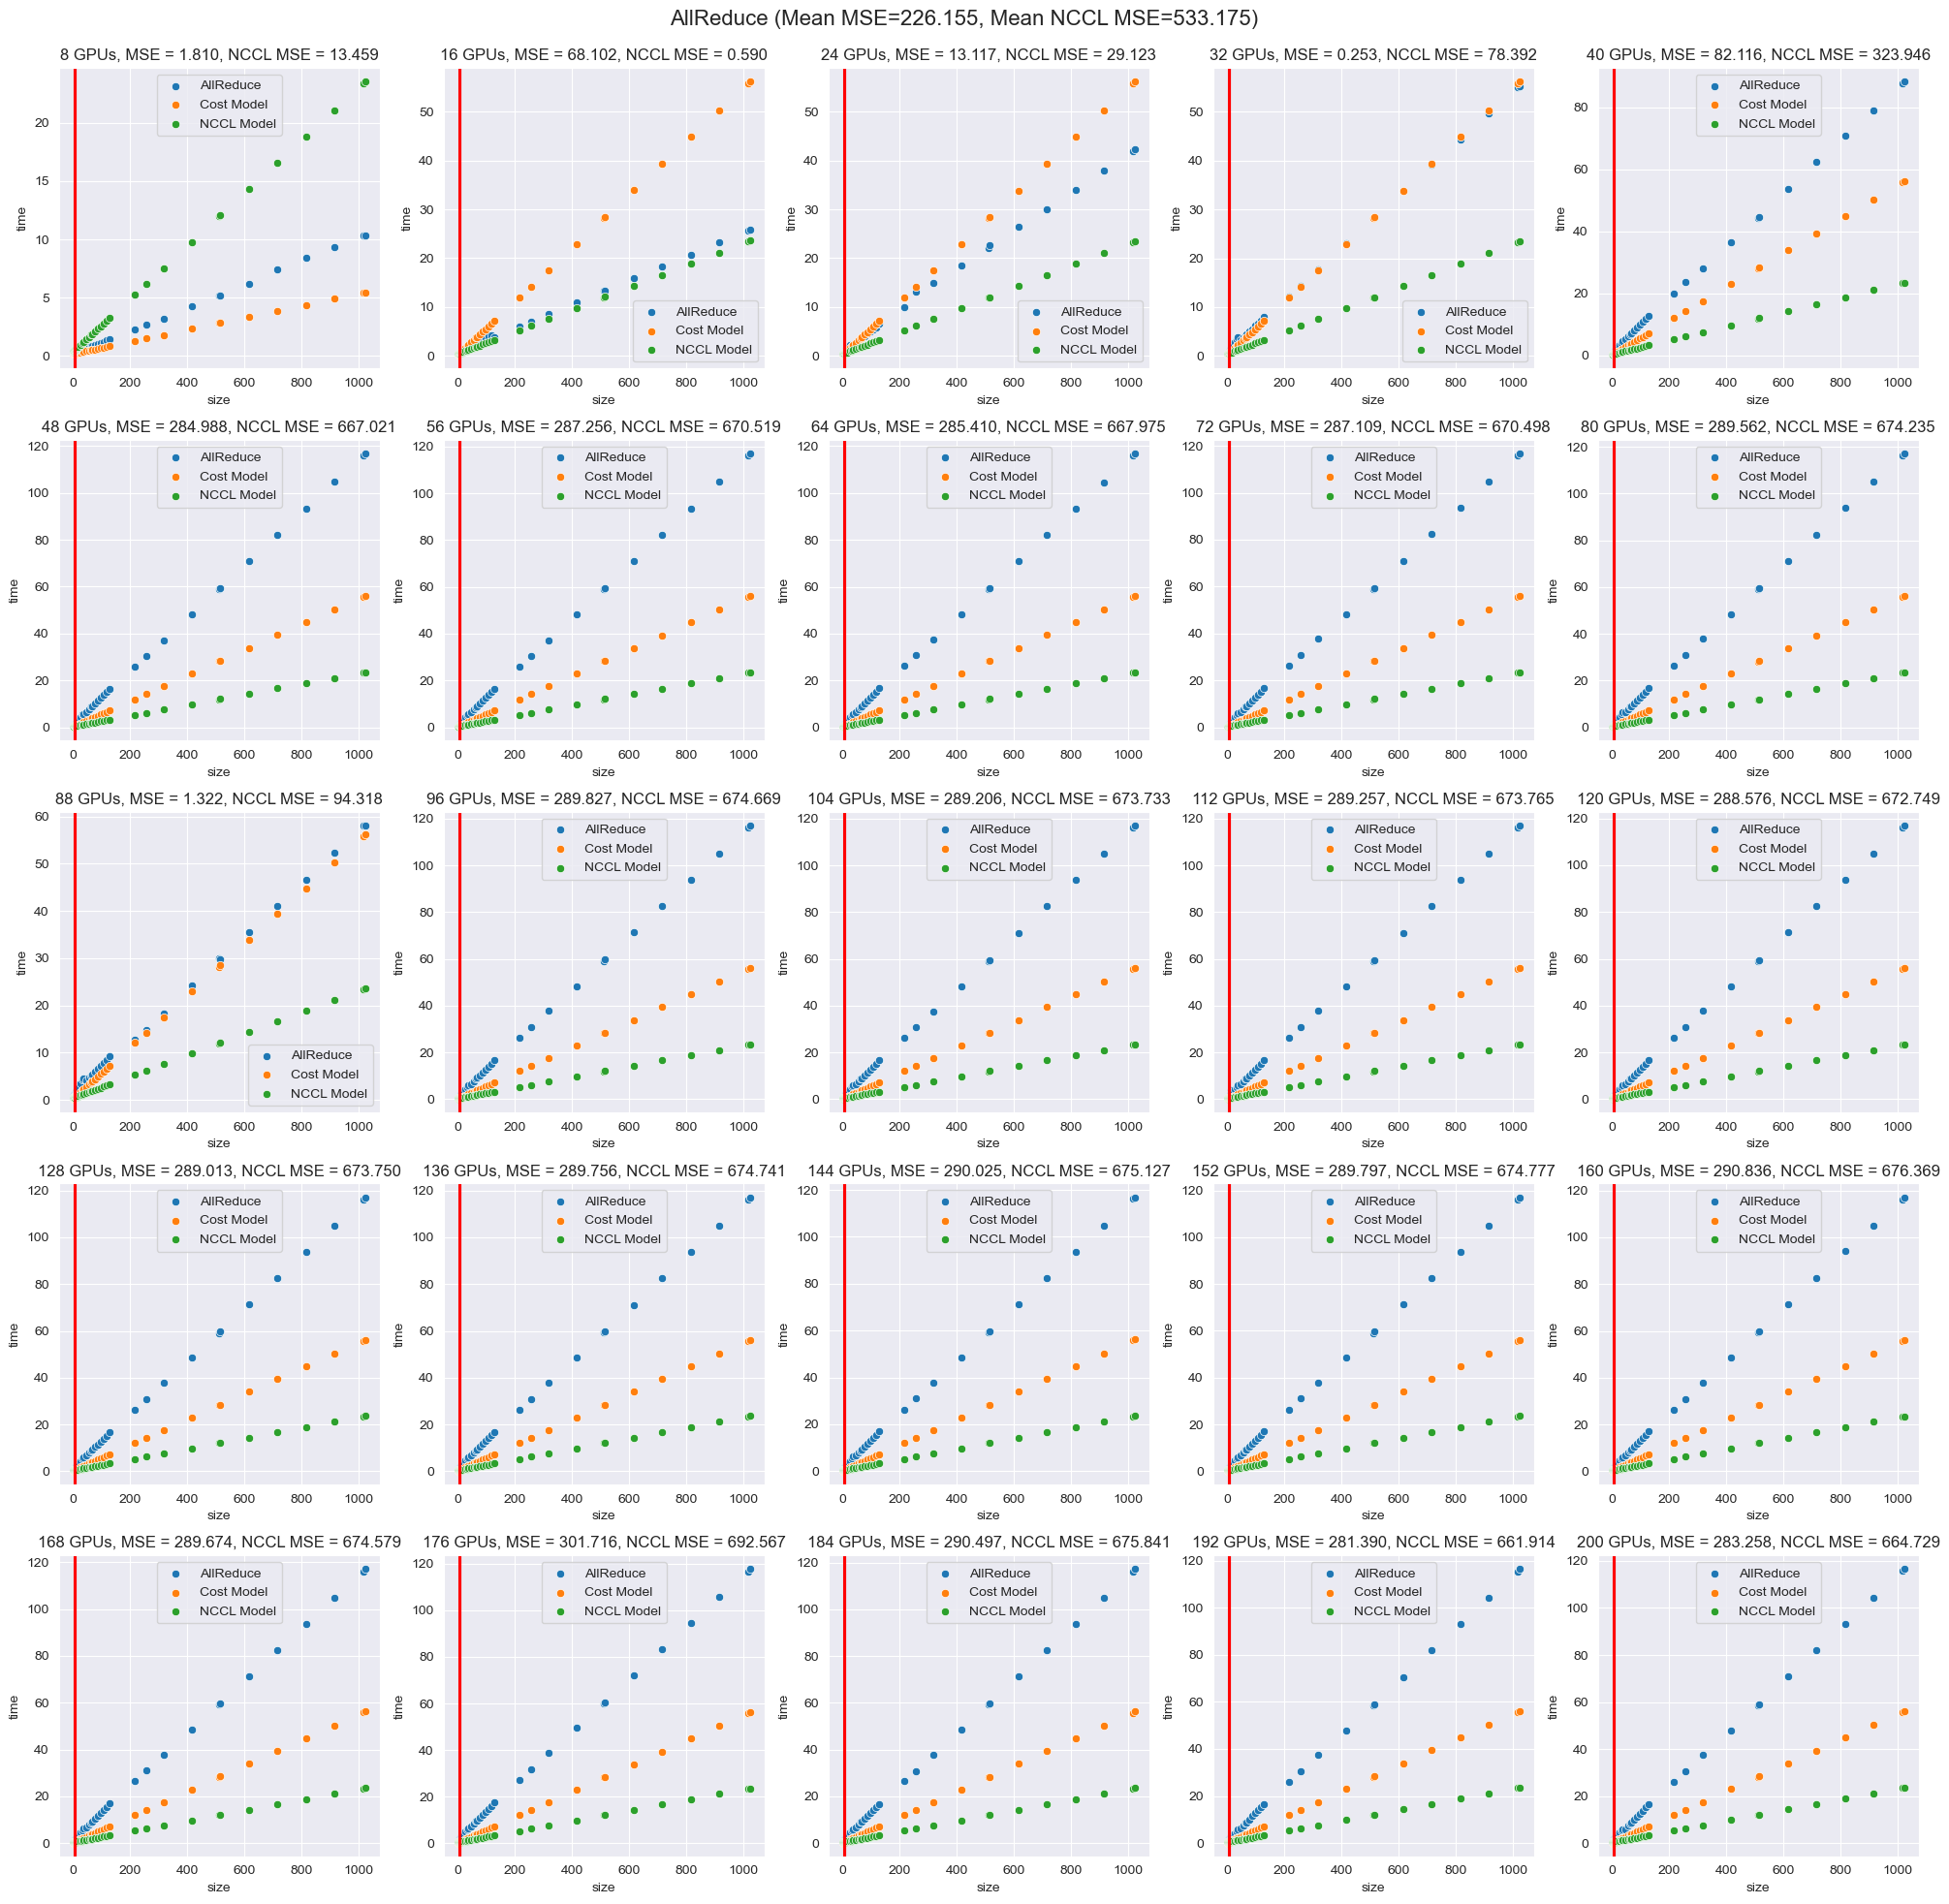

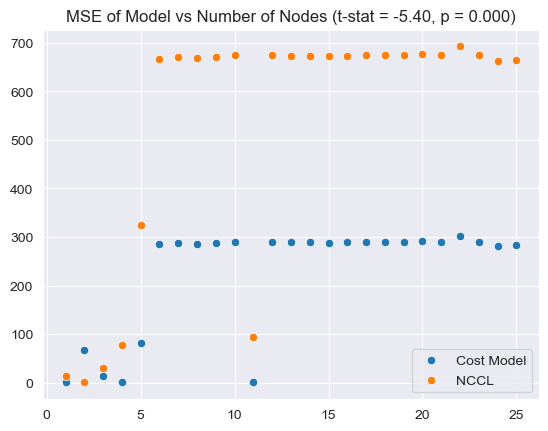

In [ ]:
# print(threshold_space[np.argmin(results)], min(results))
for lim in [2, 100, None]:
    plot_allreduce(upper_lim=lim, thresholds=[5.0, 6.578947368421053, 8.86426592797784], chunk_size=1)

## Modeling Straggler Delay (Chunk Size 1, for now)

In [ ]:
chunk_size = 1

straggle_dfs = []

for num_gpus in range(8, 208, 8):
    data_df = dfs[chunk_size][num_gpus].copy()

    data_df["model"] = [
        all_reduce_model(
            size,
            num_gpus // gpus_per_node,
            num_gpus,
            thresholds=[5.0, 6.578947368421053, 8.86426592797784],
            chunk_size=chunk_size,
        )
        for size in data_df.index
    ]

    data_df["N"] = num_gpus // gpus_per_node

    data_df["straggle"] = data_df["time_75"] - data_df["model"]

    straggle_dfs.append(data_df.reset_index().loc[:, ["size", "N", "straggle"]])

straggle_df = pd.concat(straggle_dfs, axis=0)

In [ ]:
straggle_df.describe()

size            N     straggle
count  1725.000000  1725.000000  1725.000000
mean    122.341654    13.000000     6.224254
std     253.751104     7.213194    13.717496
min       0.000061     1.000000   -30.091585
25%       0.488281     7.000000     0.397686
50%       8.000000    13.000000     0.866712
75%      75.976562    19.000000     4.025996
max    1024.000000    25.000000    61.517761

Text(0.5, 1.0, 'Histogram of Straggler Delay')

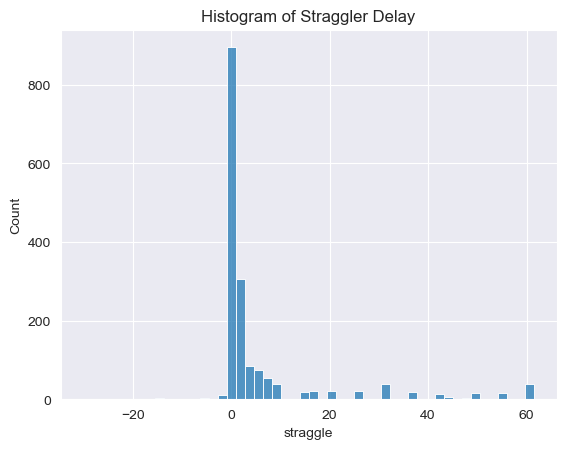

In [ ]:
sns.histplot(
    data=straggle_df,
    x="straggle",
    bins=50
)
plt.title("Histogram of Straggler Delay")

In [ ]:
straggle_df_cut = straggle_df[straggle_df["straggle"] > 0]

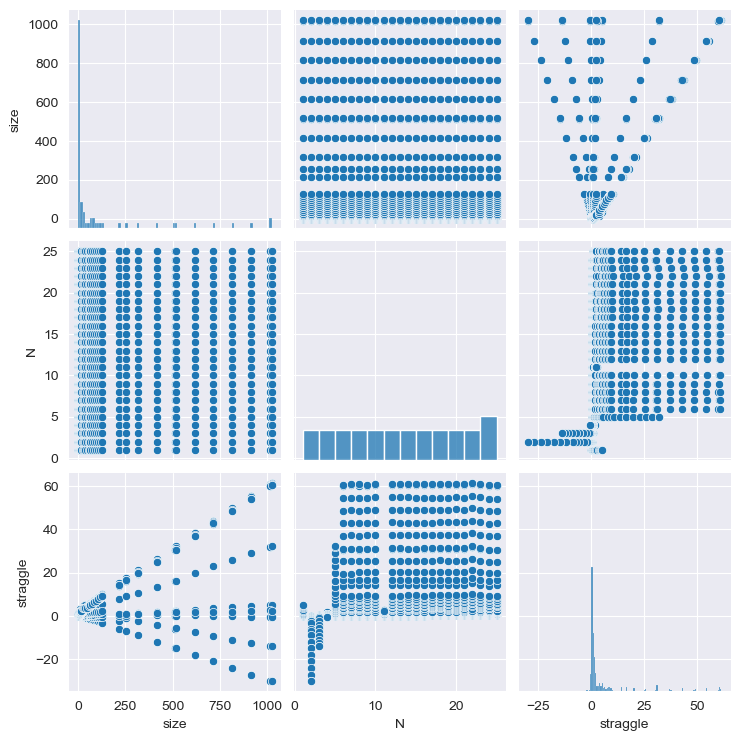

In [ ]:
sns.pairplot(
    data=straggle_df
)

In [ ]:
mod = smf.ols(formula="straggle ~ size + N", data=straggle_df_cut)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               straggle   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     5962.
Date:                Sat, 28 Oct 2023   Prob (F-statistic):               0.00
Time:                        11:34:05   Log-Likelihood:                -4849.0
No. Observations:                1625   AIC:                             9704.
Df Residuals:                    1622   BIC:                             9720.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9672      0.269     -7.308      0.000      -2.495      -1.439
size           0.0519      0.000    108.246      0.000       0.051       0.053
N              0.1960      0.017     11.339      0.000       0.162       0.230
==============================================================================
Omnibus:                     1887.240   Durbin-Watson:                   0.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           169763.501
Skew:                          -5.983   Prob(JB):                         0.00
Kurtosis:                      51.622   Cond. No.                         623.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0.5, 1.0, 'Fitted vs Residuals')

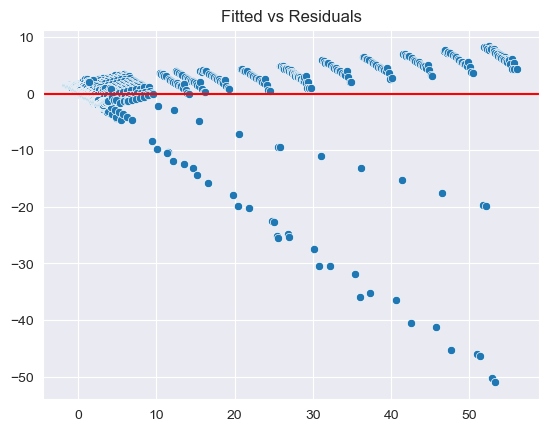

In [ ]:
sns.scatterplot(
    x=res.fittedvalues,
    y=res.resid
)
plt.axhline(0, 0, 15, c="r")

plt.title("Fitted vs Residuals")

In [ ]:
## ALLREDUCE
def all_reduce_model_straggle(
    data_size: float,
    num_nodes: int,
    num_processors: Optional[int] = None,
    thresholds: List[int] = [],
    verbose: bool = False,
    chunk_size: int = 1
):

    inter_params, intra_params = bw_params[chunk_size][0], bw_params[chunk_size][1]

    if num_processors == None:
        num_processors = num_nodes * gpus_per_node

    # inter_df, intra_df = dfs[chunk_size][0], dfs[chunk_size][1]

    inter_node_latency, intra_node_latency = bw_latencies[chunk_size][0], bw_latencies[chunk_size][1]

    piecewise_idx = bisect(thresholds, data_size)
    if piecewise_idx == 0:
        inter_bandwidth, intra_bandwidth = log_sigmoid(data_size + inter_offset, *inter_params), log_sigmoid(data_size + intra_offset, *intra_params)#  + 0.3) # offset: workaround for discontinuity of x/sigmoid(log(x)) (see below)
    else:
        threshold_size = thresholds[piecewise_idx - 1]
        inter_bandwidth, intra_bandwidth = log_sigmoid(threshold_size + inter_offset, *inter_params), log_sigmoid(
            threshold_size + intra_offset, *intra_params
        )
        # inter_bandwidth, intra_bandwidth = inter_spl(threshold_size), intra_spl(threshold_size)

    time_tree = (
        (2  * data_size) / (inter_bandwidth)
        if num_nodes > 1
        else 0
    )
    time_chain = (2 * data_size) / (
        intra_bandwidth
    )
    # latency = (np.floor(np.log2(num_nodes)) + 1) * inter_node_latency + (
    #     (num_processors / num_nodes) - 1
    # ) * intra_node_latency
    latency = 0

    straggle = res.predict(exog=dict(size=data_size, N=num_nodes)).item()

    if verbose:
        print(
            f"Size = {data_size:0.4f}, Time Tree: {time_tree:0.3f}, Time Chain: {time_chain:0.3f}, Latency: {latency:0.3f} = Total {time_tree + time_chain + latency:0.3f}"
        )

    return time_tree + time_chain + latency + max(straggle, 0)

In [ ]:
def plot_allreduce(
    lower_lim: int = None, upper_lim: int = None, thresholds: List[int] = [], chunk_size:int = 1
):
    fig, ax = plt.subplots(5, 5, figsize=(20, 20))
    ax = ax.flatten()

    mses = []
    nccl_mses = []

    for idx, axis in enumerate(ax):
        num_gpus = (idx + 1) * gpus_per_node
        data_df = dfs[chunk_size][num_gpus].copy().loc[lower_lim:upper_lim]

        data_df["model"] = [
            all_reduce_model_straggle(
                size,
                num_gpus // gpus_per_node,
                num_gpus,
                thresholds=thresholds,
                chunk_size=chunk_size,
            )
            for size in data_df.index
        ]

        data_df["nccl"] = [nccl_model(size, 1, "AllReduce", latencies=nccl_lookups[chunk_size][0][0], bandwidths=nccl_lookups[chunk_size][0][1]) for size in data_df.index]

    #     # sns.scatterplot(data=data_df, x="size", y="min", ax=axis, label="AllReduce Min")
    #     # sns.scatterplot(data=data_df, x="size", y="max", ax=axis, label="AllReduce Max")
        sns.scatterplot(data=data_df, x="size", y="time", ax=axis, label="AllReduce")
        sns.scatterplot(
            data=data_df,
            x="size",
            y="model",
            ax=axis,
            label="Cost Model",
        )
        sns.scatterplot(data=data_df, x="size", y="nccl", ax=axis, label="NCCL Model")

        for cut in thresholds:
            axis.axvline(cut, 0, 50, c="red")

        axis.legend()

        axis.set_title(
            f"{num_gpus} GPUs, MSE = {((data_df['model'] - data_df['time'])**2).mean(axis=0):0.3f}, NCCL MSE = {((data_df['nccl'] - data_df['time'])**2).mean(axis=0):0.3f}"
        )

        mses.append(((data_df["model"] - data_df["time"]) ** 2).mean(axis=0))
        nccl_mses.append(((data_df["nccl"] - data_df["time"]) ** 2).mean(axis=0))
        axis.set_xlim(
            lower_lim - 1 if lower_lim != None else lower_lim,
            upper_lim + 1 if upper_lim != None else lower_lim,
        )

    plt.suptitle(
        f"AllReduce (Mean MSE={sum(mses)/len(mses):0.3f}, Mean NCCL MSE={sum(nccl_mses)/len(nccl_mses):0.3f})",
        size=16,
    )
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

    fig, ax = plt.subplots()
    sns.scatterplot(x=list(range(1, 26)), y=mses, ax=ax, label="Cost Model")
    sns.scatterplot(x=list(range(1, 26)), y=nccl_mses, ax=ax, label="NCCL")
    ax.legend()

    tstat, pval = ttest_ind(mses, nccl_mses, equal_var=False, alternative="less")

    ax.set_title(
        f"MSE of Model vs Number of Nodes (t-stat = {tstat:0.2f}, p = {pval:0.3f})"
    )

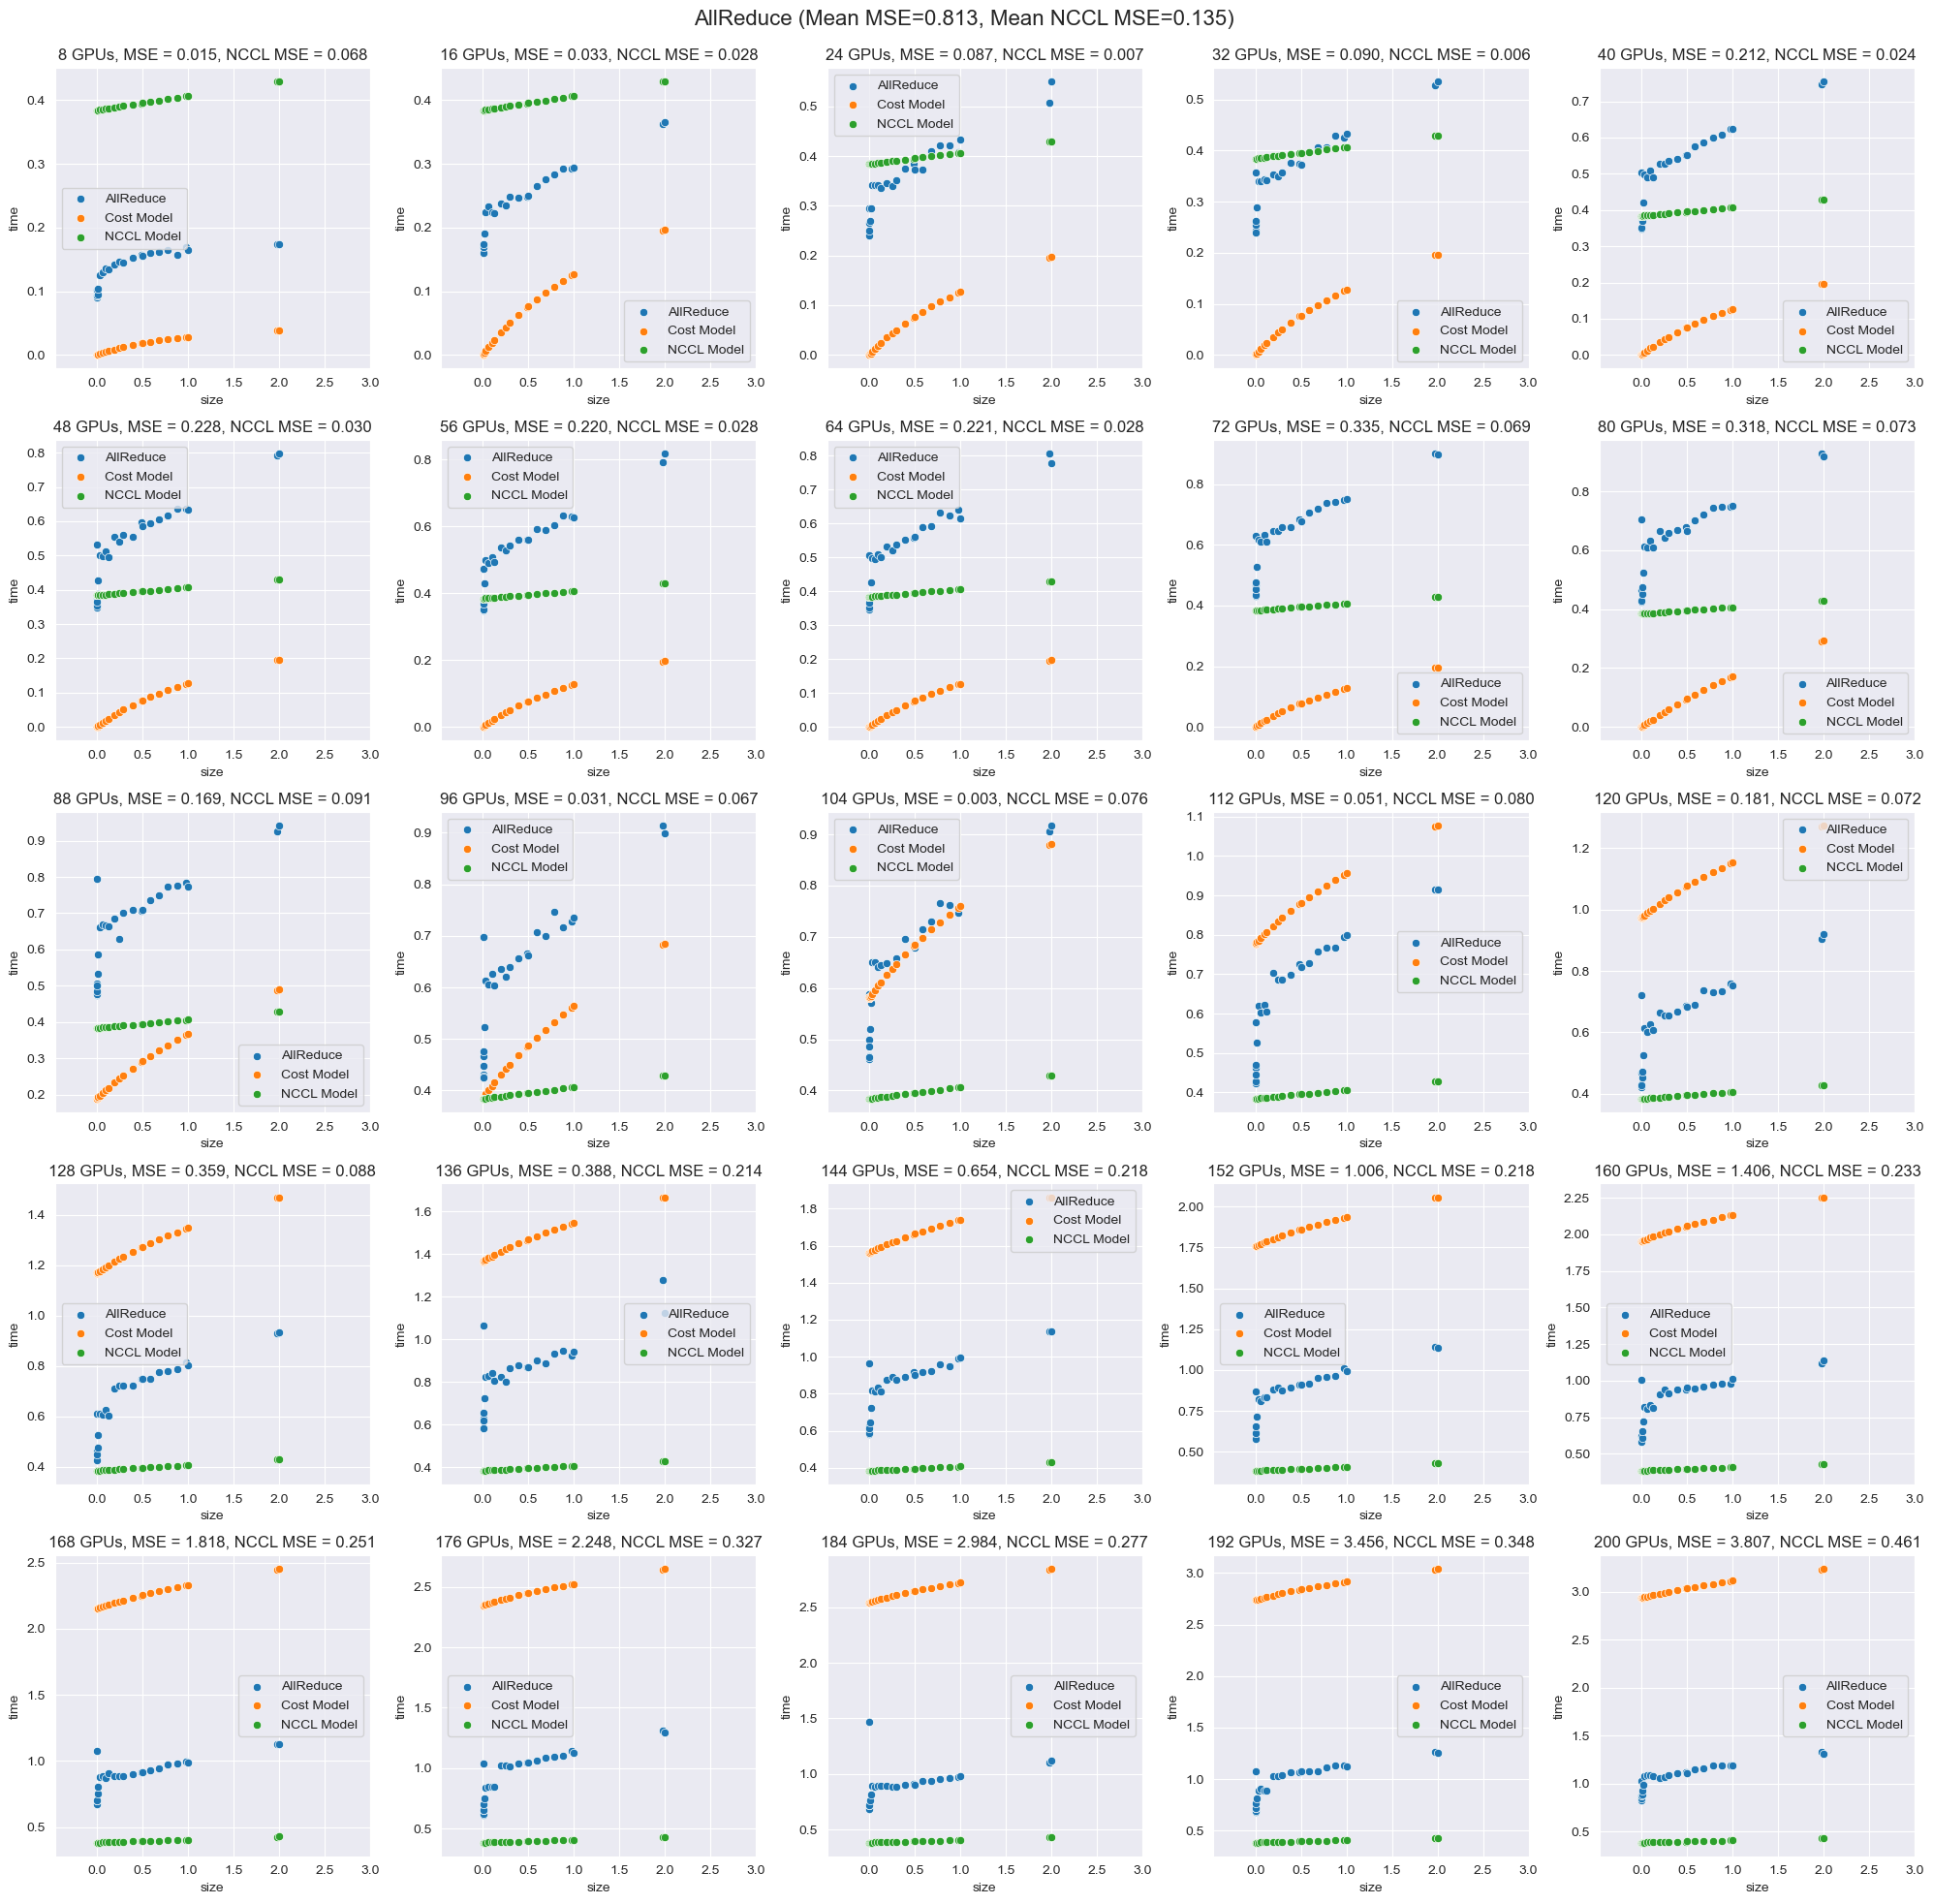

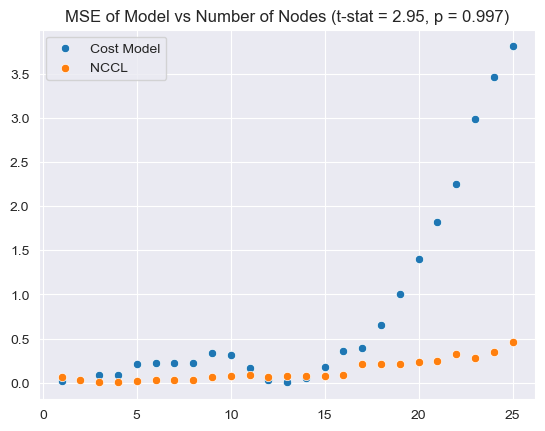

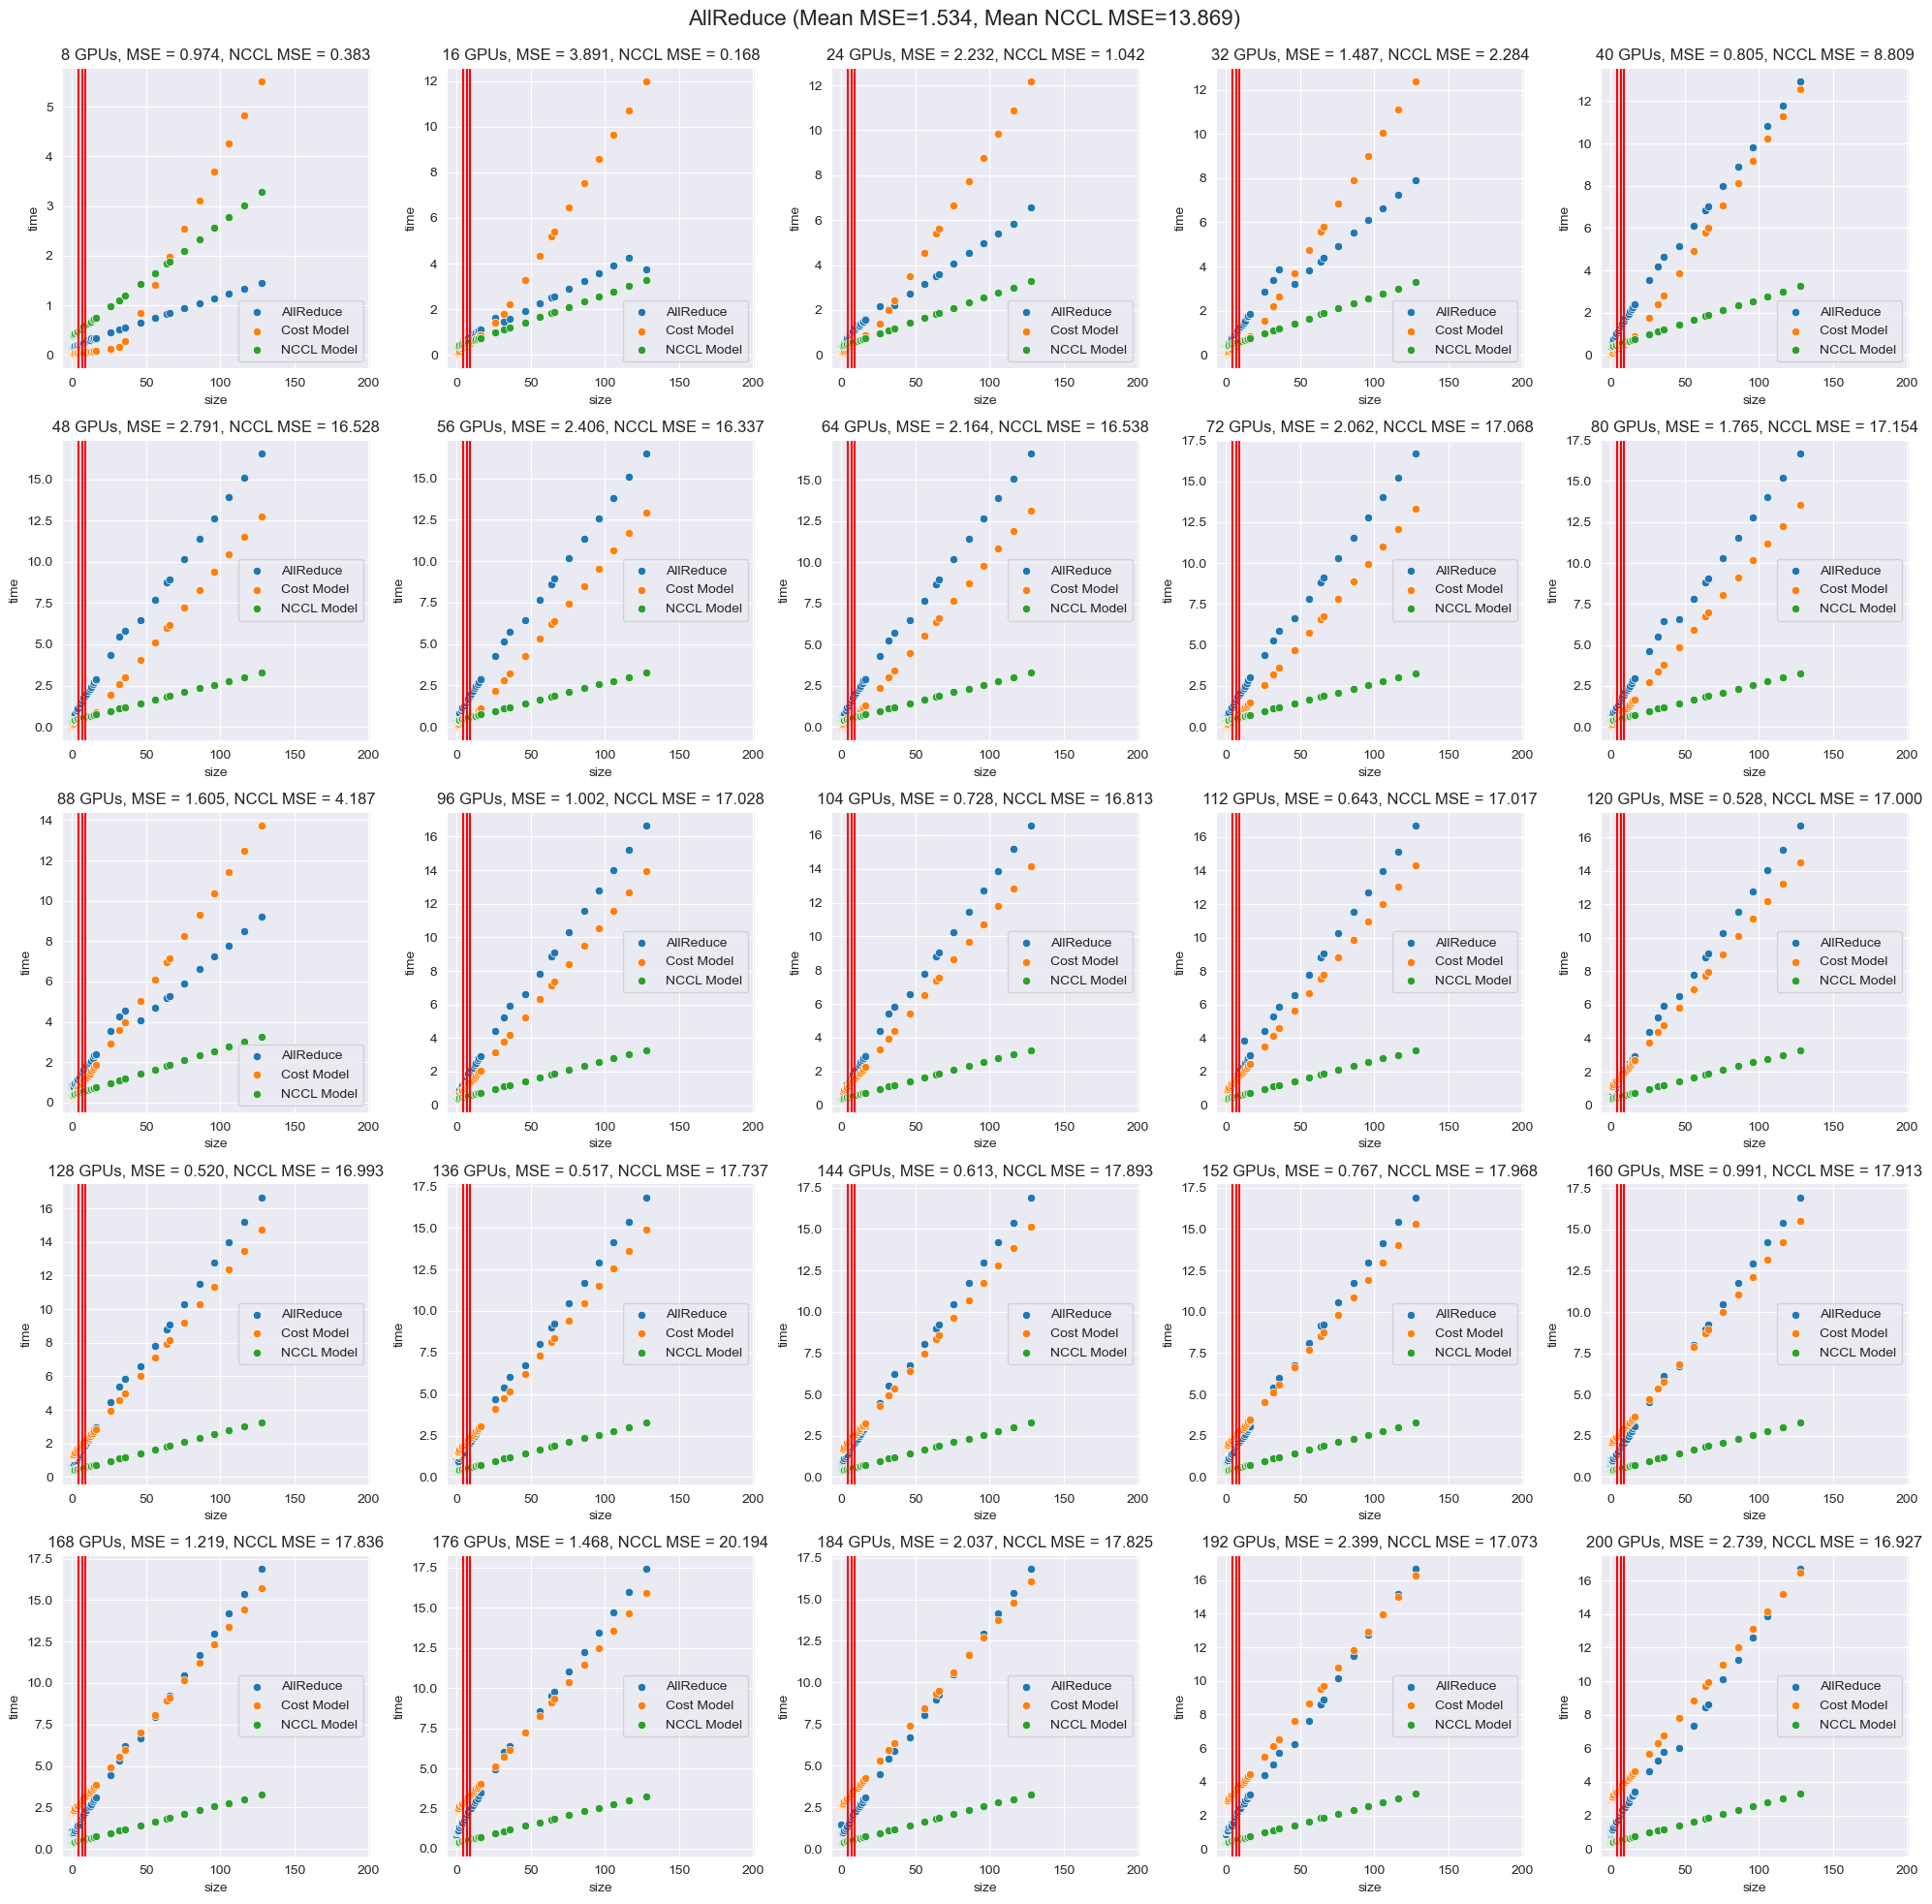

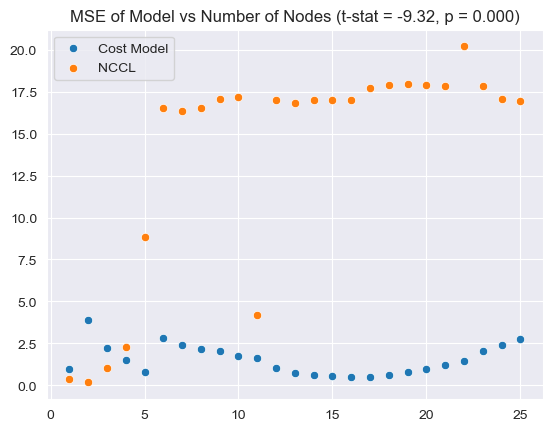

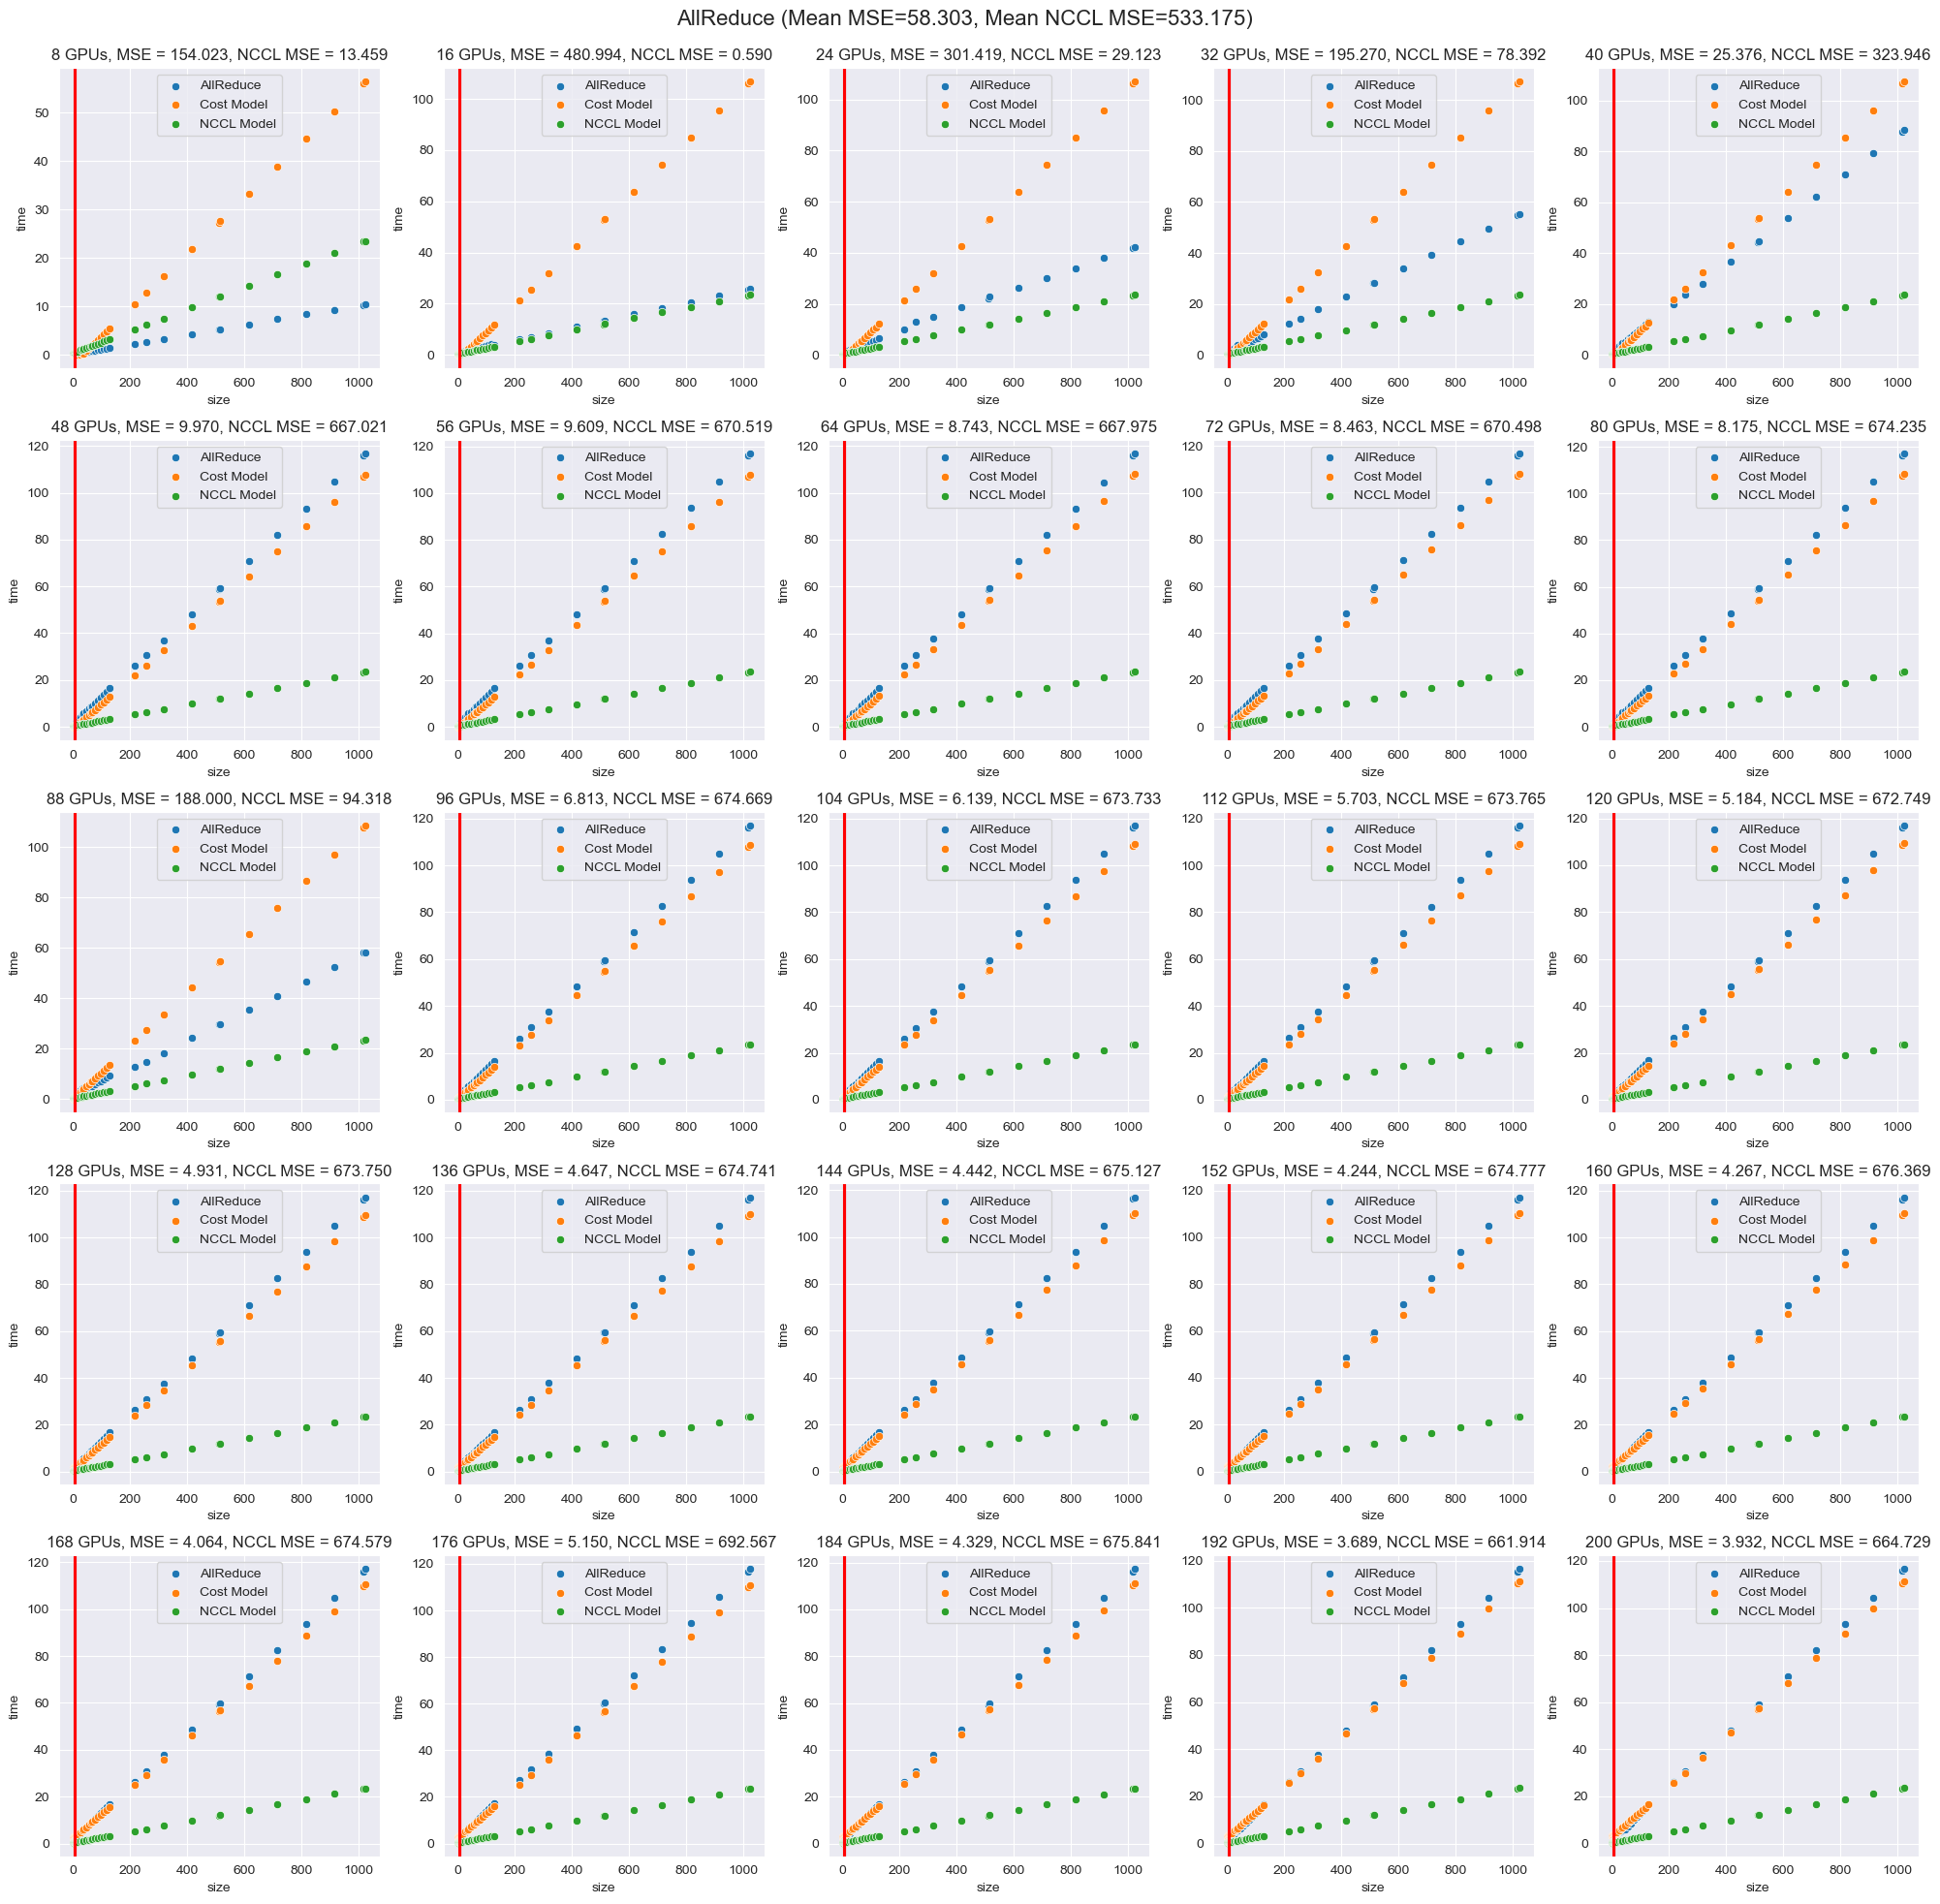

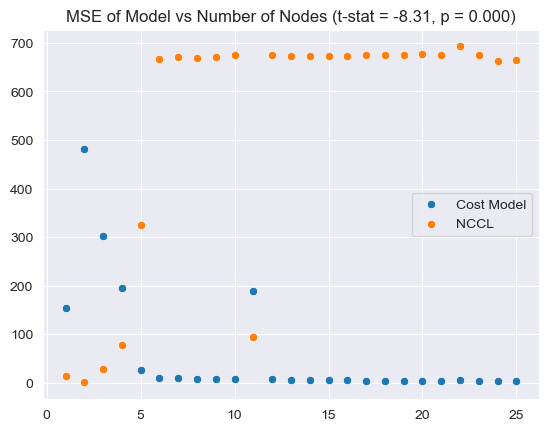

In [ ]:
for lim in [2, 200, None]:
    plot_allreduce(upper_lim=lim, thresholds=[4.5, 6.947368421052632, 9.213296398891966])